### Goal

#### Given the ACME customer survey data, our goal is to classify if a customer is happy or not based on the given answers.

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from feature_engine.variable_transformers import LogTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import f1_score
from sklearn import metrics

In [2]:
data =  pd.read_csv("D:\Apziva\\ACME-HappinessSurvey2020.csv")

### Exploring the data

In [3]:
data.shape

(126, 7)

In [4]:
data.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [5]:
# The target variable seems to be quite balanced
data["Y"].value_counts()

1    69
0    57
Name: Y, dtype: int64

In [6]:
# Looking for missing values - We don't seem to have any
data.isnull().sum()

Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64

In [7]:
# Inspecting the variable values
for var in data.columns:
    print(var, data[var].unique()[0:20])

Y [0 1]
X1 [3 5 4 1]
X2 [3 2 4 5 1]
X3 [3 2 4 5 1]
X4 [4 5 3 2 1]
X5 [2 4 3 5 1]
X6 [4 3 5 2 1]


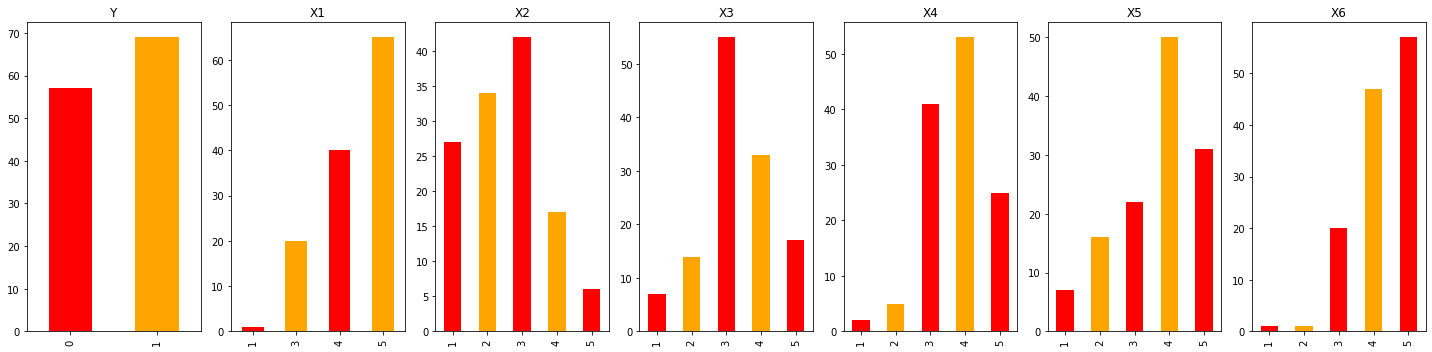

In [8]:
# Exploring the distribution of the data via histograms
fig, axes = plt.subplots(ncols=len(data.columns), figsize=(20,5))
for col, ax in zip(data, axes):
    data[col].value_counts().sort_index().plot.bar(ax=ax, title=col, color=['red', 'orange'])

plt.tight_layout()    
plt.show()

In [9]:
# The distributions is not exactly normal so we would like to achieve a normal distribution

In [10]:
# Splitting the data before training our models
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(data.drop('Y',axis=1), data.Y , test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=0)

### Data preprocessing

In [11]:
prep_pipe = Pipeline([
    # Transforming the distribution of the data to look normal
    ('lt', LogTransformer()),
       
    # Scaling the variables although we have 4 variables on the same scale except for one - Scaling via mean normalization
    ("standardscaler" , StandardScaler(with_mean=True, with_std=False)),
    ("robustscaler" , RobustScaler(with_centering=False, with_scaling=True, quantile_range=(0, 100))) 
    ])

In [12]:
prep_pipe.fit(X_train, y_train)
X_train=prep_pipe.transform(X_train)
X_val=prep_pipe.transform(X_val)
X_test=prep_pipe.transform(X_test)

In [13]:
# creating a scorer for F1 score - The F1 score is a optimal metric choice for this kind of dataset wher
# rather then focusing on just happy or unhappy customers F1 score helps determine the trade off between the two
from sklearn.metrics import fbeta_score, make_scorer
f1score = make_scorer(fbeta_score, beta=1)
f1score

make_scorer(fbeta_score, beta=1)

### Model Training

#### Logistic Regression - with L2 (Ridge) penalty

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

logreg_l2 = LogisticRegression(max_iter=10000, random_state=42)

logreg_param = {'penalty':['l2'],
                'dual':[True],
                'C':[0.01, 0.1, 0.2, 0.5], 
                'fit_intercept':[True,False],
                'solver':['liblinear'],
                'warm_start':[True,False]}

logreg_l2_grid = GridSearchCV(logreg_l2, logreg_param, cv=10, return_train_score=True, scoring= f1score)
logreg_l2_grid.fit(X_train,y_train)

print('Best Parameters for Logistic Regression: ', logreg_l2_grid.best_params_, '\n')

# Mean Cross validation Score
print("Best Mean Cross-validation score: {}".format(logreg_l2_grid.best_score_), '\n')

# Check test data set performance
print("Logistic Test Performance: ", logreg_l2_grid.score(X_test,y_test))
print("Logistic Validation Performance: ", logreg_l2_grid.score(X_val,y_val))

Best Parameters for Logistic Regression:  {'C': 0.2, 'dual': True, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear', 'warm_start': True} 

Best Mean Cross-validation score: 0.7695571095571095 

Logistic Test Performance:  0.7027027027027027
Logistic Validation Performance:  0.5454545454545454


#### Logistic Regression - with L1 (Lasso) penalty

In [106]:
logreg_l1 = LogisticRegression(max_iter=10000, random_state=42)

logreg_param = {'penalty':['l1'],
                'dual':[False],
                'C':[0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1], 
                'fit_intercept':[True,False],
                'solver':['saga'],
#                 'class_weight':[None,'balanced'],
                'warm_start':[True,False]}


logreg_l1_grid = GridSearchCV(logreg_l1, logreg_param, cv=10, return_train_score=True, scoring= f1score)
logreg_l1_grid.fit(X_train,y_train)

print('Best Parameters for Logistic Regression: ', logreg_l1_grid.best_params_, '\n')

# Mean Cross validation Score
print("Best Mean Cross-validation score: {}".format(logreg_l1_grid.best_score_), '\n')

# Check test data set performance
print("Logistic Test Performance: ", logreg_l1_grid.score(X_test,y_test))
print("Logistic Validation Performance: ", logreg_l1_grid.score(X_val,y_val))

Best Parameters for Logistic Regression:  {'C': 0.1, 'dual': False, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga', 'warm_start': True} 

Best Mean Cross-validation score: 0.7588578088578088 

Logistic Test Performance:  0.6666666666666666
Logistic Validation Performance:  0.5714285714285715


#### Logistic Regression - Elastic net

In [114]:
logreg_l1l2 = LogisticRegression(max_iter=10000, random_state=42)

logreg_param = {'penalty':['elasticnet'],
                'dual':[False],
                'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                'fit_intercept':[True,False],
                'solver':['saga'],
                'class_weight':[None,'balanced'],
                'warm_start':[True,False],
                'l1_ratio':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}

logreg_l1l2_grid = GridSearchCV(logreg_l1l2, logreg_param, cv=10, return_train_score=True, scoring= f1score)
logreg_l1l2_grid.fit(X_train,y_train)

print('Best Parameters for Logistic Regression: ', logreg_l1l2_grid.best_params_, '\n')

# Mean Cross validation Score
print("Best Mean Cross-validation score: {}".format(logreg_l1l2_grid.best_score_), '\n')

# Check test data set performance
print("Logistic Test Performance: ", logreg_l1l2_grid.score(X_test,y_test))
print("Logistic Validation Performance: ", logreg_l1l2_grid.score(X_val,y_val))

Best Parameters for Logistic Regression:  {'C': 0.001, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'l1_ratio': 0.1, 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True} 

Best Mean Cross-validation score: 0.7588578088578088 

Logistic Test Performance:  0.6666666666666666
Logistic Validation Performance:  0.5714285714285715


#### Ridge Classifier (L2 Classification)

In [101]:
from sklearn.linear_model import RidgeClassifier
ridge_clf = RidgeClassifier(random_state = 42)

ridge_param = {'alpha':[1,2,5,10,12,15,20,25],
               'fit_intercept':[True,False],
               'normalize':[True,False],
               'copy_X':[True,False],
               'class_weight':[None,'balanced'],
               'solver':['auto','svd','cholesky','lsqr','sparse_cg','sag','saga']
               
}

ridge_grid = GridSearchCV(ridge_clf, ridge_param, cv=10 ,return_train_score=True ,scoring=f1score)
ridge_grid.fit(X_train, y_train)

print('Best Parameters: ', ridge_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(ridge_grid.best_score_), '\n')

print("Test Performance: ", ridge_grid.score(X_test,y_test))
print("Validation Performance: ", ridge_grid.score(X_val,y_val))

Best Parameters:  {'alpha': 5, 'class_weight': None, 'copy_X': True, 'fit_intercept': True, 'normalize': True, 'solver': 'auto'} 

Best Mean Cross-validation score: 0.7725407925407927 

Test Performance:  0.6842105263157895
Validation Performance:  0.5294117647058825


#### KNN Classifier

In [68]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

param_knn = {'n_neighbors': range(5,25), 
             'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
            'weights':['uniform','distance']}

grid_knn = GridSearchCV(knn, param_knn, cv=10, return_train_score=True, scoring= f1score)
grid_knn.fit(X_train, y_train)

print('Best Parameters: ', grid_knn.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(grid_knn.best_score_), '\n')

print("Test Performance: ", grid_knn.score(X_test,y_test))
print("Validation Performance: ", grid_knn.score(X_val,y_val))

Best Parameters:  {'algorithm': 'brute', 'n_neighbors': 6, 'weights': 'uniform'} 

Best Mean Cross-validation score: 0.7313675213675215 

Test Performance:  0.5185185185185186
Validation Performance:  0.5


#### Decision Tree

In [72]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=0)

param_dtree = {"max_depth": [1,2,3,4,5],
           "min_samples_split": [2,3,4],
           "max_leaf_nodes": [2,3,4,5],
           "criterion":['gini'],
           "splitter":['best','random']}

grid_dtree = GridSearchCV(dtree, param_dtree, cv=10, return_train_score = True, scoring= f1score)
grid_dtree.fit(X_train, y_train)

print('Best Parameters: ', grid_dtree.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(grid_dtree.best_score_), '\n')

print("Test Performance: ", grid_dtree.score(X_test,y_test))
print("Validation Performance: ", grid_dtree.score(X_val,y_val))

Best Parameters:  {'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 4, 'min_samples_split': 2, 'splitter': 'best'} 

Best Mean Cross-validation score: 0.7894017094017094 

Test Performance:  0.6857142857142856
Validation Performance:  0.6060606060606061


#### Linear Support Vector Classifier

In [79]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC(random_state=42)

param = [{'penalty':['l2'],
          'C': [0.001, 0.002, 0.0001, 0.008, 0.01, 0.1], 
          'loss':['hinge','squared_hinge']}]

svc_grid = GridSearchCV(lsvc, param, cv=10 ,return_train_score=True ,scoring=f1score)
svc_grid.fit(X_train, y_train)

print('Best Parameters: ', svc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(svc_grid.best_score_), '\n')

print("Test Performance: ", svc_grid.score(X_test,y_test))
print("Validation Performance: ", svc_grid.score(X_val,y_val))

Best Parameters:  {'C': 0.001, 'loss': 'hinge', 'penalty': 'l2'} 

Best Mean Cross-validation score: 0.7588578088578088 

Test Performance:  0.6666666666666666
Validation Performance:  0.5294117647058825


#### Kernel Support Vector Classifier

In [83]:
from sklearn.svm import SVC
svc = SVC()
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['poly'],
               'degree': [2, 3, 4, 5, 6]},
              {'kernel': ['sigmoid'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}]

svm_grid = GridSearchCV(svc, param_grid, cv=10 ,return_train_score=True ,scoring=f1score)
svm_grid.fit(X_train, y_train)

print('Best Parameters: ', svm_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(svm_grid.best_score_), '\n')

print("Test Performance: ", svm_grid.score(X_test,y_test))
print("Validation Performance: ", svm_grid.score(X_val,y_val))

Best Parameters:  {'degree': 3, 'kernel': 'poly'} 

Best Mean Cross-validation score: 0.7821756021756021 

Test Performance:  0.6470588235294118
Validation Performance:  0.5294117647058825


#### Stochastic Gradient Descent Classifier

In [26]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier(random_state=42)
sgdc_param = {'penalty': ['l2', 'l1','elasticnet'],
              'l1_ratio': [0.1,0.3,0.5,0.7,0.9],
                      'alpha': [0.0001, 0.001, 0.01, 0.02, 0.05, 1, 10],
                      'fit_intercept': [True, False],
                      'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
                      'eta0': [0.001, 0.01,0.05,0.1,0.2,0.3,0.4,0.5]
                     }    

sgdc_grid = GridSearchCV(sgdc, sgdc_param, cv=10, return_train_score = True, scoring= f1score)
sgdc_grid.fit(X_train, y_train)

print('Best Parameters: ', sgdc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(sgdc_grid.best_score_), '\n')

print("Test Performance: ", sgdc_grid.score(X_test,y_test))
print("Validation Performance: ", sgdc_grid.score(X_val,y_val))

Best Parameters:  {'alpha': 0.05, 'eta0': 0.1, 'fit_intercept': True, 'l1_ratio': 0.1, 'learning_rate': 'constant', 'penalty': 'l2'} 

Best Mean Cross-validation score: 0.7652680652680653 

Test Performance:  0.6842105263157895
Validation Performance:  0.5294117647058825


#### QDA

In [18]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
param_grid = {
    'reg_param': [0.001,0.01,0.1,0.3,0.5,0.7],
    'priors': [None],
    'reg_param': [0,0.2,0.1],
    'tol': [0.0001, 0.001]
    }    

qda_grid = GridSearchCV(QuadraticDiscriminantAnalysis(), param_grid, scoring=f1score, cv=10,  n_jobs=-1)

qda_grid.fit(X_train,y_train)

print('Best Parameters: ', qda_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(qda_grid.best_score_), '\n')

print("Test Performance: ", qda_grid.score(X_test,y_test))
print("Validation Performance: ", qda_grid.score(X_val,y_val))

Best Parameters:  {'priors': None, 'reg_param': 0.2, 'tol': 0.0001} 

Best Mean Cross-validation score: 0.7422843822843823 

Test Performance:  0.7222222222222222
Validation Performance:  0.5454545454545454


#### LDA

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

param_grid = {'solver' : ['lsqr', 'eigen'],
              'shrinkage': [None, 0.0001, 0.001, 0.01, 0.0005, 0.005, 0.05, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}    

lda_grid = GridSearchCV(LinearDiscriminantAnalysis(), param_grid, scoring=f1score, cv=10, n_jobs=-1)

lda_grid.fit(X_train,y_train)

print('Best Parameters: ', lda_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(lda_grid.best_score_), '\n')

print("Test Performance: ", lda_grid.score(X_test,y_test))
print("Validation Performance: ", lda_grid.score(X_val,y_val))

Best Parameters:  {'shrinkage': 0.3, 'solver': 'lsqr'} 

Best Mean Cross-validation score: 0.7237878787878788 

Test Performance:  0.7096774193548387
Validation Performance:  0.5185185185185185


#### Bootstrap Aggregated Decision Tree

In [122]:
from sklearn.ensemble import BaggingClassifier
bag_dtree1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(), bootstrap=True, random_state=0, oob_score=False)

bag_dtree1_param = {
                 'base_estimator__max_depth': [1,2,3],
                 'base_estimator__max_leaf_nodes': [2,3,4,5],
                 'base_estimator__min_samples_split':[2,3,4],
                 'base_estimator__criterion':['gini','entropy'],
                 'max_samples':  [0.8,1],
                 'n_estimators': [50,100,200]}

bag_dtree1_grid = GridSearchCV(bag_dtree1, bag_dtree1_param,cv=5, return_train_score=True, scoring=f1score)
bag_dtree1_grid.fit(X_train,y_train)

print('Best Parameters: ', bag_dtree1_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(bag_dtree1_grid.best_score_), '\n')

print("Test Performance: ", bag_dtree1_grid.score(X_test,y_test))
print("Validation Performance: ", bag_dtree1_grid.score(X_val,y_val))

Best Parameters:  {'base_estimator__max_depth': 1, 'max_samples': 0.8, 'n_estimators': 100} 

Best Mean Cross-validation score: 0.7745153397327311 

Test Performance:  0.6857142857142856
Validation Performance:  0.6060606060606061


#### Random Forest Classifier

In [121]:
from sklearn.ensemble import RandomForestClassifier
rfc =RandomForestClassifier(random_state=42, oob_score=False)
rfc_param = { 
    'n_estimators': [20,50,100],
    'max_features': ['auto'],
    'max_depth' : [2,3,4],
    'criterion' :['gini', 'entropy'],
    'min_samples_split':[2,3,4,5],
    'min_samples_leaf':[1,2,3]
}

rfc_grid = GridSearchCV(rfc, rfc_param,cv=10, return_train_score=True, scoring=f1score)
rfc_grid.fit(X_train,y_train)

print('Best Parameters: ', rfc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(rfc_grid.best_score_), '\n')

print("Test Performance: ", rfc_grid.score(X_test,y_test))
print("Validation Performance: ", rfc_grid.score(X_val,y_val))

Best Parameters:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100} 

Best Mean Cross-validation score: 0.7725252525252525 

Test Performance:  0.6470588235294118
Validation Performance:  0.6451612903225806


In [126]:
from sklearn.ensemble import RandomForestClassifier
rfc =RandomForestClassifier(random_state=42, oob_score=False)
rfc_param = { 
    'n_estimators': [100,200,250,300,350,500],
    'max_features': ['auto'],
    'max_depth' : [2,3,4],
    'criterion' :['gini'],
    'min_samples_split':[2,3],
    'min_samples_leaf':[1,2,3]
}

rfc_grid = GridSearchCV(rfc, rfc_param,cv=10, return_train_score=True, scoring=f1score)
rfc_grid.fit(X_train,y_train)

print('Best Parameters: ', rfc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(rfc_grid.best_score_), '\n')

print("Test Performance: ", rfc_grid.score(X_test,y_test))
print("Validation Performance: ", rfc_grid.score(X_val,y_val))

Best Parameters:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200} 

Best Mean Cross-validation score: 0.7821756021756021 

Test Performance:  0.6857142857142856
Validation Performance:  0.6060606060606061


#### Extra Trees Classfier

In [127]:
from  sklearn.ensemble import ExtraTreesClassifier
etc= ExtraTreesClassifier(random_state=42)
etc_param = { 
    'n_estimators': [20, 50, 150, 500],
    'max_features': ['auto'],
    'max_depth' : [2,3,4,10,12],
    'criterion' :['gini','entropy'],
    'min_samples_split':[2,3,5,7,9],
    'min_samples_leaf':[1,2,3]
}
etc_grid = GridSearchCV(etc, etc_param, cv=10, return_train_score=True, scoring=f1score)
etc_grid.fit(X_train,y_train)

print('Best Parameters: ', etc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(etc_grid.best_score_), '\n')

print("Test Performance: ", etc_grid.score(X_test,y_test))
print("Validation Performance: ", etc_grid.score(X_val,y_val))

Best Parameters:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50} 

Best Mean Cross-validation score: 0.7915695415695416 

Test Performance:  0.6857142857142856
Validation Performance:  0.6060606060606061


#### AdaBoost Classifier

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
adc_dtree =AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
adc_dtree_param = {
              'base_estimator__splitter' :   ['best','random'],
              'base_estimator__max_depth' : [1,2,3],
              'base_estimator__min_samples_split':[2,3,4],
              'base_estimator__min_samples_leaf':[1,2,3],
              'algorithm' : ['SAMME', 'SAMME.R'],
              'n_estimators' : [20,50,100,150,300],
              'learning_rate' : [0.6, 0.7, 0.8,1],
             }

adc_dtree_grid = RandomizedSearchCV(adc_dtree, adc_dtree_param, cv=10, return_train_score=True, scoring=f1score)
adc_dtree_grid.fit(X_train,y_train)

print('Best Parameters: ', adc_dtree_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(adc_dtree_grid.best_score_), '\n')

print("Test Performance: ", adc_dtree_grid.score(X_test,y_test))
print("Validation Performance: ", adc_dtree_grid.score(X_val,y_val))

Best Parameters:  {'n_estimators': 20, 'learning_rate': 1, 'base_estimator__splitter': 'best', 'base_estimator__min_samples_split': 3, 'base_estimator__min_samples_leaf': 2, 'base_estimator__max_depth': 1, 'algorithm': 'SAMME'} 

Best Mean Cross-validation score: 0.6787878787878787 

Test Performance:  0.6857142857142856
Validation Performance:  0.625


#### Gradient Boosting Classifier

In [32]:
from  sklearn.ensemble import GradientBoostingClassifier
gbc= GradientBoostingClassifier(random_state=42)
gbc_param = {
              'min_samples_split':[2,3,4,5,6],
              'subsample':[0.8,1],
              'min_samples_leaf':[1,2,3],
              'max_depth' : [1,2,3,4],
#               'max_features':['auto'],
              'n_estimators' : [20,50,100,150],
              'learning_rate' : [0.2,0.3,0.7,0.5,0.9],
              'warm_start' : [True, False]
             }

gbc_grid = GridSearchCV(gbc, gbc_param,cv=10, return_train_score=True, scoring=f1score)
gbc_grid.fit(X_train,y_train)

print('Best Parameters: ', gbc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(gbc_grid.best_score_), '\n')

print("Test Performance: ", gbc_grid.score(X_test,y_test))
print("Validation Performance: ", gbc_grid.score(X_val,y_val))

Best Parameters:  {'learning_rate': 0.2, 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 20, 'subsample': 1, 'warm_start': True} 

Best Mean Cross-validation score: 0.7731351981351979 

Test Performance:  0.6666666666666667
Validation Performance:  0.6206896551724138


#### XGBoost Classifier

In [18]:
from xgboost import XGBClassifier
xgbc= XGBClassifier(random_state=42, n_jobs=-1, objective = 'binary:logistic')
xgbc_param = {
              'max_depth' : [2,3,4],
              'learning_rate':[0.001, 0.01, 0.1],
              'early_stopping_rounds':[10,15],
              'n_estimators' : [20,50,100,500],
              'eta':[0.01,0.025,0.05,0.1],
              'gamma' : [0.6,0.8,1],
              'min_child_weight' : [1,2,3],
              'subsample': [0.8, 1],
              'colsample_bytree': [0.7, 0.9, 1]
             }


xgbc_grid = GridSearchCV(xgbc, xgbc_param, cv=10, return_train_score=True, scoring = f1score)
xgbc_grid.fit(X_train,y_train)

print('Best Parameters: ', xgbc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(xgbc_grid.best_score_), '\n')

print("Test Performance: ", xgbc_grid.score(X_test,y_test))
print("Validation Performance: ", xgbc_grid.score(X_val,y_val))

Best Parameters:  {'colsample_bytree': 0.7, 'early_stopping_rounds': 10, 'eta': 0.01, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1} 

Best Mean Cross-validation score: 0.7957109557109556 

Test Performance:  0.6470588235294118
Validation Performance:  0.6451612903225806


#### CatBoost

In [29]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
cat = CatBoostClassifier()

param_grid = {
            'depth':[1,2,3,4,7],
            'iterations':[250,100,500,1000], 
            'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
            'l2_leaf_reg':[3,1,5,10,100], 
            'border_count':[32,5,10,20,50,100,200]
                      }

cat_grid = RandomizedSearchCV(cat, param_grid, cv=10, return_train_score=True, scoring = f1score)
cat_grid.fit(X_train,y_train)

print('Best Parameters: ', cat_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(cat_grid.best_score_), '\n')

print("Test Performance: ", cat_grid.score(X_test,y_test))
print("Validation Performance: ", cat_grid.score(X_val,y_val)) 

0:	learn: 0.6929917	total: 69.9ms	remaining: 17.4s
1:	learn: 0.6927748	total: 70.6ms	remaining: 8.75s
2:	learn: 0.6924722	total: 71.3ms	remaining: 5.87s
3:	learn: 0.6923487	total: 71.9ms	remaining: 4.42s
4:	learn: 0.6920963	total: 72.6ms	remaining: 3.56s
5:	learn: 0.6919185	total: 73.1ms	remaining: 2.97s
6:	learn: 0.6917082	total: 73.8ms	remaining: 2.56s
7:	learn: 0.6914821	total: 74.4ms	remaining: 2.25s
8:	learn: 0.6912702	total: 75.1ms	remaining: 2.01s
9:	learn: 0.6911365	total: 75.8ms	remaining: 1.82s
10:	learn: 0.6908515	total: 76.4ms	remaining: 1.66s
11:	learn: 0.6906795	total: 77.3ms	remaining: 1.53s
12:	learn: 0.6904515	total: 77.9ms	remaining: 1.42s
13:	learn: 0.6902337	total: 78.8ms	remaining: 1.33s
14:	learn: 0.6900261	total: 80.3ms	remaining: 1.26s
15:	learn: 0.6898924	total: 80.9ms	remaining: 1.18s
16:	learn: 0.6897317	total: 81.6ms	remaining: 1.12s
17:	learn: 0.6895276	total: 82.3ms	remaining: 1.06s
18:	learn: 0.6892756	total: 82.9ms	remaining: 1.01s
19:	learn: 0.6890684	t

224:	learn: 0.6494344	total: 214ms	remaining: 23.8ms
225:	learn: 0.6492783	total: 215ms	remaining: 22.8ms
226:	learn: 0.6491739	total: 216ms	remaining: 21.9ms
227:	learn: 0.6489481	total: 217ms	remaining: 20.9ms
228:	learn: 0.6488080	total: 217ms	remaining: 19.9ms
229:	learn: 0.6486534	total: 218ms	remaining: 18.9ms
230:	learn: 0.6484287	total: 218ms	remaining: 18ms
231:	learn: 0.6483294	total: 219ms	remaining: 17ms
232:	learn: 0.6482012	total: 220ms	remaining: 16.1ms
233:	learn: 0.6480223	total: 221ms	remaining: 15.1ms
234:	learn: 0.6479088	total: 221ms	remaining: 14.1ms
235:	learn: 0.6477791	total: 222ms	remaining: 13.2ms
236:	learn: 0.6476009	total: 223ms	remaining: 12.2ms
237:	learn: 0.6474749	total: 223ms	remaining: 11.3ms
238:	learn: 0.6473352	total: 224ms	remaining: 10.3ms
239:	learn: 0.6473065	total: 224ms	remaining: 9.35ms
240:	learn: 0.6471515	total: 225ms	remaining: 8.4ms
241:	learn: 0.6470884	total: 226ms	remaining: 7.46ms
242:	learn: 0.6469295	total: 226ms	remaining: 6.52m

134:	learn: 0.6624476	total: 91.8ms	remaining: 78.2ms
135:	learn: 0.6621424	total: 92.6ms	remaining: 77.6ms
136:	learn: 0.6620079	total: 93.3ms	remaining: 77ms
137:	learn: 0.6618737	total: 94.4ms	remaining: 76.6ms
138:	learn: 0.6616523	total: 95.5ms	remaining: 76.2ms
139:	learn: 0.6614806	total: 96.4ms	remaining: 75.8ms
140:	learn: 0.6609991	total: 97.3ms	remaining: 75.2ms
141:	learn: 0.6608751	total: 98.1ms	remaining: 74.6ms
142:	learn: 0.6604103	total: 98.9ms	remaining: 74ms
143:	learn: 0.6603012	total: 99.6ms	remaining: 73.3ms
144:	learn: 0.6601484	total: 100ms	remaining: 72.7ms
145:	learn: 0.6600271	total: 101ms	remaining: 72.1ms
146:	learn: 0.6599711	total: 102ms	remaining: 71.4ms
147:	learn: 0.6598250	total: 103ms	remaining: 71ms
148:	learn: 0.6597427	total: 104ms	remaining: 70.4ms
149:	learn: 0.6595541	total: 104ms	remaining: 69.6ms
150:	learn: 0.6593265	total: 105ms	remaining: 68.8ms
151:	learn: 0.6590989	total: 105ms	remaining: 68ms
152:	learn: 0.6590114	total: 106ms	remaining

75:	learn: 0.6809869	total: 46.3ms	remaining: 106ms
76:	learn: 0.6809010	total: 47ms	remaining: 106ms
77:	learn: 0.6807455	total: 48.2ms	remaining: 106ms
78:	learn: 0.6805896	total: 48.8ms	remaining: 106ms
79:	learn: 0.6802181	total: 49.3ms	remaining: 105ms
80:	learn: 0.6800490	total: 49.9ms	remaining: 104ms
81:	learn: 0.6799333	total: 50.5ms	remaining: 103ms
82:	learn: 0.6798383	total: 51.1ms	remaining: 103ms
83:	learn: 0.6796815	total: 51.7ms	remaining: 102ms
84:	learn: 0.6795621	total: 52.3ms	remaining: 102ms
85:	learn: 0.6792521	total: 52.9ms	remaining: 101ms
86:	learn: 0.6790187	total: 53.4ms	remaining: 100ms
87:	learn: 0.6788826	total: 54ms	remaining: 99.3ms
88:	learn: 0.6787008	total: 54.5ms	remaining: 98.6ms
89:	learn: 0.6785648	total: 55.1ms	remaining: 97.9ms
90:	learn: 0.6784507	total: 55.7ms	remaining: 97.3ms
91:	learn: 0.6782790	total: 56.3ms	remaining: 96.6ms
92:	learn: 0.6780897	total: 57.1ms	remaining: 96.4ms
93:	learn: 0.6779533	total: 57.7ms	remaining: 95.7ms
94:	learn

24:	learn: 0.6886360	total: 16.3ms	remaining: 147ms
25:	learn: 0.6885453	total: 17.2ms	remaining: 148ms
26:	learn: 0.6883046	total: 18.3ms	remaining: 151ms
27:	learn: 0.6881112	total: 19.3ms	remaining: 153ms
28:	learn: 0.6878120	total: 20.1ms	remaining: 153ms
29:	learn: 0.6876580	total: 20.9ms	remaining: 154ms
30:	learn: 0.6874882	total: 21.8ms	remaining: 154ms
31:	learn: 0.6873333	total: 23.1ms	remaining: 157ms
32:	learn: 0.6871600	total: 24ms	remaining: 158ms
33:	learn: 0.6870086	total: 24.8ms	remaining: 158ms
34:	learn: 0.6868254	total: 25.7ms	remaining: 158ms
35:	learn: 0.6866718	total: 26.7ms	remaining: 159ms
36:	learn: 0.6864222	total: 27.7ms	remaining: 159ms
37:	learn: 0.6862690	total: 28.7ms	remaining: 160ms
38:	learn: 0.6860999	total: 29.8ms	remaining: 161ms
39:	learn: 0.6859174	total: 30.7ms	remaining: 161ms
40:	learn: 0.6857489	total: 31.6ms	remaining: 161ms
41:	learn: 0.6854204	total: 32.6ms	remaining: 162ms
42:	learn: 0.6852740	total: 33.5ms	remaining: 161ms
43:	learn: 0.6

181:	learn: 0.6592827	total: 149ms	remaining: 55.6ms
182:	learn: 0.6590774	total: 149ms	remaining: 54.7ms
183:	learn: 0.6589609	total: 150ms	remaining: 53.8ms
184:	learn: 0.6587562	total: 151ms	remaining: 53ms
185:	learn: 0.6586472	total: 152ms	remaining: 52.1ms
186:	learn: 0.6584972	total: 152ms	remaining: 51.3ms
187:	learn: 0.6583684	total: 153ms	remaining: 50.4ms
188:	learn: 0.6582194	total: 153ms	remaining: 49.5ms
189:	learn: 0.6579353	total: 154ms	remaining: 48.6ms
190:	learn: 0.6577830	total: 155ms	remaining: 47.7ms
191:	learn: 0.6576305	total: 155ms	remaining: 46.9ms
192:	learn: 0.6574825	total: 156ms	remaining: 46ms
193:	learn: 0.6573528	total: 156ms	remaining: 45.1ms
194:	learn: 0.6572200	total: 157ms	remaining: 44.2ms
195:	learn: 0.6569218	total: 157ms	remaining: 43.4ms
196:	learn: 0.6566396	total: 158ms	remaining: 42.5ms
197:	learn: 0.6563424	total: 159ms	remaining: 41.7ms
198:	learn: 0.6562645	total: 159ms	remaining: 40.8ms
199:	learn: 0.6560469	total: 160ms	remaining: 40ms

113:	learn: 0.6744771	total: 68.9ms	remaining: 82.2ms
114:	learn: 0.6743030	total: 69.5ms	remaining: 81.6ms
115:	learn: 0.6740360	total: 70.6ms	remaining: 81.6ms
116:	learn: 0.6739512	total: 71.4ms	remaining: 81.2ms
117:	learn: 0.6737780	total: 72ms	remaining: 80.6ms
118:	learn: 0.6736501	total: 72.6ms	remaining: 79.9ms
119:	learn: 0.6735510	total: 73.2ms	remaining: 79.3ms
120:	learn: 0.6734407	total: 73.7ms	remaining: 78.6ms
121:	learn: 0.6733360	total: 74.3ms	remaining: 77.9ms
122:	learn: 0.6731355	total: 74.8ms	remaining: 77.2ms
123:	learn: 0.6730382	total: 75.4ms	remaining: 76.6ms
124:	learn: 0.6728995	total: 76.2ms	remaining: 76.2ms
125:	learn: 0.6727648	total: 76.7ms	remaining: 75.5ms
126:	learn: 0.6725469	total: 77.3ms	remaining: 74.8ms
127:	learn: 0.6724779	total: 77.8ms	remaining: 74.2ms
128:	learn: 0.6722544	total: 78.4ms	remaining: 73.5ms
129:	learn: 0.6721286	total: 78.9ms	remaining: 72.8ms
130:	learn: 0.6720177	total: 79.5ms	remaining: 72.2ms
131:	learn: 0.6719358	total: 8

61:	learn: 0.6826985	total: 36.4ms	remaining: 110ms
62:	learn: 0.6824573	total: 37.2ms	remaining: 110ms
63:	learn: 0.6823566	total: 38.2ms	remaining: 111ms
64:	learn: 0.6822222	total: 39ms	remaining: 111ms
65:	learn: 0.6819424	total: 39.6ms	remaining: 110ms
66:	learn: 0.6817120	total: 40.2ms	remaining: 110ms
67:	learn: 0.6815455	total: 40.7ms	remaining: 109ms
68:	learn: 0.6814549	total: 41.3ms	remaining: 108ms
69:	learn: 0.6812820	total: 41.9ms	remaining: 108ms
70:	learn: 0.6810040	total: 42.4ms	remaining: 107ms
71:	learn: 0.6808456	total: 43.3ms	remaining: 107ms
72:	learn: 0.6806874	total: 43.9ms	remaining: 106ms
73:	learn: 0.6805583	total: 44.4ms	remaining: 106ms
74:	learn: 0.6803363	total: 45ms	remaining: 105ms
75:	learn: 0.6801082	total: 45.5ms	remaining: 104ms
76:	learn: 0.6798807	total: 46.3ms	remaining: 104ms
77:	learn: 0.6797833	total: 47ms	remaining: 104ms
78:	learn: 0.6796452	total: 47.6ms	remaining: 103ms
79:	learn: 0.6795533	total: 48.3ms	remaining: 103ms
80:	learn: 0.67950

1:	learn: 0.6926782	total: 1.54ms	remaining: 191ms
2:	learn: 0.6924131	total: 2.11ms	remaining: 174ms
3:	learn: 0.6921792	total: 3.09ms	remaining: 190ms
4:	learn: 0.6919303	total: 3.69ms	remaining: 181ms
5:	learn: 0.6918220	total: 4.3ms	remaining: 175ms
6:	learn: 0.6915521	total: 5.25ms	remaining: 182ms
7:	learn: 0.6913196	total: 5.82ms	remaining: 176ms
8:	learn: 0.6911570	total: 6.43ms	remaining: 172ms
9:	learn: 0.6909735	total: 7ms	remaining: 168ms
10:	learn: 0.6908787	total: 7.56ms	remaining: 164ms
11:	learn: 0.6907230	total: 8.11ms	remaining: 161ms
12:	learn: 0.6904767	total: 8.64ms	remaining: 158ms
13:	learn: 0.6903618	total: 9.44ms	remaining: 159ms
14:	learn: 0.6901598	total: 10ms	remaining: 157ms
15:	learn: 0.6899429	total: 10.6ms	remaining: 156ms
16:	learn: 0.6897498	total: 11.4ms	remaining: 156ms
17:	learn: 0.6895338	total: 12ms	remaining: 155ms
18:	learn: 0.6894319	total: 12.6ms	remaining: 153ms
19:	learn: 0.6890761	total: 13.1ms	remaining: 151ms
20:	learn: 0.6888606	total: 1

237:	learn: 0.6499625	total: 141ms	remaining: 7.12ms
238:	learn: 0.6498417	total: 142ms	remaining: 6.53ms
239:	learn: 0.6496460	total: 143ms	remaining: 5.95ms
240:	learn: 0.6495525	total: 144ms	remaining: 5.37ms
241:	learn: 0.6492703	total: 145ms	remaining: 4.79ms
242:	learn: 0.6491802	total: 146ms	remaining: 4.2ms
243:	learn: 0.6490170	total: 147ms	remaining: 3.6ms
244:	learn: 0.6489403	total: 147ms	remaining: 3.01ms
245:	learn: 0.6487442	total: 148ms	remaining: 2.41ms
246:	learn: 0.6486548	total: 149ms	remaining: 1.81ms
247:	learn: 0.6485776	total: 150ms	remaining: 1.21ms
248:	learn: 0.6484418	total: 150ms	remaining: 603us
249:	learn: 0.6483201	total: 151ms	remaining: 0us
0:	learn: 0.6930447	total: 723us	remaining: 180ms
1:	learn: 0.6927144	total: 1.31ms	remaining: 163ms
2:	learn: 0.6924861	total: 1.94ms	remaining: 160ms
3:	learn: 0.6923244	total: 2.51ms	remaining: 154ms
4:	learn: 0.6920970	total: 3.1ms	remaining: 152ms
5:	learn: 0.6919006	total: 3.69ms	remaining: 150ms
6:	learn: 0.6

180:	learn: 0.6567663	total: 115ms	remaining: 43.8ms
181:	learn: 0.6566370	total: 116ms	remaining: 43.2ms
182:	learn: 0.6564463	total: 117ms	remaining: 42.7ms
183:	learn: 0.6563114	total: 117ms	remaining: 42.1ms
184:	learn: 0.6562433	total: 118ms	remaining: 41.5ms
185:	learn: 0.6561237	total: 119ms	remaining: 40.8ms
186:	learn: 0.6558825	total: 119ms	remaining: 40.2ms
187:	learn: 0.6555866	total: 120ms	remaining: 39.5ms
188:	learn: 0.6553463	total: 120ms	remaining: 38.8ms
189:	learn: 0.6551710	total: 121ms	remaining: 38.2ms
190:	learn: 0.6550515	total: 121ms	remaining: 37.5ms
191:	learn: 0.6549416	total: 122ms	remaining: 36.9ms
192:	learn: 0.6547025	total: 123ms	remaining: 36.2ms
193:	learn: 0.6546038	total: 123ms	remaining: 35.6ms
194:	learn: 0.6544204	total: 124ms	remaining: 34.9ms
195:	learn: 0.6542416	total: 125ms	remaining: 34.4ms
196:	learn: 0.6540678	total: 125ms	remaining: 33.7ms
197:	learn: 0.6539545	total: 126ms	remaining: 33.1ms
198:	learn: 0.6537723	total: 126ms	remaining: 

126:	learn: 0.6752156	total: 76.8ms	remaining: 74.4ms
127:	learn: 0.6751307	total: 77.6ms	remaining: 73.9ms
128:	learn: 0.6749646	total: 78.4ms	remaining: 73.6ms
129:	learn: 0.6748369	total: 79.3ms	remaining: 73.2ms
130:	learn: 0.6747371	total: 80.1ms	remaining: 72.8ms
131:	learn: 0.6746285	total: 80.9ms	remaining: 72.3ms
132:	learn: 0.6745249	total: 81.8ms	remaining: 71.9ms
133:	learn: 0.6744361	total: 82.6ms	remaining: 71.5ms
134:	learn: 0.6742404	total: 83.4ms	remaining: 71ms
135:	learn: 0.6740019	total: 84.1ms	remaining: 70.5ms
136:	learn: 0.6738990	total: 84.8ms	remaining: 70ms
137:	learn: 0.6738071	total: 85.4ms	remaining: 69.3ms
138:	learn: 0.6736705	total: 86.4ms	remaining: 69ms
139:	learn: 0.6735761	total: 87.2ms	remaining: 68.5ms
140:	learn: 0.6735123	total: 88ms	remaining: 68.1ms
141:	learn: 0.6734267	total: 88.9ms	remaining: 67.6ms
142:	learn: 0.6731079	total: 89.7ms	remaining: 67.1ms
143:	learn: 0.6729400	total: 90.5ms	remaining: 66.6ms
144:	learn: 0.6726226	total: 91.3ms	

65:	learn: 0.6799262	total: 42.9ms	remaining: 120ms
66:	learn: 0.6798161	total: 43.7ms	remaining: 119ms
67:	learn: 0.6796365	total: 44.7ms	remaining: 120ms
68:	learn: 0.6794751	total: 45.5ms	remaining: 119ms
69:	learn: 0.6794040	total: 46.2ms	remaining: 119ms
70:	learn: 0.6792446	total: 47.1ms	remaining: 119ms
71:	learn: 0.6790239	total: 48.1ms	remaining: 119ms
72:	learn: 0.6788110	total: 48.8ms	remaining: 118ms
73:	learn: 0.6785655	total: 49.7ms	remaining: 118ms
74:	learn: 0.6783000	total: 50.6ms	remaining: 118ms
75:	learn: 0.6781484	total: 51.3ms	remaining: 117ms
76:	learn: 0.6779816	total: 51.8ms	remaining: 116ms
77:	learn: 0.6778430	total: 52.4ms	remaining: 116ms
78:	learn: 0.6776662	total: 52.9ms	remaining: 115ms
79:	learn: 0.6775157	total: 53.5ms	remaining: 114ms
80:	learn: 0.6773463	total: 54.1ms	remaining: 113ms
81:	learn: 0.6770709	total: 54.7ms	remaining: 112ms
82:	learn: 0.6768948	total: 55.3ms	remaining: 111ms
83:	learn: 0.6767207	total: 55.9ms	remaining: 110ms
84:	learn: 0

9:	learn: 0.4702078	total: 7.34ms	remaining: 360ms
10:	learn: 0.4678666	total: 8.32ms	remaining: 370ms
11:	learn: 0.4455600	total: 9.21ms	remaining: 374ms
12:	learn: 0.4255134	total: 9.96ms	remaining: 373ms
13:	learn: 0.4106756	total: 10.9ms	remaining: 378ms
14:	learn: 0.4021742	total: 11.6ms	remaining: 374ms
15:	learn: 0.3949115	total: 12.2ms	remaining: 368ms
16:	learn: 0.3935989	total: 12.8ms	remaining: 364ms
17:	learn: 0.3872257	total: 13.8ms	remaining: 368ms
18:	learn: 0.3764965	total: 14.5ms	remaining: 366ms
19:	learn: 0.3734771	total: 15.1ms	remaining: 363ms
20:	learn: 0.3667270	total: 15.8ms	remaining: 360ms
21:	learn: 0.3628232	total: 16.5ms	remaining: 358ms
22:	learn: 0.3567030	total: 17.1ms	remaining: 356ms
23:	learn: 0.3518626	total: 17.8ms	remaining: 353ms
24:	learn: 0.3446685	total: 18.5ms	remaining: 351ms
25:	learn: 0.3345033	total: 19.2ms	remaining: 349ms
26:	learn: 0.3270573	total: 19.8ms	remaining: 347ms
27:	learn: 0.3230688	total: 20.6ms	remaining: 347ms
28:	learn: 0.

216:	learn: 0.0950532	total: 161ms	remaining: 209ms
217:	learn: 0.0949124	total: 161ms	remaining: 209ms
218:	learn: 0.0948116	total: 163ms	remaining: 209ms
219:	learn: 0.0946812	total: 164ms	remaining: 208ms
220:	learn: 0.0945389	total: 164ms	remaining: 208ms
221:	learn: 0.0943625	total: 165ms	remaining: 207ms
222:	learn: 0.0941755	total: 166ms	remaining: 206ms
223:	learn: 0.0940781	total: 167ms	remaining: 206ms
224:	learn: 0.0939547	total: 168ms	remaining: 205ms
225:	learn: 0.0937872	total: 169ms	remaining: 205ms
226:	learn: 0.0936775	total: 170ms	remaining: 204ms
227:	learn: 0.0934788	total: 170ms	remaining: 203ms
228:	learn: 0.0931791	total: 171ms	remaining: 203ms
229:	learn: 0.0930809	total: 172ms	remaining: 202ms
230:	learn: 0.0929566	total: 173ms	remaining: 202ms
231:	learn: 0.0928782	total: 174ms	remaining: 201ms
232:	learn: 0.0926102	total: 175ms	remaining: 201ms
233:	learn: 0.0923543	total: 176ms	remaining: 200ms
234:	learn: 0.0922647	total: 177ms	remaining: 199ms
235:	learn: 

387:	learn: 0.0779463	total: 298ms	remaining: 86.1ms
388:	learn: 0.0779361	total: 299ms	remaining: 85.4ms
389:	learn: 0.0779261	total: 300ms	remaining: 84.7ms
390:	learn: 0.0779164	total: 301ms	remaining: 83.9ms
391:	learn: 0.0779069	total: 302ms	remaining: 83.1ms
392:	learn: 0.0778577	total: 303ms	remaining: 82.4ms
393:	learn: 0.0778062	total: 303ms	remaining: 81.6ms
394:	learn: 0.0777592	total: 304ms	remaining: 80.8ms
395:	learn: 0.0777095	total: 305ms	remaining: 80ms
396:	learn: 0.0776726	total: 305ms	remaining: 79.2ms
397:	learn: 0.0776284	total: 306ms	remaining: 78.4ms
398:	learn: 0.0776193	total: 307ms	remaining: 77.7ms
399:	learn: 0.0776103	total: 308ms	remaining: 76.9ms
400:	learn: 0.0775843	total: 309ms	remaining: 76.2ms
401:	learn: 0.0774879	total: 309ms	remaining: 75.4ms
402:	learn: 0.0774242	total: 310ms	remaining: 74.7ms
403:	learn: 0.0773843	total: 311ms	remaining: 73.9ms
404:	learn: 0.0773364	total: 312ms	remaining: 73.1ms
405:	learn: 0.0772937	total: 312ms	remaining: 72

59:	learn: 0.1976959	total: 38.7ms	remaining: 284ms
60:	learn: 0.1951490	total: 39.4ms	remaining: 283ms
61:	learn: 0.1944647	total: 40.5ms	remaining: 286ms
62:	learn: 0.1938507	total: 41.2ms	remaining: 286ms
63:	learn: 0.1917887	total: 41.9ms	remaining: 286ms
64:	learn: 0.1907158	total: 42.6ms	remaining: 285ms
65:	learn: 0.1874159	total: 43.3ms	remaining: 285ms
66:	learn: 0.1865498	total: 44ms	remaining: 285ms
67:	learn: 0.1849712	total: 44.9ms	remaining: 285ms
68:	learn: 0.1822608	total: 45.6ms	remaining: 285ms
69:	learn: 0.1815176	total: 46.3ms	remaining: 284ms
70:	learn: 0.1793124	total: 46.9ms	remaining: 284ms
71:	learn: 0.1759211	total: 47.6ms	remaining: 283ms
72:	learn: 0.1735296	total: 48.3ms	remaining: 283ms
73:	learn: 0.1709541	total: 49ms	remaining: 282ms
74:	learn: 0.1688569	total: 49.7ms	remaining: 281ms
75:	learn: 0.1682650	total: 50.6ms	remaining: 282ms
76:	learn: 0.1665129	total: 51.3ms	remaining: 282ms
77:	learn: 0.1635459	total: 52ms	remaining: 281ms
78:	learn: 0.16302

278:	learn: 0.0864532	total: 184ms	remaining: 145ms
279:	learn: 0.0862866	total: 184ms	remaining: 145ms
280:	learn: 0.0861653	total: 186ms	remaining: 145ms
281:	learn: 0.0860317	total: 187ms	remaining: 144ms
282:	learn: 0.0857955	total: 187ms	remaining: 144ms
283:	learn: 0.0857275	total: 188ms	remaining: 143ms
284:	learn: 0.0856788	total: 189ms	remaining: 142ms
285:	learn: 0.0855888	total: 189ms	remaining: 142ms
286:	learn: 0.0854984	total: 190ms	remaining: 141ms
287:	learn: 0.0853463	total: 191ms	remaining: 141ms
288:	learn: 0.0852291	total: 192ms	remaining: 140ms
289:	learn: 0.0850842	total: 192ms	remaining: 139ms
290:	learn: 0.0849806	total: 193ms	remaining: 139ms
291:	learn: 0.0848702	total: 194ms	remaining: 138ms
292:	learn: 0.0847260	total: 194ms	remaining: 137ms
293:	learn: 0.0845455	total: 195ms	remaining: 137ms
294:	learn: 0.0844602	total: 196ms	remaining: 136ms
295:	learn: 0.0843815	total: 197ms	remaining: 135ms
296:	learn: 0.0842804	total: 197ms	remaining: 135ms
297:	learn: 

496:	learn: 0.0748225	total: 331ms	remaining: 2ms
497:	learn: 0.0747581	total: 332ms	remaining: 1.33ms
498:	learn: 0.0747195	total: 333ms	remaining: 667us
499:	learn: 0.0746836	total: 334ms	remaining: 0us
0:	learn: 0.6527904	total: 801us	remaining: 400ms
1:	learn: 0.6193383	total: 1.51ms	remaining: 375ms
2:	learn: 0.5883409	total: 2.16ms	remaining: 358ms
3:	learn: 0.5578550	total: 2.81ms	remaining: 349ms
4:	learn: 0.5362331	total: 3.46ms	remaining: 343ms
5:	learn: 0.5126417	total: 4.31ms	remaining: 355ms
6:	learn: 0.4976829	total: 5.01ms	remaining: 353ms
7:	learn: 0.4932189	total: 5.67ms	remaining: 349ms
8:	learn: 0.4745658	total: 6.33ms	remaining: 345ms
9:	learn: 0.4473020	total: 6.97ms	remaining: 342ms
10:	learn: 0.4325843	total: 7.63ms	remaining: 339ms
11:	learn: 0.4267897	total: 8.28ms	remaining: 337ms
12:	learn: 0.4243207	total: 8.94ms	remaining: 335ms
13:	learn: 0.4099832	total: 9.6ms	remaining: 333ms
14:	learn: 0.4052179	total: 10.3ms	remaining: 332ms
15:	learn: 0.4002974	total:

295:	learn: 0.0919767	total: 245ms	remaining: 169ms
296:	learn: 0.0918938	total: 246ms	remaining: 168ms
297:	learn: 0.0918163	total: 247ms	remaining: 168ms
298:	learn: 0.0917355	total: 248ms	remaining: 167ms
299:	learn: 0.0916413	total: 249ms	remaining: 166ms
300:	learn: 0.0915657	total: 250ms	remaining: 166ms
301:	learn: 0.0914220	total: 251ms	remaining: 165ms
302:	learn: 0.0913068	total: 252ms	remaining: 164ms
303:	learn: 0.0912359	total: 253ms	remaining: 163ms
304:	learn: 0.0911027	total: 254ms	remaining: 162ms
305:	learn: 0.0910317	total: 255ms	remaining: 162ms
306:	learn: 0.0909543	total: 256ms	remaining: 161ms
307:	learn: 0.0908801	total: 257ms	remaining: 160ms
308:	learn: 0.0907024	total: 258ms	remaining: 159ms
309:	learn: 0.0906403	total: 259ms	remaining: 158ms
310:	learn: 0.0905799	total: 259ms	remaining: 158ms
311:	learn: 0.0905068	total: 260ms	remaining: 157ms
312:	learn: 0.0904382	total: 261ms	remaining: 156ms
313:	learn: 0.0903677	total: 262ms	remaining: 155ms
314:	learn: 

83:	learn: 0.1708802	total: 65.3ms	remaining: 323ms
84:	learn: 0.1702959	total: 66.5ms	remaining: 325ms
85:	learn: 0.1702095	total: 67.5ms	remaining: 325ms
86:	learn: 0.1697316	total: 68.3ms	remaining: 324ms
87:	learn: 0.1675317	total: 69.1ms	remaining: 323ms
88:	learn: 0.1657791	total: 69.8ms	remaining: 322ms
89:	learn: 0.1630800	total: 70.6ms	remaining: 322ms
90:	learn: 0.1615036	total: 71.3ms	remaining: 321ms
91:	learn: 0.1609790	total: 72.2ms	remaining: 320ms
92:	learn: 0.1604876	total: 73ms	remaining: 320ms
93:	learn: 0.1591116	total: 73.9ms	remaining: 319ms
94:	learn: 0.1577478	total: 74.6ms	remaining: 318ms
95:	learn: 0.1568801	total: 75.6ms	remaining: 318ms
96:	learn: 0.1545044	total: 76.8ms	remaining: 319ms
97:	learn: 0.1530705	total: 77.6ms	remaining: 318ms
98:	learn: 0.1516965	total: 78.4ms	remaining: 318ms
99:	learn: 0.1512581	total: 79.3ms	remaining: 317ms
100:	learn: 0.1500977	total: 80.4ms	remaining: 317ms
101:	learn: 0.1490018	total: 81.1ms	remaining: 317ms
102:	learn: 

364:	learn: 0.0859545	total: 339ms	remaining: 125ms
365:	learn: 0.0859275	total: 340ms	remaining: 124ms
366:	learn: 0.0859134	total: 341ms	remaining: 123ms
367:	learn: 0.0858631	total: 341ms	remaining: 122ms
368:	learn: 0.0858267	total: 342ms	remaining: 121ms
369:	learn: 0.0857936	total: 343ms	remaining: 121ms
370:	learn: 0.0857345	total: 344ms	remaining: 120ms
371:	learn: 0.0857033	total: 345ms	remaining: 119ms
372:	learn: 0.0856583	total: 346ms	remaining: 118ms
373:	learn: 0.0856251	total: 347ms	remaining: 117ms
374:	learn: 0.0855946	total: 348ms	remaining: 116ms
375:	learn: 0.0855653	total: 349ms	remaining: 115ms
376:	learn: 0.0855370	total: 350ms	remaining: 114ms
377:	learn: 0.0855231	total: 351ms	remaining: 113ms
378:	learn: 0.0854060	total: 352ms	remaining: 112ms
379:	learn: 0.0853903	total: 353ms	remaining: 111ms
380:	learn: 0.0853750	total: 354ms	remaining: 110ms
381:	learn: 0.0853601	total: 354ms	remaining: 109ms
382:	learn: 0.0853284	total: 356ms	remaining: 109ms
383:	learn: 

90:	learn: 0.1849174	total: 85.4ms	remaining: 384ms
91:	learn: 0.1843825	total: 86.6ms	remaining: 384ms
92:	learn: 0.1838957	total: 87.6ms	remaining: 383ms
93:	learn: 0.1819671	total: 88.8ms	remaining: 383ms
94:	learn: 0.1815144	total: 90.3ms	remaining: 385ms
95:	learn: 0.1805798	total: 91.3ms	remaining: 384ms
96:	learn: 0.1801684	total: 92.7ms	remaining: 385ms
97:	learn: 0.1785026	total: 94.4ms	remaining: 387ms
98:	learn: 0.1780629	total: 95.4ms	remaining: 386ms
99:	learn: 0.1765400	total: 96.6ms	remaining: 386ms
100:	learn: 0.1756956	total: 97.6ms	remaining: 386ms
101:	learn: 0.1751870	total: 98.5ms	remaining: 384ms
102:	learn: 0.1748268	total: 99.6ms	remaining: 384ms
103:	learn: 0.1744904	total: 101ms	remaining: 383ms
104:	learn: 0.1741825	total: 102ms	remaining: 383ms
105:	learn: 0.1738471	total: 104ms	remaining: 385ms
106:	learn: 0.1709013	total: 104ms	remaining: 384ms
107:	learn: 0.1702829	total: 105ms	remaining: 383ms
108:	learn: 0.1697415	total: 106ms	remaining: 382ms
109:	lear

432:	learn: 0.1079339	total: 357ms	remaining: 55.2ms
433:	learn: 0.1079223	total: 358ms	remaining: 54.4ms
434:	learn: 0.1079054	total: 358ms	remaining: 53.6ms
435:	learn: 0.1078953	total: 359ms	remaining: 52.8ms
436:	learn: 0.1078633	total: 360ms	remaining: 51.9ms
437:	learn: 0.1077812	total: 361ms	remaining: 51.1ms
438:	learn: 0.1077186	total: 362ms	remaining: 50.3ms
439:	learn: 0.1077006	total: 363ms	remaining: 49.4ms
440:	learn: 0.1076709	total: 363ms	remaining: 48.6ms
441:	learn: 0.1076433	total: 364ms	remaining: 47.8ms
442:	learn: 0.1076174	total: 365ms	remaining: 46.9ms
443:	learn: 0.1075807	total: 365ms	remaining: 46.1ms
444:	learn: 0.1074940	total: 366ms	remaining: 45.2ms
445:	learn: 0.1074471	total: 366ms	remaining: 44.4ms
446:	learn: 0.1074020	total: 367ms	remaining: 43.5ms
447:	learn: 0.1073587	total: 368ms	remaining: 42.7ms
448:	learn: 0.1073343	total: 368ms	remaining: 41.8ms
449:	learn: 0.1073234	total: 369ms	remaining: 41ms
450:	learn: 0.1073128	total: 370ms	remaining: 40

221:	learn: 0.0928110	total: 204ms	remaining: 255ms
222:	learn: 0.0927155	total: 205ms	remaining: 255ms
223:	learn: 0.0925796	total: 207ms	remaining: 254ms
224:	learn: 0.0925253	total: 209ms	remaining: 255ms
225:	learn: 0.0924985	total: 211ms	remaining: 255ms
226:	learn: 0.0924776	total: 211ms	remaining: 254ms
227:	learn: 0.0924578	total: 213ms	remaining: 254ms
228:	learn: 0.0923191	total: 215ms	remaining: 254ms
229:	learn: 0.0921913	total: 216ms	remaining: 254ms
230:	learn: 0.0920469	total: 217ms	remaining: 253ms
231:	learn: 0.0920214	total: 218ms	remaining: 252ms
232:	learn: 0.0919216	total: 219ms	remaining: 251ms
233:	learn: 0.0919035	total: 220ms	remaining: 250ms
234:	learn: 0.0918883	total: 220ms	remaining: 249ms
235:	learn: 0.0917326	total: 221ms	remaining: 248ms
236:	learn: 0.0915936	total: 222ms	remaining: 247ms
237:	learn: 0.0914985	total: 224ms	remaining: 246ms
238:	learn: 0.0913627	total: 225ms	remaining: 246ms
239:	learn: 0.0913386	total: 227ms	remaining: 246ms
240:	learn: 

10:	learn: 0.4629967	total: 10.1ms	remaining: 450ms
11:	learn: 0.4432426	total: 11.1ms	remaining: 449ms
12:	learn: 0.4267278	total: 12.1ms	remaining: 455ms
13:	learn: 0.4076933	total: 12.9ms	remaining: 449ms
14:	learn: 0.3995327	total: 14.3ms	remaining: 462ms
15:	learn: 0.3910254	total: 15.3ms	remaining: 463ms
16:	learn: 0.3895050	total: 16.4ms	remaining: 466ms
17:	learn: 0.3758660	total: 17.1ms	remaining: 457ms
18:	learn: 0.3710878	total: 17.8ms	remaining: 450ms
19:	learn: 0.3603495	total: 18.4ms	remaining: 442ms
20:	learn: 0.3553893	total: 19.1ms	remaining: 435ms
21:	learn: 0.3531008	total: 19.7ms	remaining: 429ms
22:	learn: 0.3481678	total: 20.7ms	remaining: 430ms
23:	learn: 0.3443378	total: 21.4ms	remaining: 425ms
24:	learn: 0.3364797	total: 22.2ms	remaining: 421ms
25:	learn: 0.3332056	total: 25ms	remaining: 456ms
26:	learn: 0.3286482	total: 25.8ms	remaining: 452ms
27:	learn: 0.3224327	total: 29.3ms	remaining: 494ms
28:	learn: 0.3158641	total: 30.2ms	remaining: 491ms
29:	learn: 0.3

183:	learn: 0.1302717	total: 149ms	remaining: 256ms
184:	learn: 0.1301541	total: 151ms	remaining: 257ms
185:	learn: 0.1300752	total: 152ms	remaining: 256ms
186:	learn: 0.1299998	total: 153ms	remaining: 256ms
187:	learn: 0.1298176	total: 153ms	remaining: 255ms
188:	learn: 0.1297454	total: 154ms	remaining: 253ms
189:	learn: 0.1296760	total: 155ms	remaining: 252ms
190:	learn: 0.1296094	total: 155ms	remaining: 251ms
191:	learn: 0.1294133	total: 156ms	remaining: 250ms
192:	learn: 0.1293488	total: 157ms	remaining: 249ms
193:	learn: 0.1291267	total: 157ms	remaining: 248ms
194:	learn: 0.1285938	total: 158ms	remaining: 247ms
195:	learn: 0.1283165	total: 159ms	remaining: 246ms
196:	learn: 0.1281930	total: 159ms	remaining: 245ms
197:	learn: 0.1280520	total: 160ms	remaining: 244ms
198:	learn: 0.1275033	total: 161ms	remaining: 243ms
199:	learn: 0.1274102	total: 161ms	remaining: 242ms
200:	learn: 0.1272980	total: 162ms	remaining: 241ms
201:	learn: 0.1262675	total: 163ms	remaining: 240ms
202:	learn: 

376:	learn: 0.1027062	total: 289ms	remaining: 94.4ms
377:	learn: 0.1026701	total: 290ms	remaining: 93.7ms
378:	learn: 0.1025364	total: 292ms	remaining: 93.1ms
379:	learn: 0.1024935	total: 293ms	remaining: 92.4ms
380:	learn: 0.1024141	total: 294ms	remaining: 91.7ms
381:	learn: 0.1023408	total: 295ms	remaining: 91ms
382:	learn: 0.1022147	total: 296ms	remaining: 90.3ms
383:	learn: 0.1022016	total: 296ms	remaining: 89.5ms
384:	learn: 0.1021887	total: 297ms	remaining: 88.8ms
385:	learn: 0.1021761	total: 298ms	remaining: 88ms
386:	learn: 0.1021638	total: 299ms	remaining: 87.2ms
387:	learn: 0.1021210	total: 299ms	remaining: 86.4ms
388:	learn: 0.1021088	total: 300ms	remaining: 85.7ms
389:	learn: 0.1020968	total: 301ms	remaining: 85ms
390:	learn: 0.1020851	total: 302ms	remaining: 84.2ms
391:	learn: 0.1020735	total: 303ms	remaining: 83.5ms
392:	learn: 0.1020622	total: 304ms	remaining: 82.7ms
393:	learn: 0.1020431	total: 305ms	remaining: 82ms
394:	learn: 0.1020322	total: 305ms	remaining: 81.2ms
3

50:	learn: 0.1907367	total: 35.5ms	remaining: 312ms
51:	learn: 0.1889895	total: 36.2ms	remaining: 312ms
52:	learn: 0.1870330	total: 37.5ms	remaining: 316ms
53:	learn: 0.1843114	total: 38.3ms	remaining: 316ms
54:	learn: 0.1824337	total: 39ms	remaining: 316ms
55:	learn: 0.1802563	total: 39.7ms	remaining: 315ms
56:	learn: 0.1786064	total: 40.4ms	remaining: 314ms
57:	learn: 0.1760803	total: 41.1ms	remaining: 314ms
58:	learn: 0.1746780	total: 41.8ms	remaining: 312ms
59:	learn: 0.1726805	total: 42.8ms	remaining: 314ms
60:	learn: 0.1711574	total: 43.4ms	remaining: 313ms
61:	learn: 0.1692188	total: 44.1ms	remaining: 312ms
62:	learn: 0.1673712	total: 45ms	remaining: 312ms
63:	learn: 0.1662085	total: 45.6ms	remaining: 311ms
64:	learn: 0.1649595	total: 46.3ms	remaining: 310ms
65:	learn: 0.1634253	total: 47ms	remaining: 309ms
66:	learn: 0.1620144	total: 47.7ms	remaining: 308ms
67:	learn: 0.1605688	total: 48.4ms	remaining: 307ms
68:	learn: 0.1593464	total: 49.1ms	remaining: 307ms
69:	learn: 0.15815

260:	learn: 0.0896246	total: 187ms	remaining: 171ms
261:	learn: 0.0894500	total: 188ms	remaining: 170ms
262:	learn: 0.0893652	total: 188ms	remaining: 170ms
263:	learn: 0.0893293	total: 189ms	remaining: 169ms
264:	learn: 0.0892538	total: 190ms	remaining: 168ms
265:	learn: 0.0891835	total: 191ms	remaining: 168ms
266:	learn: 0.0891176	total: 192ms	remaining: 167ms
267:	learn: 0.0889982	total: 192ms	remaining: 166ms
268:	learn: 0.0889616	total: 193ms	remaining: 166ms
269:	learn: 0.0888834	total: 194ms	remaining: 165ms
270:	learn: 0.0887923	total: 195ms	remaining: 164ms
271:	learn: 0.0886798	total: 195ms	remaining: 164ms
272:	learn: 0.0885920	total: 196ms	remaining: 163ms
273:	learn: 0.0885570	total: 196ms	remaining: 162ms
274:	learn: 0.0884539	total: 197ms	remaining: 161ms
275:	learn: 0.0883794	total: 198ms	remaining: 161ms
276:	learn: 0.0882067	total: 198ms	remaining: 160ms
277:	learn: 0.0881432	total: 199ms	remaining: 159ms
278:	learn: 0.0880429	total: 200ms	remaining: 158ms
279:	learn: 

0:	learn: 0.6742915	total: 983us	remaining: 491ms
1:	learn: 0.6397562	total: 1.69ms	remaining: 422ms
2:	learn: 0.5983712	total: 2.61ms	remaining: 432ms
3:	learn: 0.5601661	total: 3.31ms	remaining: 410ms
4:	learn: 0.5584612	total: 3.93ms	remaining: 389ms
5:	learn: 0.5465186	total: 4.7ms	remaining: 387ms
6:	learn: 0.5342731	total: 5.44ms	remaining: 383ms
7:	learn: 0.5157105	total: 6.32ms	remaining: 389ms
8:	learn: 0.5017790	total: 7.23ms	remaining: 395ms
9:	learn: 0.4856983	total: 8.25ms	remaining: 404ms
10:	learn: 0.4813652	total: 8.94ms	remaining: 397ms
11:	learn: 0.4704198	total: 9.61ms	remaining: 391ms
12:	learn: 0.4600968	total: 10.3ms	remaining: 385ms
13:	learn: 0.4438323	total: 11ms	remaining: 381ms
14:	learn: 0.4385297	total: 11.6ms	remaining: 377ms
15:	learn: 0.4281854	total: 12.4ms	remaining: 374ms
16:	learn: 0.4272660	total: 12.9ms	remaining: 367ms
17:	learn: 0.4243998	total: 13.6ms	remaining: 365ms
18:	learn: 0.4171423	total: 14.5ms	remaining: 367ms
19:	learn: 0.4109475	total

201:	learn: 0.1242274	total: 146ms	remaining: 215ms
202:	learn: 0.1240113	total: 146ms	remaining: 214ms
203:	learn: 0.1237524	total: 147ms	remaining: 214ms
204:	learn: 0.1235885	total: 148ms	remaining: 213ms
205:	learn: 0.1231420	total: 149ms	remaining: 212ms
206:	learn: 0.1229249	total: 149ms	remaining: 212ms
207:	learn: 0.1227884	total: 150ms	remaining: 211ms
208:	learn: 0.1224509	total: 151ms	remaining: 210ms
209:	learn: 0.1222520	total: 151ms	remaining: 209ms
210:	learn: 0.1221389	total: 152ms	remaining: 208ms
211:	learn: 0.1219432	total: 153ms	remaining: 208ms
212:	learn: 0.1217608	total: 154ms	remaining: 207ms
213:	learn: 0.1214001	total: 155ms	remaining: 207ms
214:	learn: 0.1210392	total: 155ms	remaining: 206ms
215:	learn: 0.1208739	total: 156ms	remaining: 205ms
216:	learn: 0.1205440	total: 157ms	remaining: 204ms
217:	learn: 0.1203275	total: 157ms	remaining: 203ms
218:	learn: 0.1201765	total: 158ms	remaining: 203ms
219:	learn: 0.1200174	total: 159ms	remaining: 202ms
220:	learn: 

405:	learn: 0.1041587	total: 293ms	remaining: 67.8ms
406:	learn: 0.1041481	total: 294ms	remaining: 67.1ms
407:	learn: 0.1041378	total: 295ms	remaining: 66.4ms
408:	learn: 0.1041275	total: 295ms	remaining: 65.7ms
409:	learn: 0.1040959	total: 296ms	remaining: 65ms
410:	learn: 0.1040546	total: 297ms	remaining: 64.3ms
411:	learn: 0.1040156	total: 298ms	remaining: 63.6ms
412:	learn: 0.1039784	total: 298ms	remaining: 62.9ms
413:	learn: 0.1039499	total: 299ms	remaining: 62.1ms
414:	learn: 0.1038892	total: 300ms	remaining: 61.4ms
415:	learn: 0.1037799	total: 301ms	remaining: 60.8ms
416:	learn: 0.1037396	total: 302ms	remaining: 60ms
417:	learn: 0.1037063	total: 302ms	remaining: 59.3ms
418:	learn: 0.1036963	total: 303ms	remaining: 58.5ms
419:	learn: 0.1036864	total: 303ms	remaining: 57.8ms
420:	learn: 0.1036767	total: 304ms	remaining: 57.1ms
421:	learn: 0.1036672	total: 305ms	remaining: 56.3ms
422:	learn: 0.1036578	total: 306ms	remaining: 55.6ms
423:	learn: 0.1036485	total: 306ms	remaining: 54.9

200:	learn: 0.1037175	total: 166ms	remaining: 246ms
201:	learn: 0.1035947	total: 166ms	remaining: 245ms
202:	learn: 0.1034691	total: 167ms	remaining: 245ms
203:	learn: 0.1033537	total: 168ms	remaining: 244ms
204:	learn: 0.1032468	total: 169ms	remaining: 243ms
205:	learn: 0.1030929	total: 170ms	remaining: 242ms
206:	learn: 0.1028371	total: 170ms	remaining: 241ms
207:	learn: 0.1026069	total: 171ms	remaining: 240ms
208:	learn: 0.1023816	total: 172ms	remaining: 239ms
209:	learn: 0.1021215	total: 172ms	remaining: 238ms
210:	learn: 0.1020000	total: 173ms	remaining: 237ms
211:	learn: 0.1018859	total: 174ms	remaining: 236ms
212:	learn: 0.1017781	total: 174ms	remaining: 235ms
213:	learn: 0.1016834	total: 175ms	remaining: 234ms
214:	learn: 0.1015746	total: 176ms	remaining: 233ms
215:	learn: 0.1014598	total: 176ms	remaining: 232ms
216:	learn: 0.1010811	total: 177ms	remaining: 231ms
217:	learn: 0.1008520	total: 178ms	remaining: 230ms
218:	learn: 0.1005609	total: 179ms	remaining: 229ms
219:	learn: 

385:	learn: 0.0850640	total: 306ms	remaining: 90.2ms
386:	learn: 0.0850016	total: 306ms	remaining: 89.5ms
387:	learn: 0.0849364	total: 308ms	remaining: 88.8ms
388:	learn: 0.0849011	total: 309ms	remaining: 88.1ms
389:	learn: 0.0848683	total: 310ms	remaining: 87.5ms
390:	learn: 0.0848031	total: 312ms	remaining: 86.9ms
391:	learn: 0.0847433	total: 313ms	remaining: 86.2ms
392:	learn: 0.0846874	total: 314ms	remaining: 85.4ms
393:	learn: 0.0846678	total: 315ms	remaining: 84.6ms
394:	learn: 0.0846235	total: 316ms	remaining: 84ms
395:	learn: 0.0845816	total: 317ms	remaining: 83.2ms
396:	learn: 0.0845129	total: 318ms	remaining: 82.4ms
397:	learn: 0.0844810	total: 318ms	remaining: 81.6ms
398:	learn: 0.0844549	total: 319ms	remaining: 80.8ms
399:	learn: 0.0843367	total: 320ms	remaining: 80ms
400:	learn: 0.0842831	total: 321ms	remaining: 79.2ms
401:	learn: 0.0842232	total: 322ms	remaining: 78.5ms
402:	learn: 0.0841894	total: 323ms	remaining: 77.8ms
403:	learn: 0.0841580	total: 325ms	remaining: 77.2

103:	learn: 0.2039570	total: 145ms	remaining: 553ms
104:	learn: 0.2026774	total: 146ms	remaining: 550ms
105:	learn: 0.2008572	total: 147ms	remaining: 548ms
106:	learn: 0.2004258	total: 148ms	remaining: 545ms
107:	learn: 0.2003938	total: 149ms	remaining: 541ms
108:	learn: 0.2003693	total: 150ms	remaining: 537ms
109:	learn: 0.1997591	total: 151ms	remaining: 534ms
110:	learn: 0.1988203	total: 152ms	remaining: 531ms
111:	learn: 0.1987998	total: 152ms	remaining: 528ms
112:	learn: 0.1962684	total: 155ms	remaining: 532ms
113:	learn: 0.1953920	total: 157ms	remaining: 530ms
114:	learn: 0.1936740	total: 159ms	remaining: 533ms
115:	learn: 0.1934999	total: 160ms	remaining: 529ms
116:	learn: 0.1925693	total: 161ms	remaining: 526ms
117:	learn: 0.1923858	total: 161ms	remaining: 522ms
118:	learn: 0.1891828	total: 162ms	remaining: 520ms
119:	learn: 0.1891404	total: 163ms	remaining: 516ms
120:	learn: 0.1878117	total: 164ms	remaining: 513ms
121:	learn: 0.1866412	total: 165ms	remaining: 510ms
122:	learn: 

397:	learn: 0.0793100	total: 428ms	remaining: 110ms
398:	learn: 0.0792604	total: 429ms	remaining: 109ms
399:	learn: 0.0792145	total: 431ms	remaining: 108ms
400:	learn: 0.0791661	total: 432ms	remaining: 107ms
401:	learn: 0.0791186	total: 433ms	remaining: 105ms
402:	learn: 0.0791001	total: 434ms	remaining: 104ms
403:	learn: 0.0790503	total: 435ms	remaining: 103ms
404:	learn: 0.0790322	total: 435ms	remaining: 102ms
405:	learn: 0.0789828	total: 436ms	remaining: 101ms
406:	learn: 0.0789363	total: 437ms	remaining: 100ms
407:	learn: 0.0788926	total: 439ms	remaining: 98.9ms
408:	learn: 0.0788191	total: 440ms	remaining: 98ms
409:	learn: 0.0788016	total: 441ms	remaining: 96.9ms
410:	learn: 0.0787540	total: 442ms	remaining: 95.8ms
411:	learn: 0.0786986	total: 444ms	remaining: 94.8ms
412:	learn: 0.0786268	total: 445ms	remaining: 93.7ms
413:	learn: 0.0786099	total: 446ms	remaining: 92.7ms
414:	learn: 0.0785640	total: 447ms	remaining: 91.6ms
415:	learn: 0.0784915	total: 448ms	remaining: 90.5ms
416:	

122:	learn: 0.1785216	total: 135ms	remaining: 413ms
123:	learn: 0.1779715	total: 136ms	remaining: 412ms
124:	learn: 0.1768612	total: 137ms	remaining: 411ms
125:	learn: 0.1757118	total: 138ms	remaining: 411ms
126:	learn: 0.1744412	total: 140ms	remaining: 410ms
127:	learn: 0.1727396	total: 141ms	remaining: 410ms
128:	learn: 0.1707868	total: 142ms	remaining: 409ms
129:	learn: 0.1700315	total: 143ms	remaining: 408ms
130:	learn: 0.1695246	total: 144ms	remaining: 406ms
131:	learn: 0.1686878	total: 145ms	remaining: 405ms
132:	learn: 0.1684398	total: 147ms	remaining: 404ms
133:	learn: 0.1673028	total: 148ms	remaining: 405ms
134:	learn: 0.1668807	total: 149ms	remaining: 403ms
135:	learn: 0.1664946	total: 150ms	remaining: 402ms
136:	learn: 0.1659728	total: 151ms	remaining: 401ms
137:	learn: 0.1647497	total: 153ms	remaining: 400ms
138:	learn: 0.1644087	total: 154ms	remaining: 400ms
139:	learn: 0.1643678	total: 155ms	remaining: 398ms
140:	learn: 0.1641667	total: 156ms	remaining: 397ms
141:	learn: 

340:	learn: 0.0834522	total: 413ms	remaining: 193ms
341:	learn: 0.0833610	total: 415ms	remaining: 192ms
342:	learn: 0.0832515	total: 416ms	remaining: 190ms
343:	learn: 0.0831602	total: 417ms	remaining: 189ms
344:	learn: 0.0830707	total: 419ms	remaining: 188ms
345:	learn: 0.0829832	total: 421ms	remaining: 188ms
346:	learn: 0.0828677	total: 424ms	remaining: 187ms
347:	learn: 0.0827766	total: 426ms	remaining: 186ms
348:	learn: 0.0826875	total: 427ms	remaining: 185ms
349:	learn: 0.0825839	total: 428ms	remaining: 183ms
350:	learn: 0.0824971	total: 429ms	remaining: 182ms
351:	learn: 0.0823437	total: 430ms	remaining: 181ms
352:	learn: 0.0822460	total: 431ms	remaining: 180ms
353:	learn: 0.0821623	total: 434ms	remaining: 179ms
354:	learn: 0.0820141	total: 436ms	remaining: 178ms
355:	learn: 0.0818700	total: 437ms	remaining: 177ms
356:	learn: 0.0817892	total: 438ms	remaining: 175ms
357:	learn: 0.0817102	total: 439ms	remaining: 174ms
358:	learn: 0.0816172	total: 440ms	remaining: 173ms
359:	learn: 

1:	learn: 0.6689341	total: 2.4ms	remaining: 599ms
2:	learn: 0.6538118	total: 3.7ms	remaining: 613ms
3:	learn: 0.6403897	total: 4.83ms	remaining: 598ms
4:	learn: 0.6233729	total: 6.17ms	remaining: 611ms
5:	learn: 0.6121740	total: 7.17ms	remaining: 591ms
6:	learn: 0.5958812	total: 8.38ms	remaining: 590ms
7:	learn: 0.5811072	total: 9.56ms	remaining: 588ms
8:	learn: 0.5768609	total: 10.7ms	remaining: 584ms
9:	learn: 0.5658515	total: 11.8ms	remaining: 580ms
10:	learn: 0.5501614	total: 13ms	remaining: 577ms
11:	learn: 0.5439865	total: 14.1ms	remaining: 572ms
12:	learn: 0.5317641	total: 15.2ms	remaining: 569ms
13:	learn: 0.5260913	total: 16.1ms	remaining: 560ms
14:	learn: 0.5129956	total: 17.3ms	remaining: 559ms
15:	learn: 0.5064736	total: 18.3ms	remaining: 553ms
16:	learn: 0.4966568	total: 19.5ms	remaining: 555ms
17:	learn: 0.4834220	total: 20.9ms	remaining: 559ms
18:	learn: 0.4794895	total: 22ms	remaining: 558ms
19:	learn: 0.4738717	total: 23.5ms	remaining: 564ms
20:	learn: 0.4607878	total:

166:	learn: 0.1527776	total: 145ms	remaining: 289ms
167:	learn: 0.1519942	total: 146ms	remaining: 289ms
168:	learn: 0.1515519	total: 147ms	remaining: 289ms
169:	learn: 0.1498052	total: 148ms	remaining: 288ms
170:	learn: 0.1489017	total: 149ms	remaining: 287ms
171:	learn: 0.1484390	total: 150ms	remaining: 286ms
172:	learn: 0.1481864	total: 151ms	remaining: 285ms
173:	learn: 0.1475983	total: 152ms	remaining: 284ms
174:	learn: 0.1472077	total: 153ms	remaining: 283ms
175:	learn: 0.1467641	total: 153ms	remaining: 282ms
176:	learn: 0.1467439	total: 154ms	remaining: 282ms
177:	learn: 0.1459521	total: 155ms	remaining: 281ms
178:	learn: 0.1447720	total: 156ms	remaining: 280ms
179:	learn: 0.1436179	total: 157ms	remaining: 279ms
180:	learn: 0.1428483	total: 158ms	remaining: 279ms
181:	learn: 0.1423909	total: 159ms	remaining: 278ms
182:	learn: 0.1412331	total: 160ms	remaining: 278ms
183:	learn: 0.1406847	total: 161ms	remaining: 277ms
184:	learn: 0.1396900	total: 162ms	remaining: 276ms
185:	learn: 

330:	learn: 0.0915024	total: 294ms	remaining: 150ms
331:	learn: 0.0914305	total: 296ms	remaining: 150ms
332:	learn: 0.0913167	total: 297ms	remaining: 149ms
333:	learn: 0.0912470	total: 298ms	remaining: 148ms
334:	learn: 0.0911208	total: 300ms	remaining: 148ms
335:	learn: 0.0909974	total: 301ms	remaining: 147ms
336:	learn: 0.0909307	total: 302ms	remaining: 146ms
337:	learn: 0.0908373	total: 303ms	remaining: 145ms
338:	learn: 0.0907277	total: 304ms	remaining: 145ms
339:	learn: 0.0906095	total: 306ms	remaining: 144ms
340:	learn: 0.0905112	total: 307ms	remaining: 143ms
341:	learn: 0.0903961	total: 308ms	remaining: 142ms
342:	learn: 0.0903135	total: 309ms	remaining: 141ms
343:	learn: 0.0902092	total: 310ms	remaining: 141ms
344:	learn: 0.0900823	total: 311ms	remaining: 140ms
345:	learn: 0.0899898	total: 313ms	remaining: 139ms
346:	learn: 0.0898992	total: 314ms	remaining: 138ms
347:	learn: 0.0898206	total: 315ms	remaining: 137ms
348:	learn: 0.0897354	total: 316ms	remaining: 137ms
349:	learn: 

123:	learn: 0.1693773	total: 103ms	remaining: 313ms
124:	learn: 0.1679235	total: 104ms	remaining: 313ms
125:	learn: 0.1672562	total: 105ms	remaining: 312ms
126:	learn: 0.1654114	total: 106ms	remaining: 312ms
127:	learn: 0.1653503	total: 107ms	remaining: 310ms
128:	learn: 0.1652713	total: 107ms	remaining: 309ms
129:	learn: 0.1642717	total: 109ms	remaining: 311ms
130:	learn: 0.1636861	total: 110ms	remaining: 310ms
131:	learn: 0.1636664	total: 111ms	remaining: 309ms
132:	learn: 0.1628241	total: 112ms	remaining: 308ms
133:	learn: 0.1623699	total: 112ms	remaining: 307ms
134:	learn: 0.1613963	total: 113ms	remaining: 306ms
135:	learn: 0.1593776	total: 115ms	remaining: 307ms
136:	learn: 0.1592323	total: 116ms	remaining: 307ms
137:	learn: 0.1584658	total: 117ms	remaining: 306ms
138:	learn: 0.1584436	total: 117ms	remaining: 305ms
139:	learn: 0.1577759	total: 118ms	remaining: 304ms
140:	learn: 0.1563162	total: 119ms	remaining: 304ms
141:	learn: 0.1549375	total: 121ms	remaining: 304ms
142:	learn: 

293:	learn: 0.0923526	total: 386ms	remaining: 271ms
294:	learn: 0.0922455	total: 388ms	remaining: 269ms
295:	learn: 0.0921695	total: 389ms	remaining: 268ms
296:	learn: 0.0920265	total: 390ms	remaining: 266ms
297:	learn: 0.0919278	total: 391ms	remaining: 265ms
298:	learn: 0.0917325	total: 392ms	remaining: 264ms
299:	learn: 0.0916239	total: 394ms	remaining: 262ms
300:	learn: 0.0915292	total: 395ms	remaining: 261ms
301:	learn: 0.0914372	total: 396ms	remaining: 259ms
302:	learn: 0.0913636	total: 397ms	remaining: 258ms
303:	learn: 0.0912390	total: 398ms	remaining: 257ms
304:	learn: 0.0911181	total: 399ms	remaining: 255ms
305:	learn: 0.0910736	total: 400ms	remaining: 254ms
306:	learn: 0.0909433	total: 401ms	remaining: 252ms
307:	learn: 0.0908092	total: 402ms	remaining: 251ms
308:	learn: 0.0907399	total: 404ms	remaining: 250ms
309:	learn: 0.0906460	total: 406ms	remaining: 249ms
310:	learn: 0.0905544	total: 408ms	remaining: 248ms
311:	learn: 0.0904653	total: 409ms	remaining: 247ms
312:	learn: 

12:	learn: 0.5303041	total: 11.6ms	remaining: 434ms
13:	learn: 0.5192084	total: 12.8ms	remaining: 443ms
14:	learn: 0.5087074	total: 14ms	remaining: 452ms
15:	learn: 0.5031485	total: 14.9ms	remaining: 450ms
16:	learn: 0.4950367	total: 15.7ms	remaining: 446ms
17:	learn: 0.4876440	total: 16.5ms	remaining: 442ms
18:	learn: 0.4797596	total: 17.3ms	remaining: 437ms
19:	learn: 0.4774693	total: 17.8ms	remaining: 428ms
20:	learn: 0.4667430	total: 18.7ms	remaining: 426ms
21:	learn: 0.4556561	total: 19.6ms	remaining: 425ms
22:	learn: 0.4487944	total: 20.4ms	remaining: 423ms
23:	learn: 0.4446242	total: 21.2ms	remaining: 420ms
24:	learn: 0.4347340	total: 22.2ms	remaining: 421ms
25:	learn: 0.4259568	total: 23.1ms	remaining: 421ms
26:	learn: 0.4208933	total: 24.1ms	remaining: 422ms
27:	learn: 0.4140148	total: 25.2ms	remaining: 425ms
28:	learn: 0.4073032	total: 26.1ms	remaining: 424ms
29:	learn: 0.3994248	total: 27.4ms	remaining: 428ms
30:	learn: 0.3940552	total: 28.6ms	remaining: 433ms
31:	learn: 0.3

306:	learn: 0.1143373	total: 298ms	remaining: 187ms
307:	learn: 0.1143064	total: 299ms	remaining: 186ms
308:	learn: 0.1141367	total: 300ms	remaining: 185ms
309:	learn: 0.1140032	total: 301ms	remaining: 184ms
310:	learn: 0.1138908	total: 303ms	remaining: 184ms
311:	learn: 0.1137283	total: 304ms	remaining: 183ms
312:	learn: 0.1136152	total: 305ms	remaining: 182ms
313:	learn: 0.1135075	total: 306ms	remaining: 181ms
314:	learn: 0.1133636	total: 309ms	remaining: 182ms
315:	learn: 0.1132358	total: 310ms	remaining: 181ms
316:	learn: 0.1131045	total: 311ms	remaining: 180ms
317:	learn: 0.1129771	total: 312ms	remaining: 179ms
318:	learn: 0.1128562	total: 314ms	remaining: 178ms
319:	learn: 0.1127226	total: 315ms	remaining: 177ms
320:	learn: 0.1126255	total: 318ms	remaining: 177ms
321:	learn: 0.1124951	total: 319ms	remaining: 176ms
322:	learn: 0.1123943	total: 320ms	remaining: 175ms
323:	learn: 0.1122447	total: 321ms	remaining: 174ms
324:	learn: 0.1121190	total: 322ms	remaining: 173ms
325:	learn: 

4:	learn: 0.6362163	total: 4.69ms	remaining: 464ms
5:	learn: 0.6214970	total: 5.53ms	remaining: 455ms
6:	learn: 0.6102708	total: 6.28ms	remaining: 442ms
7:	learn: 0.5956022	total: 7.22ms	remaining: 444ms
8:	learn: 0.5832084	total: 8.1ms	remaining: 442ms
9:	learn: 0.5705177	total: 8.89ms	remaining: 436ms
10:	learn: 0.5619081	total: 9.75ms	remaining: 433ms
11:	learn: 0.5492686	total: 10.5ms	remaining: 428ms
12:	learn: 0.5369241	total: 11.4ms	remaining: 427ms
13:	learn: 0.5345925	total: 12ms	remaining: 418ms
14:	learn: 0.5244600	total: 12.9ms	remaining: 416ms
15:	learn: 0.5124762	total: 13.8ms	remaining: 418ms
16:	learn: 0.5057735	total: 14.5ms	remaining: 412ms
17:	learn: 0.4996711	total: 15.3ms	remaining: 409ms
18:	learn: 0.4947754	total: 16.3ms	remaining: 412ms
19:	learn: 0.4868167	total: 17.2ms	remaining: 412ms
20:	learn: 0.4754608	total: 18ms	remaining: 411ms
21:	learn: 0.4607432	total: 18.9ms	remaining: 410ms
22:	learn: 0.4513887	total: 19.7ms	remaining: 409ms
23:	learn: 0.4463251	to

180:	learn: 0.1341634	total: 154ms	remaining: 271ms
181:	learn: 0.1335430	total: 155ms	remaining: 271ms
182:	learn: 0.1327634	total: 156ms	remaining: 270ms
183:	learn: 0.1320486	total: 157ms	remaining: 270ms
184:	learn: 0.1313668	total: 158ms	remaining: 269ms
185:	learn: 0.1308403	total: 159ms	remaining: 268ms
186:	learn: 0.1301907	total: 160ms	remaining: 267ms
187:	learn: 0.1294781	total: 161ms	remaining: 267ms
188:	learn: 0.1288254	total: 162ms	remaining: 267ms
189:	learn: 0.1282497	total: 163ms	remaining: 266ms
190:	learn: 0.1274153	total: 164ms	remaining: 265ms
191:	learn: 0.1271785	total: 165ms	remaining: 264ms
192:	learn: 0.1265964	total: 166ms	remaining: 263ms
193:	learn: 0.1258636	total: 166ms	remaining: 263ms
194:	learn: 0.1250456	total: 167ms	remaining: 262ms
195:	learn: 0.1243256	total: 168ms	remaining: 261ms
196:	learn: 0.1238123	total: 169ms	remaining: 260ms
197:	learn: 0.1232330	total: 170ms	remaining: 259ms
198:	learn: 0.1227623	total: 171ms	remaining: 258ms
199:	learn: 

342:	learn: 0.0880206	total: 302ms	remaining: 138ms
343:	learn: 0.0878939	total: 303ms	remaining: 137ms
344:	learn: 0.0877968	total: 304ms	remaining: 136ms
345:	learn: 0.0877653	total: 304ms	remaining: 136ms
346:	learn: 0.0877347	total: 305ms	remaining: 135ms
347:	learn: 0.0877051	total: 306ms	remaining: 134ms
348:	learn: 0.0876244	total: 307ms	remaining: 133ms
349:	learn: 0.0875436	total: 308ms	remaining: 132ms
350:	learn: 0.0874484	total: 308ms	remaining: 131ms
351:	learn: 0.0874202	total: 309ms	remaining: 130ms
352:	learn: 0.0873927	total: 310ms	remaining: 129ms
353:	learn: 0.0872810	total: 311ms	remaining: 128ms
354:	learn: 0.0872545	total: 312ms	remaining: 127ms
355:	learn: 0.0872288	total: 313ms	remaining: 127ms
356:	learn: 0.0871612	total: 314ms	remaining: 126ms
357:	learn: 0.0870767	total: 315ms	remaining: 125ms
358:	learn: 0.0869939	total: 316ms	remaining: 124ms
359:	learn: 0.0869693	total: 317ms	remaining: 123ms
360:	learn: 0.0868604	total: 319ms	remaining: 123ms
361:	learn: 

126:	learn: 0.1953664	total: 103ms	remaining: 303ms
127:	learn: 0.1936849	total: 104ms	remaining: 302ms
128:	learn: 0.1936644	total: 105ms	remaining: 302ms
129:	learn: 0.1934698	total: 106ms	remaining: 300ms
130:	learn: 0.1924800	total: 106ms	remaining: 300ms
131:	learn: 0.1910587	total: 107ms	remaining: 299ms
132:	learn: 0.1903523	total: 108ms	remaining: 298ms
133:	learn: 0.1893789	total: 109ms	remaining: 298ms
134:	learn: 0.1883242	total: 110ms	remaining: 297ms
135:	learn: 0.1881636	total: 111ms	remaining: 296ms
136:	learn: 0.1870517	total: 111ms	remaining: 295ms
137:	learn: 0.1860878	total: 112ms	remaining: 294ms
138:	learn: 0.1857992	total: 113ms	remaining: 294ms
139:	learn: 0.1842895	total: 115ms	remaining: 295ms
140:	learn: 0.1830761	total: 115ms	remaining: 294ms
141:	learn: 0.1822057	total: 116ms	remaining: 293ms
142:	learn: 0.1815367	total: 117ms	remaining: 293ms
143:	learn: 0.1803370	total: 118ms	remaining: 292ms
144:	learn: 0.1800710	total: 119ms	remaining: 291ms
145:	learn: 

299:	learn: 0.1095113	total: 252ms	remaining: 168ms
300:	learn: 0.1092858	total: 253ms	remaining: 167ms
301:	learn: 0.1091184	total: 254ms	remaining: 167ms
302:	learn: 0.1089904	total: 255ms	remaining: 166ms
303:	learn: 0.1088102	total: 256ms	remaining: 165ms
304:	learn: 0.1086204	total: 257ms	remaining: 164ms
305:	learn: 0.1085087	total: 258ms	remaining: 163ms
306:	learn: 0.1083365	total: 259ms	remaining: 163ms
307:	learn: 0.1082308	total: 260ms	remaining: 162ms
308:	learn: 0.1081278	total: 261ms	remaining: 161ms
309:	learn: 0.1080228	total: 262ms	remaining: 160ms
310:	learn: 0.1078670	total: 263ms	remaining: 160ms
311:	learn: 0.1076653	total: 263ms	remaining: 159ms
312:	learn: 0.1075147	total: 264ms	remaining: 158ms
313:	learn: 0.1073529	total: 265ms	remaining: 157ms
314:	learn: 0.1071608	total: 266ms	remaining: 156ms
315:	learn: 0.1070152	total: 267ms	remaining: 155ms
316:	learn: 0.1068905	total: 268ms	remaining: 155ms
317:	learn: 0.1067687	total: 269ms	remaining: 154ms
318:	learn: 

467:	learn: 0.0948231	total: 401ms	remaining: 27.4ms
468:	learn: 0.0947842	total: 402ms	remaining: 26.6ms
469:	learn: 0.0947364	total: 404ms	remaining: 25.8ms
470:	learn: 0.0946898	total: 405ms	remaining: 24.9ms
471:	learn: 0.0946443	total: 405ms	remaining: 24.1ms
472:	learn: 0.0945998	total: 406ms	remaining: 23.2ms
473:	learn: 0.0945563	total: 407ms	remaining: 22.3ms
474:	learn: 0.0945138	total: 408ms	remaining: 21.5ms
475:	learn: 0.0944722	total: 409ms	remaining: 20.6ms
476:	learn: 0.0944315	total: 410ms	remaining: 19.8ms
477:	learn: 0.0943544	total: 411ms	remaining: 18.9ms
478:	learn: 0.0943148	total: 412ms	remaining: 18ms
479:	learn: 0.0942399	total: 412ms	remaining: 17.2ms
480:	learn: 0.0942012	total: 413ms	remaining: 16.3ms
481:	learn: 0.0941283	total: 414ms	remaining: 15.5ms
482:	learn: 0.0940906	total: 415ms	remaining: 14.6ms
483:	learn: 0.0940537	total: 416ms	remaining: 13.8ms
484:	learn: 0.0939952	total: 417ms	remaining: 12.9ms
485:	learn: 0.0939379	total: 419ms	remaining: 12

258:	learn: 0.0990064	total: 226ms	remaining: 211ms
259:	learn: 0.0986548	total: 228ms	remaining: 210ms
260:	learn: 0.0984764	total: 229ms	remaining: 210ms
261:	learn: 0.0982860	total: 230ms	remaining: 209ms
262:	learn: 0.0980637	total: 231ms	remaining: 208ms
263:	learn: 0.0978433	total: 232ms	remaining: 207ms
264:	learn: 0.0976826	total: 233ms	remaining: 206ms
265:	learn: 0.0974835	total: 233ms	remaining: 205ms
266:	learn: 0.0972746	total: 234ms	remaining: 204ms
267:	learn: 0.0969915	total: 235ms	remaining: 204ms
268:	learn: 0.0966874	total: 236ms	remaining: 203ms
269:	learn: 0.0965128	total: 237ms	remaining: 202ms
270:	learn: 0.0963435	total: 238ms	remaining: 201ms
271:	learn: 0.0961073	total: 239ms	remaining: 200ms
272:	learn: 0.0959215	total: 240ms	remaining: 200ms
273:	learn: 0.0956840	total: 241ms	remaining: 199ms
274:	learn: 0.0954994	total: 242ms	remaining: 198ms
275:	learn: 0.0952513	total: 243ms	remaining: 197ms
276:	learn: 0.0950182	total: 244ms	remaining: 196ms
277:	learn: 

16:	learn: 0.5075773	total: 24.1ms	remaining: 686ms
17:	learn: 0.4950950	total: 25.7ms	remaining: 687ms
18:	learn: 0.4886651	total: 26.6ms	remaining: 674ms
19:	learn: 0.4801400	total: 30.1ms	remaining: 723ms
20:	learn: 0.4721564	total: 32.6ms	remaining: 743ms
21:	learn: 0.4703995	total: 33.3ms	remaining: 724ms
22:	learn: 0.4648124	total: 34.3ms	remaining: 711ms
23:	learn: 0.4538716	total: 35.3ms	remaining: 699ms
24:	learn: 0.4465480	total: 36ms	remaining: 684ms
25:	learn: 0.4394680	total: 36.8ms	remaining: 672ms
26:	learn: 0.4384169	total: 37.5ms	remaining: 657ms
27:	learn: 0.4321095	total: 38.3ms	remaining: 646ms
28:	learn: 0.4272856	total: 39.2ms	remaining: 637ms
29:	learn: 0.4232333	total: 40.5ms	remaining: 634ms
30:	learn: 0.4162866	total: 41.4ms	remaining: 626ms
31:	learn: 0.4101218	total: 42.4ms	remaining: 620ms
32:	learn: 0.4089154	total: 43.1ms	remaining: 610ms
33:	learn: 0.4042389	total: 44ms	remaining: 603ms
34:	learn: 0.3949772	total: 45.2ms	remaining: 600ms
35:	learn: 0.394

236:	learn: 0.1290808	total: 297ms	remaining: 330ms
237:	learn: 0.1288163	total: 299ms	remaining: 329ms
238:	learn: 0.1282886	total: 300ms	remaining: 327ms
239:	learn: 0.1279172	total: 300ms	remaining: 326ms
240:	learn: 0.1274407	total: 301ms	remaining: 324ms
241:	learn: 0.1270631	total: 302ms	remaining: 322ms
242:	learn: 0.1268074	total: 303ms	remaining: 321ms
243:	learn: 0.1263740	total: 304ms	remaining: 319ms
244:	learn: 0.1259045	total: 305ms	remaining: 317ms
245:	learn: 0.1255961	total: 306ms	remaining: 316ms
246:	learn: 0.1255166	total: 307ms	remaining: 314ms
247:	learn: 0.1252378	total: 308ms	remaining: 313ms
248:	learn: 0.1249265	total: 309ms	remaining: 311ms
249:	learn: 0.1246678	total: 309ms	remaining: 309ms
250:	learn: 0.1245931	total: 310ms	remaining: 308ms
251:	learn: 0.1242061	total: 311ms	remaining: 306ms
252:	learn: 0.1238759	total: 312ms	remaining: 305ms
253:	learn: 0.1235178	total: 313ms	remaining: 303ms
254:	learn: 0.1231243	total: 314ms	remaining: 302ms
255:	learn: 

1:	learn: 0.6689809	total: 2.28ms	remaining: 568ms
2:	learn: 0.6569115	total: 3.04ms	remaining: 504ms
3:	learn: 0.6408378	total: 4.04ms	remaining: 500ms
4:	learn: 0.6220657	total: 4.9ms	remaining: 485ms
5:	learn: 0.6029600	total: 6.06ms	remaining: 499ms
6:	learn: 0.5843506	total: 6.95ms	remaining: 490ms
7:	learn: 0.5669837	total: 8.38ms	remaining: 515ms
8:	learn: 0.5568644	total: 9.18ms	remaining: 501ms
9:	learn: 0.5442141	total: 10ms	remaining: 491ms
10:	learn: 0.5378655	total: 10.9ms	remaining: 485ms
11:	learn: 0.5248684	total: 11.7ms	remaining: 477ms
12:	learn: 0.5137301	total: 12.7ms	remaining: 474ms
13:	learn: 0.4999045	total: 13.7ms	remaining: 476ms
14:	learn: 0.4871373	total: 14.6ms	remaining: 473ms
15:	learn: 0.4849039	total: 15.3ms	remaining: 462ms
16:	learn: 0.4778158	total: 16ms	remaining: 456ms
17:	learn: 0.4705795	total: 16.8ms	remaining: 450ms
18:	learn: 0.4686307	total: 17.5ms	remaining: 442ms
19:	learn: 0.4631484	total: 18.5ms	remaining: 445ms
20:	learn: 0.4538620	total

181:	learn: 0.1371362	total: 151ms	remaining: 264ms
182:	learn: 0.1369717	total: 152ms	remaining: 264ms
183:	learn: 0.1365217	total: 153ms	remaining: 264ms
184:	learn: 0.1358515	total: 154ms	remaining: 263ms
185:	learn: 0.1352914	total: 155ms	remaining: 262ms
186:	learn: 0.1348163	total: 156ms	remaining: 262ms
187:	learn: 0.1343147	total: 157ms	remaining: 261ms
188:	learn: 0.1333691	total: 158ms	remaining: 260ms
189:	learn: 0.1325621	total: 159ms	remaining: 259ms
190:	learn: 0.1321009	total: 160ms	remaining: 258ms
191:	learn: 0.1317706	total: 161ms	remaining: 258ms
192:	learn: 0.1308300	total: 162ms	remaining: 257ms
193:	learn: 0.1300966	total: 163ms	remaining: 257ms
194:	learn: 0.1295215	total: 164ms	remaining: 256ms
195:	learn: 0.1288501	total: 165ms	remaining: 256ms
196:	learn: 0.1284012	total: 166ms	remaining: 255ms
197:	learn: 0.1282137	total: 167ms	remaining: 255ms
198:	learn: 0.1275276	total: 168ms	remaining: 254ms
199:	learn: 0.1271950	total: 169ms	remaining: 253ms
200:	learn: 

355:	learn: 0.0904452	total: 300ms	remaining: 121ms
356:	learn: 0.0903774	total: 301ms	remaining: 121ms
357:	learn: 0.0903578	total: 302ms	remaining: 120ms
358:	learn: 0.0902566	total: 303ms	remaining: 119ms
359:	learn: 0.0902187	total: 304ms	remaining: 118ms
360:	learn: 0.0901818	total: 304ms	remaining: 117ms
361:	learn: 0.0900861	total: 305ms	remaining: 116ms
362:	learn: 0.0899885	total: 306ms	remaining: 116ms
363:	learn: 0.0899229	total: 307ms	remaining: 115ms
364:	learn: 0.0898590	total: 308ms	remaining: 114ms
365:	learn: 0.0897899	total: 309ms	remaining: 113ms
366:	learn: 0.0896530	total: 310ms	remaining: 112ms
367:	learn: 0.0896349	total: 311ms	remaining: 111ms
368:	learn: 0.0895029	total: 312ms	remaining: 111ms
369:	learn: 0.0893652	total: 313ms	remaining: 110ms
370:	learn: 0.0893042	total: 314ms	remaining: 109ms
371:	learn: 0.0892865	total: 314ms	remaining: 108ms
372:	learn: 0.0892004	total: 315ms	remaining: 107ms
373:	learn: 0.0890761	total: 316ms	remaining: 107ms
374:	learn: 

169:	learn: 0.5811015	total: 126ms	remaining: 613ms
170:	learn: 0.5807327	total: 126ms	remaining: 611ms
171:	learn: 0.5806507	total: 127ms	remaining: 610ms
172:	learn: 0.5804719	total: 127ms	remaining: 608ms
173:	learn: 0.5801114	total: 128ms	remaining: 606ms
174:	learn: 0.5800979	total: 128ms	remaining: 605ms
175:	learn: 0.5796733	total: 130ms	remaining: 608ms
176:	learn: 0.5793226	total: 133ms	remaining: 618ms
177:	learn: 0.5790965	total: 134ms	remaining: 618ms
178:	learn: 0.5787546	total: 135ms	remaining: 618ms
179:	learn: 0.5785347	total: 135ms	remaining: 616ms
180:	learn: 0.5781285	total: 136ms	remaining: 615ms
181:	learn: 0.5779155	total: 136ms	remaining: 613ms
182:	learn: 0.5776741	total: 137ms	remaining: 611ms
183:	learn: 0.5776134	total: 137ms	remaining: 609ms
184:	learn: 0.5774364	total: 138ms	remaining: 607ms
185:	learn: 0.5770380	total: 138ms	remaining: 606ms
186:	learn: 0.5767093	total: 139ms	remaining: 604ms
187:	learn: 0.5765051	total: 140ms	remaining: 603ms
188:	learn: 

402:	learn: 0.5428860	total: 262ms	remaining: 388ms
403:	learn: 0.5428063	total: 263ms	remaining: 388ms
404:	learn: 0.5427085	total: 263ms	remaining: 387ms
405:	learn: 0.5426124	total: 264ms	remaining: 386ms
406:	learn: 0.5425181	total: 265ms	remaining: 386ms
407:	learn: 0.5424254	total: 265ms	remaining: 385ms
408:	learn: 0.5423330	total: 266ms	remaining: 384ms
409:	learn: 0.5422509	total: 266ms	remaining: 383ms
410:	learn: 0.5420896	total: 267ms	remaining: 382ms
411:	learn: 0.5419982	total: 267ms	remaining: 382ms
412:	learn: 0.5419178	total: 268ms	remaining: 381ms
413:	learn: 0.5417599	total: 268ms	remaining: 380ms
414:	learn: 0.5417166	total: 269ms	remaining: 379ms
415:	learn: 0.5416309	total: 269ms	remaining: 378ms
416:	learn: 0.5415406	total: 270ms	remaining: 377ms
417:	learn: 0.5414982	total: 270ms	remaining: 376ms
418:	learn: 0.5414764	total: 271ms	remaining: 376ms
419:	learn: 0.5413535	total: 271ms	remaining: 375ms
420:	learn: 0.5412760	total: 272ms	remaining: 374ms
421:	learn: 

668:	learn: 0.5212842	total: 408ms	remaining: 202ms
669:	learn: 0.5212182	total: 409ms	remaining: 202ms
670:	learn: 0.5211492	total: 410ms	remaining: 201ms
671:	learn: 0.5210802	total: 411ms	remaining: 201ms
672:	learn: 0.5210093	total: 411ms	remaining: 200ms
673:	learn: 0.5209408	total: 412ms	remaining: 199ms
674:	learn: 0.5208724	total: 412ms	remaining: 199ms
675:	learn: 0.5208047	total: 413ms	remaining: 198ms
676:	learn: 0.5207383	total: 413ms	remaining: 197ms
677:	learn: 0.5206665	total: 414ms	remaining: 197ms
678:	learn: 0.5205962	total: 414ms	remaining: 196ms
679:	learn: 0.5205294	total: 415ms	remaining: 195ms
680:	learn: 0.5204597	total: 415ms	remaining: 195ms
681:	learn: 0.5203949	total: 416ms	remaining: 194ms
682:	learn: 0.5203378	total: 417ms	remaining: 193ms
683:	learn: 0.5202713	total: 417ms	remaining: 193ms
684:	learn: 0.5202026	total: 418ms	remaining: 192ms
685:	learn: 0.5201591	total: 419ms	remaining: 192ms
686:	learn: 0.5201075	total: 419ms	remaining: 191ms
687:	learn: 

928:	learn: 0.5069693	total: 559ms	remaining: 42.7ms
929:	learn: 0.5069265	total: 560ms	remaining: 42.1ms
930:	learn: 0.5068810	total: 560ms	remaining: 41.5ms
931:	learn: 0.5068322	total: 561ms	remaining: 40.9ms
932:	learn: 0.5067870	total: 561ms	remaining: 40.3ms
933:	learn: 0.5067422	total: 562ms	remaining: 39.7ms
934:	learn: 0.5066996	total: 563ms	remaining: 39.1ms
935:	learn: 0.5066571	total: 564ms	remaining: 38.5ms
936:	learn: 0.5066133	total: 564ms	remaining: 37.9ms
937:	learn: 0.5065685	total: 565ms	remaining: 37.4ms
938:	learn: 0.5064882	total: 566ms	remaining: 36.8ms
939:	learn: 0.5064436	total: 567ms	remaining: 36.2ms
940:	learn: 0.5063996	total: 568ms	remaining: 35.6ms
941:	learn: 0.5063578	total: 568ms	remaining: 35ms
942:	learn: 0.5063153	total: 569ms	remaining: 34.4ms
943:	learn: 0.5062718	total: 569ms	remaining: 33.8ms
944:	learn: 0.5062291	total: 570ms	remaining: 33.2ms
945:	learn: 0.5061850	total: 571ms	remaining: 32.6ms
946:	learn: 0.5061060	total: 571ms	remaining: 32

138:	learn: 0.5951453	total: 80.3ms	remaining: 497ms
139:	learn: 0.5949886	total: 80.9ms	remaining: 497ms
140:	learn: 0.5948152	total: 82ms	remaining: 500ms
141:	learn: 0.5943570	total: 84.4ms	remaining: 510ms
142:	learn: 0.5939083	total: 85.2ms	remaining: 510ms
143:	learn: 0.5935930	total: 85.9ms	remaining: 511ms
144:	learn: 0.5931551	total: 86.7ms	remaining: 511ms
145:	learn: 0.5928471	total: 87.5ms	remaining: 512ms
146:	learn: 0.5925453	total: 88.3ms	remaining: 512ms
147:	learn: 0.5921187	total: 89.1ms	remaining: 513ms
148:	learn: 0.5918242	total: 89.8ms	remaining: 513ms
149:	learn: 0.5915357	total: 90.5ms	remaining: 513ms
150:	learn: 0.5914265	total: 91.2ms	remaining: 513ms
151:	learn: 0.5911440	total: 91.9ms	remaining: 513ms
152:	learn: 0.5909331	total: 92.7ms	remaining: 513ms
153:	learn: 0.5906824	total: 93.4ms	remaining: 513ms
154:	learn: 0.5902710	total: 94.2ms	remaining: 513ms
155:	learn: 0.5899976	total: 95ms	remaining: 514ms
156:	learn: 0.5894338	total: 95.8ms	remaining: 514

392:	learn: 0.5528298	total: 226ms	remaining: 349ms
393:	learn: 0.5527353	total: 226ms	remaining: 348ms
394:	learn: 0.5526853	total: 227ms	remaining: 348ms
395:	learn: 0.5524993	total: 228ms	remaining: 348ms
396:	learn: 0.5524064	total: 228ms	remaining: 347ms
397:	learn: 0.5523174	total: 229ms	remaining: 346ms
398:	learn: 0.5522671	total: 229ms	remaining: 346ms
399:	learn: 0.5522177	total: 230ms	remaining: 345ms
400:	learn: 0.5521266	total: 231ms	remaining: 344ms
401:	learn: 0.5520344	total: 231ms	remaining: 344ms
402:	learn: 0.5519897	total: 232ms	remaining: 343ms
403:	learn: 0.5518662	total: 232ms	remaining: 342ms
404:	learn: 0.5517754	total: 233ms	remaining: 342ms
405:	learn: 0.5516853	total: 234ms	remaining: 342ms
406:	learn: 0.5515644	total: 234ms	remaining: 341ms
407:	learn: 0.5514775	total: 235ms	remaining: 340ms
408:	learn: 0.5512977	total: 235ms	remaining: 340ms
409:	learn: 0.5511802	total: 236ms	remaining: 339ms
410:	learn: 0.5510650	total: 236ms	remaining: 338ms
411:	learn: 

659:	learn: 0.5335275	total: 372ms	remaining: 192ms
660:	learn: 0.5334278	total: 372ms	remaining: 191ms
661:	learn: 0.5333303	total: 373ms	remaining: 190ms
662:	learn: 0.5332681	total: 374ms	remaining: 190ms
663:	learn: 0.5332054	total: 374ms	remaining: 189ms
664:	learn: 0.5331541	total: 375ms	remaining: 189ms
665:	learn: 0.5331037	total: 375ms	remaining: 188ms
666:	learn: 0.5330424	total: 376ms	remaining: 188ms
667:	learn: 0.5329813	total: 377ms	remaining: 187ms
668:	learn: 0.5329195	total: 377ms	remaining: 187ms
669:	learn: 0.5328567	total: 378ms	remaining: 186ms
670:	learn: 0.5327964	total: 378ms	remaining: 185ms
671:	learn: 0.5327341	total: 379ms	remaining: 185ms
672:	learn: 0.5326727	total: 379ms	remaining: 184ms
673:	learn: 0.5326327	total: 380ms	remaining: 184ms
674:	learn: 0.5325733	total: 380ms	remaining: 183ms
675:	learn: 0.5325121	total: 381ms	remaining: 182ms
676:	learn: 0.5324500	total: 381ms	remaining: 182ms
677:	learn: 0.5323894	total: 382ms	remaining: 181ms
678:	learn: 

918:	learn: 0.5196503	total: 519ms	remaining: 45.7ms
919:	learn: 0.5196067	total: 519ms	remaining: 45.1ms
920:	learn: 0.5195621	total: 520ms	remaining: 44.6ms
921:	learn: 0.5195164	total: 521ms	remaining: 44ms
922:	learn: 0.5194748	total: 521ms	remaining: 43.5ms
923:	learn: 0.5194307	total: 522ms	remaining: 42.9ms
924:	learn: 0.5193868	total: 522ms	remaining: 42.3ms
925:	learn: 0.5193401	total: 523ms	remaining: 41.8ms
926:	learn: 0.5192993	total: 523ms	remaining: 41.2ms
927:	learn: 0.5192495	total: 524ms	remaining: 40.6ms
928:	learn: 0.5192037	total: 524ms	remaining: 40.1ms
929:	learn: 0.5191577	total: 525ms	remaining: 39.5ms
930:	learn: 0.5191145	total: 525ms	remaining: 38.9ms
931:	learn: 0.5190705	total: 526ms	remaining: 38.4ms
932:	learn: 0.5190273	total: 526ms	remaining: 37.8ms
933:	learn: 0.5189813	total: 527ms	remaining: 37.2ms
934:	learn: 0.5189356	total: 527ms	remaining: 36.7ms
935:	learn: 0.5188900	total: 528ms	remaining: 36.1ms
936:	learn: 0.5188470	total: 529ms	remaining: 35

125:	learn: 0.6150749	total: 74.3ms	remaining: 515ms
126:	learn: 0.6145637	total: 75ms	remaining: 516ms
127:	learn: 0.6143553	total: 75.9ms	remaining: 517ms
128:	learn: 0.6139971	total: 76.5ms	remaining: 517ms
129:	learn: 0.6136467	total: 77ms	remaining: 515ms
130:	learn: 0.6134417	total: 77.9ms	remaining: 517ms
131:	learn: 0.6132409	total: 78.4ms	remaining: 516ms
132:	learn: 0.6127507	total: 78.9ms	remaining: 515ms
133:	learn: 0.6124112	total: 79.5ms	remaining: 514ms
134:	learn: 0.6119360	total: 80ms	remaining: 512ms
135:	learn: 0.6119071	total: 80.5ms	remaining: 512ms
136:	learn: 0.6118200	total: 81ms	remaining: 511ms
137:	learn: 0.6116246	total: 81.6ms	remaining: 509ms
138:	learn: 0.6114328	total: 82.1ms	remaining: 508ms
139:	learn: 0.6110981	total: 82.6ms	remaining: 507ms
140:	learn: 0.6109119	total: 83.1ms	remaining: 506ms
141:	learn: 0.6107247	total: 83.6ms	remaining: 505ms
142:	learn: 0.6105385	total: 84.2ms	remaining: 504ms
143:	learn: 0.6100824	total: 84.7ms	remaining: 503ms
1

397:	learn: 0.5748405	total: 225ms	remaining: 340ms
398:	learn: 0.5747102	total: 225ms	remaining: 340ms
399:	learn: 0.5745826	total: 226ms	remaining: 340ms
400:	learn: 0.5745509	total: 227ms	remaining: 339ms
401:	learn: 0.5744589	total: 228ms	remaining: 338ms
402:	learn: 0.5743684	total: 228ms	remaining: 338ms
403:	learn: 0.5742796	total: 229ms	remaining: 337ms
404:	learn: 0.5741893	total: 229ms	remaining: 337ms
405:	learn: 0.5741305	total: 230ms	remaining: 336ms
406:	learn: 0.5740072	total: 230ms	remaining: 335ms
407:	learn: 0.5739342	total: 231ms	remaining: 335ms
408:	learn: 0.5738329	total: 231ms	remaining: 334ms
409:	learn: 0.5737688	total: 232ms	remaining: 333ms
410:	learn: 0.5737438	total: 232ms	remaining: 333ms
411:	learn: 0.5736445	total: 233ms	remaining: 332ms
412:	learn: 0.5735869	total: 233ms	remaining: 331ms
413:	learn: 0.5734663	total: 234ms	remaining: 331ms
414:	learn: 0.5734101	total: 234ms	remaining: 330ms
415:	learn: 0.5733234	total: 235ms	remaining: 329ms
416:	learn: 

653:	learn: 0.5571677	total: 370ms	remaining: 196ms
654:	learn: 0.5570989	total: 371ms	remaining: 195ms
655:	learn: 0.5570409	total: 372ms	remaining: 195ms
656:	learn: 0.5569842	total: 372ms	remaining: 194ms
657:	learn: 0.5569155	total: 373ms	remaining: 194ms
658:	learn: 0.5568482	total: 373ms	remaining: 193ms
659:	learn: 0.5568022	total: 374ms	remaining: 193ms
660:	learn: 0.5567571	total: 374ms	remaining: 192ms
661:	learn: 0.5567173	total: 375ms	remaining: 191ms
662:	learn: 0.5566513	total: 375ms	remaining: 191ms
663:	learn: 0.5565940	total: 376ms	remaining: 190ms
664:	learn: 0.5565287	total: 376ms	remaining: 189ms
665:	learn: 0.5564716	total: 377ms	remaining: 189ms
666:	learn: 0.5564174	total: 377ms	remaining: 188ms
667:	learn: 0.5563525	total: 378ms	remaining: 188ms
668:	learn: 0.5563084	total: 379ms	remaining: 187ms
669:	learn: 0.5562448	total: 379ms	remaining: 187ms
670:	learn: 0.5561885	total: 380ms	remaining: 186ms
671:	learn: 0.5561260	total: 380ms	remaining: 186ms
672:	learn: 

881:	learn: 0.5455401	total: 503ms	remaining: 67.3ms
882:	learn: 0.5454615	total: 504ms	remaining: 66.7ms
883:	learn: 0.5454211	total: 505ms	remaining: 66.3ms
884:	learn: 0.5453779	total: 506ms	remaining: 65.7ms
885:	learn: 0.5453350	total: 507ms	remaining: 65.2ms
886:	learn: 0.5452854	total: 507ms	remaining: 64.6ms
887:	learn: 0.5452432	total: 508ms	remaining: 64.1ms
888:	learn: 0.5452028	total: 509ms	remaining: 63.6ms
889:	learn: 0.5451622	total: 510ms	remaining: 63ms
890:	learn: 0.5451191	total: 511ms	remaining: 62.5ms
891:	learn: 0.5450769	total: 511ms	remaining: 61.9ms
892:	learn: 0.5450371	total: 512ms	remaining: 61.4ms
893:	learn: 0.5449883	total: 513ms	remaining: 60.8ms
894:	learn: 0.5449455	total: 513ms	remaining: 60.2ms
895:	learn: 0.5448986	total: 514ms	remaining: 59.6ms
896:	learn: 0.5448525	total: 514ms	remaining: 59.1ms
897:	learn: 0.5448101	total: 515ms	remaining: 58.5ms
898:	learn: 0.5447322	total: 515ms	remaining: 57.9ms
899:	learn: 0.5446899	total: 516ms	remaining: 57

98:	learn: 0.6186791	total: 56.6ms	remaining: 515ms
99:	learn: 0.6180802	total: 57.4ms	remaining: 517ms
100:	learn: 0.6177040	total: 58.6ms	remaining: 522ms
101:	learn: 0.6171711	total: 59.4ms	remaining: 523ms
102:	learn: 0.6171160	total: 60.2ms	remaining: 524ms
103:	learn: 0.6164778	total: 61ms	remaining: 526ms
104:	learn: 0.6164270	total: 61.8ms	remaining: 527ms
105:	learn: 0.6159094	total: 62.6ms	remaining: 528ms
106:	learn: 0.6155341	total: 63.2ms	remaining: 527ms
107:	learn: 0.6154547	total: 64ms	remaining: 528ms
108:	learn: 0.6153681	total: 64.8ms	remaining: 529ms
109:	learn: 0.6152196	total: 65.3ms	remaining: 528ms
110:	learn: 0.6149939	total: 65.8ms	remaining: 527ms
111:	learn: 0.6147729	total: 66.3ms	remaining: 526ms
112:	learn: 0.6142750	total: 66.9ms	remaining: 525ms
113:	learn: 0.6140439	total: 67.4ms	remaining: 524ms
114:	learn: 0.6134466	total: 68ms	remaining: 524ms
115:	learn: 0.6128978	total: 68.6ms	remaining: 523ms
116:	learn: 0.6125503	total: 69.2ms	remaining: 522ms
1

342:	learn: 0.5668151	total: 199ms	remaining: 381ms
343:	learn: 0.5666880	total: 199ms	remaining: 380ms
344:	learn: 0.5665753	total: 200ms	remaining: 381ms
345:	learn: 0.5664647	total: 201ms	remaining: 380ms
346:	learn: 0.5663408	total: 202ms	remaining: 379ms
347:	learn: 0.5662195	total: 202ms	remaining: 379ms
348:	learn: 0.5660327	total: 203ms	remaining: 378ms
349:	learn: 0.5660174	total: 203ms	remaining: 377ms
350:	learn: 0.5659623	total: 204ms	remaining: 376ms
351:	learn: 0.5658830	total: 204ms	remaining: 376ms
352:	learn: 0.5657014	total: 205ms	remaining: 375ms
353:	learn: 0.5655237	total: 205ms	remaining: 374ms
354:	learn: 0.5654061	total: 206ms	remaining: 374ms
355:	learn: 0.5652672	total: 206ms	remaining: 373ms
356:	learn: 0.5651687	total: 207ms	remaining: 372ms
357:	learn: 0.5650538	total: 207ms	remaining: 372ms
358:	learn: 0.5648822	total: 208ms	remaining: 371ms
359:	learn: 0.5647171	total: 208ms	remaining: 370ms
360:	learn: 0.5645552	total: 209ms	remaining: 369ms
361:	learn: 

539:	learn: 0.5476446	total: 334ms	remaining: 285ms
540:	learn: 0.5475532	total: 335ms	remaining: 284ms
541:	learn: 0.5474635	total: 336ms	remaining: 284ms
542:	learn: 0.5473899	total: 336ms	remaining: 283ms
543:	learn: 0.5473263	total: 337ms	remaining: 283ms
544:	learn: 0.5472380	total: 338ms	remaining: 282ms
545:	learn: 0.5471515	total: 339ms	remaining: 282ms
546:	learn: 0.5470793	total: 339ms	remaining: 281ms
547:	learn: 0.5470109	total: 340ms	remaining: 281ms
548:	learn: 0.5469436	total: 341ms	remaining: 280ms
549:	learn: 0.5468726	total: 342ms	remaining: 280ms
550:	learn: 0.5468031	total: 343ms	remaining: 279ms
551:	learn: 0.5467405	total: 343ms	remaining: 279ms
552:	learn: 0.5466725	total: 344ms	remaining: 278ms
553:	learn: 0.5465986	total: 345ms	remaining: 278ms
554:	learn: 0.5465316	total: 346ms	remaining: 277ms
555:	learn: 0.5464584	total: 347ms	remaining: 277ms
556:	learn: 0.5463750	total: 347ms	remaining: 276ms
557:	learn: 0.5462934	total: 348ms	remaining: 276ms
558:	learn: 

705:	learn: 0.5362053	total: 466ms	remaining: 194ms
706:	learn: 0.5361473	total: 468ms	remaining: 194ms
707:	learn: 0.5360902	total: 470ms	remaining: 194ms
708:	learn: 0.5360278	total: 471ms	remaining: 193ms
709:	learn: 0.5359667	total: 471ms	remaining: 193ms
710:	learn: 0.5359143	total: 472ms	remaining: 192ms
711:	learn: 0.5358592	total: 473ms	remaining: 191ms
712:	learn: 0.5357968	total: 473ms	remaining: 191ms
713:	learn: 0.5357402	total: 474ms	remaining: 190ms
714:	learn: 0.5356856	total: 475ms	remaining: 189ms
715:	learn: 0.5356322	total: 476ms	remaining: 189ms
716:	learn: 0.5355732	total: 476ms	remaining: 188ms
717:	learn: 0.5355097	total: 477ms	remaining: 188ms
718:	learn: 0.5354555	total: 479ms	remaining: 187ms
719:	learn: 0.5353934	total: 480ms	remaining: 187ms
720:	learn: 0.5353326	total: 480ms	remaining: 186ms
721:	learn: 0.5352761	total: 481ms	remaining: 185ms
722:	learn: 0.5352158	total: 483ms	remaining: 185ms
723:	learn: 0.5351612	total: 483ms	remaining: 184ms
724:	learn: 

941:	learn: 0.5244140	total: 602ms	remaining: 37.1ms
942:	learn: 0.5243728	total: 603ms	remaining: 36.4ms
943:	learn: 0.5243321	total: 603ms	remaining: 35.8ms
944:	learn: 0.5242914	total: 604ms	remaining: 35.2ms
945:	learn: 0.5242514	total: 605ms	remaining: 34.5ms
946:	learn: 0.5242109	total: 606ms	remaining: 33.9ms
947:	learn: 0.5241670	total: 607ms	remaining: 33.3ms
948:	learn: 0.5241266	total: 607ms	remaining: 32.6ms
949:	learn: 0.5240870	total: 608ms	remaining: 32ms
950:	learn: 0.5240466	total: 609ms	remaining: 31.4ms
951:	learn: 0.5240068	total: 609ms	remaining: 30.7ms
952:	learn: 0.5239605	total: 610ms	remaining: 30.1ms
953:	learn: 0.5239207	total: 611ms	remaining: 29.5ms
954:	learn: 0.5238798	total: 612ms	remaining: 28.8ms
955:	learn: 0.5238365	total: 612ms	remaining: 28.2ms
956:	learn: 0.5237863	total: 613ms	remaining: 27.5ms
957:	learn: 0.5237462	total: 613ms	remaining: 26.9ms
958:	learn: 0.5236968	total: 614ms	remaining: 26.2ms
959:	learn: 0.5236568	total: 614ms	remaining: 25

128:	learn: 0.6202695	total: 75.3ms	remaining: 508ms
129:	learn: 0.6198599	total: 75.9ms	remaining: 508ms
130:	learn: 0.6194595	total: 76.6ms	remaining: 508ms
131:	learn: 0.6192565	total: 77.4ms	remaining: 509ms
132:	learn: 0.6189261	total: 77.9ms	remaining: 508ms
133:	learn: 0.6185371	total: 78.4ms	remaining: 507ms
134:	learn: 0.6184778	total: 78.9ms	remaining: 505ms
135:	learn: 0.6181560	total: 79.4ms	remaining: 504ms
136:	learn: 0.6179597	total: 80ms	remaining: 504ms
137:	learn: 0.6175826	total: 80.6ms	remaining: 503ms
138:	learn: 0.6172694	total: 81.1ms	remaining: 502ms
139:	learn: 0.6168853	total: 81.7ms	remaining: 502ms
140:	learn: 0.6166239	total: 82.2ms	remaining: 501ms
141:	learn: 0.6162610	total: 82.7ms	remaining: 500ms
142:	learn: 0.6160065	total: 83.3ms	remaining: 499ms
143:	learn: 0.6156526	total: 83.9ms	remaining: 499ms
144:	learn: 0.6153528	total: 84.4ms	remaining: 498ms
145:	learn: 0.6150078	total: 85ms	remaining: 497ms
146:	learn: 0.6147157	total: 85.5ms	remaining: 496

325:	learn: 0.5871819	total: 211ms	remaining: 437ms
326:	learn: 0.5870667	total: 212ms	remaining: 437ms
327:	learn: 0.5869650	total: 213ms	remaining: 436ms
328:	learn: 0.5868058	total: 213ms	remaining: 435ms
329:	learn: 0.5866932	total: 214ms	remaining: 434ms
330:	learn: 0.5865597	total: 214ms	remaining: 433ms
331:	learn: 0.5865106	total: 215ms	remaining: 432ms
332:	learn: 0.5864109	total: 216ms	remaining: 432ms
333:	learn: 0.5862691	total: 216ms	remaining: 431ms
334:	learn: 0.5861144	total: 217ms	remaining: 431ms
335:	learn: 0.5860042	total: 218ms	remaining: 430ms
336:	learn: 0.5858665	total: 219ms	remaining: 430ms
337:	learn: 0.5857821	total: 220ms	remaining: 431ms
338:	learn: 0.5857504	total: 221ms	remaining: 431ms
339:	learn: 0.5856163	total: 221ms	remaining: 430ms
340:	learn: 0.5854895	total: 222ms	remaining: 429ms
341:	learn: 0.5854007	total: 222ms	remaining: 428ms
342:	learn: 0.5852767	total: 223ms	remaining: 427ms
343:	learn: 0.5851476	total: 223ms	remaining: 426ms
344:	learn: 

668:	learn: 0.5630980	total: 469ms	remaining: 232ms
669:	learn: 0.5630485	total: 471ms	remaining: 232ms
670:	learn: 0.5629981	total: 472ms	remaining: 231ms
671:	learn: 0.5629487	total: 473ms	remaining: 231ms
672:	learn: 0.5629061	total: 473ms	remaining: 230ms
673:	learn: 0.5628643	total: 474ms	remaining: 229ms
674:	learn: 0.5628162	total: 474ms	remaining: 228ms
675:	learn: 0.5627797	total: 475ms	remaining: 228ms
676:	learn: 0.5627280	total: 475ms	remaining: 227ms
677:	learn: 0.5626924	total: 476ms	remaining: 226ms
678:	learn: 0.5626517	total: 476ms	remaining: 225ms
679:	learn: 0.5626033	total: 477ms	remaining: 224ms
680:	learn: 0.5625567	total: 477ms	remaining: 224ms
681:	learn: 0.5625071	total: 478ms	remaining: 223ms
682:	learn: 0.5624586	total: 478ms	remaining: 222ms
683:	learn: 0.5624095	total: 479ms	remaining: 221ms
684:	learn: 0.5623620	total: 481ms	remaining: 221ms
685:	learn: 0.5623137	total: 482ms	remaining: 221ms
686:	learn: 0.5622662	total: 483ms	remaining: 220ms
687:	learn: 

837:	learn: 0.5558601	total: 595ms	remaining: 115ms
838:	learn: 0.5558194	total: 596ms	remaining: 114ms
839:	learn: 0.5557789	total: 596ms	remaining: 114ms
840:	learn: 0.5557391	total: 597ms	remaining: 113ms
841:	learn: 0.5556988	total: 598ms	remaining: 112ms
842:	learn: 0.5556542	total: 599ms	remaining: 111ms
843:	learn: 0.5556165	total: 599ms	remaining: 111ms
844:	learn: 0.5555769	total: 600ms	remaining: 110ms
845:	learn: 0.5555370	total: 601ms	remaining: 109ms
846:	learn: 0.5554999	total: 602ms	remaining: 109ms
847:	learn: 0.5554557	total: 602ms	remaining: 108ms
848:	learn: 0.5554191	total: 603ms	remaining: 107ms
849:	learn: 0.5553793	total: 604ms	remaining: 107ms
850:	learn: 0.5553399	total: 605ms	remaining: 106ms
851:	learn: 0.5553011	total: 605ms	remaining: 105ms
852:	learn: 0.5552574	total: 606ms	remaining: 104ms
853:	learn: 0.5552182	total: 606ms	remaining: 104ms
854:	learn: 0.5551813	total: 607ms	remaining: 103ms
855:	learn: 0.5551451	total: 608ms	remaining: 102ms
856:	learn: 

0:	learn: 0.6921800	total: 631us	remaining: 631ms
1:	learn: 0.6908939	total: 1.48ms	remaining: 738ms
2:	learn: 0.6896340	total: 3.27ms	remaining: 1.08s
3:	learn: 0.6883997	total: 3.96ms	remaining: 986ms
4:	learn: 0.6871905	total: 4.51ms	remaining: 898ms
5:	learn: 0.6860643	total: 5.05ms	remaining: 836ms
6:	learn: 0.6849628	total: 5.63ms	remaining: 799ms
7:	learn: 0.6838009	total: 6.13ms	remaining: 760ms
8:	learn: 0.6824738	total: 6.62ms	remaining: 729ms
9:	learn: 0.6820350	total: 7.09ms	remaining: 702ms
10:	learn: 0.6811881	total: 7.64ms	remaining: 687ms
11:	learn: 0.6804605	total: 8.27ms	remaining: 681ms
12:	learn: 0.6791904	total: 9.86ms	remaining: 749ms
13:	learn: 0.6779467	total: 10.6ms	remaining: 750ms
14:	learn: 0.6771485	total: 11.5ms	remaining: 758ms
15:	learn: 0.6763220	total: 12.4ms	remaining: 762ms
16:	learn: 0.6756467	total: 13.2ms	remaining: 761ms
17:	learn: 0.6745925	total: 14ms	remaining: 762ms
18:	learn: 0.6738371	total: 14.7ms	remaining: 760ms
19:	learn: 0.6728126	tota

205:	learn: 0.5991457	total: 133ms	remaining: 514ms
206:	learn: 0.5989261	total: 134ms	remaining: 515ms
207:	learn: 0.5987779	total: 135ms	remaining: 516ms
208:	learn: 0.5987681	total: 137ms	remaining: 517ms
209:	learn: 0.5985533	total: 137ms	remaining: 516ms
210:	learn: 0.5985191	total: 138ms	remaining: 517ms
211:	learn: 0.5983071	total: 139ms	remaining: 518ms
212:	learn: 0.5981002	total: 141ms	remaining: 523ms
213:	learn: 0.5980907	total: 143ms	remaining: 524ms
214:	learn: 0.5978970	total: 143ms	remaining: 523ms
215:	learn: 0.5976955	total: 144ms	remaining: 523ms
216:	learn: 0.5974598	total: 145ms	remaining: 522ms
217:	learn: 0.5972281	total: 145ms	remaining: 521ms
218:	learn: 0.5970328	total: 146ms	remaining: 521ms
219:	learn: 0.5968028	total: 147ms	remaining: 522ms
220:	learn: 0.5966758	total: 148ms	remaining: 521ms
221:	learn: 0.5966222	total: 149ms	remaining: 521ms
222:	learn: 0.5963973	total: 149ms	remaining: 520ms
223:	learn: 0.5961769	total: 150ms	remaining: 520ms
224:	learn: 

414:	learn: 0.5740000	total: 266ms	remaining: 375ms
415:	learn: 0.5738991	total: 267ms	remaining: 374ms
416:	learn: 0.5737927	total: 267ms	remaining: 374ms
417:	learn: 0.5736886	total: 268ms	remaining: 373ms
418:	learn: 0.5735910	total: 269ms	remaining: 373ms
419:	learn: 0.5734756	total: 269ms	remaining: 372ms
420:	learn: 0.5733797	total: 270ms	remaining: 371ms
421:	learn: 0.5732856	total: 270ms	remaining: 370ms
422:	learn: 0.5731832	total: 271ms	remaining: 370ms
423:	learn: 0.5730829	total: 271ms	remaining: 369ms
424:	learn: 0.5729704	total: 272ms	remaining: 368ms
425:	learn: 0.5728724	total: 272ms	remaining: 367ms
426:	learn: 0.5727851	total: 273ms	remaining: 366ms
427:	learn: 0.5726861	total: 274ms	remaining: 366ms
428:	learn: 0.5725995	total: 274ms	remaining: 365ms
429:	learn: 0.5725551	total: 275ms	remaining: 364ms
430:	learn: 0.5724571	total: 275ms	remaining: 363ms
431:	learn: 0.5723483	total: 276ms	remaining: 363ms
432:	learn: 0.5722557	total: 276ms	remaining: 362ms
433:	learn: 

654:	learn: 0.5548903	total: 405ms	remaining: 213ms
655:	learn: 0.5548194	total: 406ms	remaining: 213ms
656:	learn: 0.5547428	total: 407ms	remaining: 212ms
657:	learn: 0.5546676	total: 408ms	remaining: 212ms
658:	learn: 0.5546069	total: 408ms	remaining: 211ms
659:	learn: 0.5545330	total: 409ms	remaining: 211ms
660:	learn: 0.5544584	total: 410ms	remaining: 210ms
661:	learn: 0.5543850	total: 410ms	remaining: 209ms
662:	learn: 0.5543112	total: 411ms	remaining: 209ms
663:	learn: 0.5542455	total: 411ms	remaining: 208ms
664:	learn: 0.5541733	total: 412ms	remaining: 207ms
665:	learn: 0.5541020	total: 412ms	remaining: 207ms
666:	learn: 0.5540315	total: 413ms	remaining: 206ms
667:	learn: 0.5539618	total: 413ms	remaining: 205ms
668:	learn: 0.5539003	total: 414ms	remaining: 205ms
669:	learn: 0.5538244	total: 414ms	remaining: 204ms
670:	learn: 0.5537543	total: 415ms	remaining: 203ms
671:	learn: 0.5536850	total: 416ms	remaining: 203ms
672:	learn: 0.5536102	total: 416ms	remaining: 202ms
673:	learn: 

902:	learn: 0.5389895	total: 545ms	remaining: 58.5ms
903:	learn: 0.5389302	total: 545ms	remaining: 57.9ms
904:	learn: 0.5388731	total: 546ms	remaining: 57.3ms
905:	learn: 0.5388172	total: 546ms	remaining: 56.7ms
906:	learn: 0.5387635	total: 547ms	remaining: 56.1ms
907:	learn: 0.5387023	total: 547ms	remaining: 55.5ms
908:	learn: 0.5386462	total: 548ms	remaining: 54.9ms
909:	learn: 0.5385904	total: 549ms	remaining: 54.3ms
910:	learn: 0.5385319	total: 549ms	remaining: 53.7ms
911:	learn: 0.5384716	total: 550ms	remaining: 53.1ms
912:	learn: 0.5384152	total: 550ms	remaining: 52.4ms
913:	learn: 0.5383600	total: 551ms	remaining: 51.8ms
914:	learn: 0.5383015	total: 551ms	remaining: 51.2ms
915:	learn: 0.5382441	total: 552ms	remaining: 50.6ms
916:	learn: 0.5381900	total: 553ms	remaining: 50ms
917:	learn: 0.5381333	total: 553ms	remaining: 49.4ms
918:	learn: 0.5380774	total: 554ms	remaining: 48.8ms
919:	learn: 0.5380217	total: 554ms	remaining: 48.2ms
920:	learn: 0.5379680	total: 555ms	remaining: 47

249:	learn: 0.5762803	total: 164ms	remaining: 492ms
250:	learn: 0.5760808	total: 165ms	remaining: 491ms
251:	learn: 0.5758029	total: 165ms	remaining: 491ms
252:	learn: 0.5755308	total: 167ms	remaining: 492ms
253:	learn: 0.5754923	total: 167ms	remaining: 491ms
254:	learn: 0.5752970	total: 168ms	remaining: 490ms
255:	learn: 0.5752025	total: 168ms	remaining: 489ms
256:	learn: 0.5750105	total: 169ms	remaining: 488ms
257:	learn: 0.5748743	total: 169ms	remaining: 487ms
258:	learn: 0.5747817	total: 170ms	remaining: 487ms
259:	learn: 0.5745160	total: 171ms	remaining: 487ms
260:	learn: 0.5743702	total: 172ms	remaining: 486ms
261:	learn: 0.5741827	total: 173ms	remaining: 486ms
262:	learn: 0.5739990	total: 173ms	remaining: 486ms
263:	learn: 0.5738190	total: 174ms	remaining: 486ms
264:	learn: 0.5736888	total: 175ms	remaining: 485ms
265:	learn: 0.5734300	total: 176ms	remaining: 485ms
266:	learn: 0.5732663	total: 176ms	remaining: 484ms
267:	learn: 0.5730677	total: 177ms	remaining: 482ms
268:	learn: 

488:	learn: 0.5497920	total: 302ms	remaining: 315ms
489:	learn: 0.5497406	total: 303ms	remaining: 315ms
490:	learn: 0.5496668	total: 304ms	remaining: 315ms
491:	learn: 0.5496059	total: 304ms	remaining: 314ms
492:	learn: 0.5495332	total: 305ms	remaining: 314ms
493:	learn: 0.5494323	total: 306ms	remaining: 313ms
494:	learn: 0.5493560	total: 306ms	remaining: 312ms
495:	learn: 0.5493047	total: 307ms	remaining: 312ms
496:	learn: 0.5492305	total: 307ms	remaining: 311ms
497:	learn: 0.5491578	total: 308ms	remaining: 310ms
498:	learn: 0.5490854	total: 308ms	remaining: 309ms
499:	learn: 0.5490527	total: 309ms	remaining: 309ms
500:	learn: 0.5489842	total: 309ms	remaining: 308ms
501:	learn: 0.5489170	total: 310ms	remaining: 307ms
502:	learn: 0.5488462	total: 310ms	remaining: 306ms
503:	learn: 0.5487735	total: 311ms	remaining: 306ms
504:	learn: 0.5487078	total: 313ms	remaining: 307ms
505:	learn: 0.5486384	total: 314ms	remaining: 306ms
506:	learn: 0.5485399	total: 314ms	remaining: 306ms
507:	learn: 

704:	learn: 0.5373297	total: 435ms	remaining: 182ms
705:	learn: 0.5372801	total: 435ms	remaining: 181ms
706:	learn: 0.5372316	total: 436ms	remaining: 181ms
707:	learn: 0.5371835	total: 437ms	remaining: 180ms
708:	learn: 0.5371358	total: 437ms	remaining: 179ms
709:	learn: 0.5370886	total: 438ms	remaining: 179ms
710:	learn: 0.5370440	total: 438ms	remaining: 178ms
711:	learn: 0.5370002	total: 439ms	remaining: 177ms
712:	learn: 0.5369215	total: 439ms	remaining: 177ms
713:	learn: 0.5368721	total: 440ms	remaining: 176ms
714:	learn: 0.5368241	total: 440ms	remaining: 175ms
715:	learn: 0.5367778	total: 441ms	remaining: 175ms
716:	learn: 0.5367341	total: 442ms	remaining: 174ms
717:	learn: 0.5366853	total: 442ms	remaining: 174ms
718:	learn: 0.5366333	total: 443ms	remaining: 173ms
719:	learn: 0.5365880	total: 443ms	remaining: 172ms
720:	learn: 0.5365402	total: 444ms	remaining: 172ms
721:	learn: 0.5364916	total: 444ms	remaining: 171ms
722:	learn: 0.5364439	total: 445ms	remaining: 170ms
723:	learn: 

951:	learn: 0.5262534	total: 572ms	remaining: 28.9ms
952:	learn: 0.5262157	total: 573ms	remaining: 28.3ms
953:	learn: 0.5261772	total: 574ms	remaining: 27.7ms
954:	learn: 0.5261423	total: 574ms	remaining: 27.1ms
955:	learn: 0.5261044	total: 575ms	remaining: 26.5ms
956:	learn: 0.5260671	total: 576ms	remaining: 25.9ms
957:	learn: 0.5259972	total: 576ms	remaining: 25.3ms
958:	learn: 0.5259287	total: 577ms	remaining: 24.7ms
959:	learn: 0.5258907	total: 577ms	remaining: 24.1ms
960:	learn: 0.5258551	total: 578ms	remaining: 23.5ms
961:	learn: 0.5258178	total: 578ms	remaining: 22.8ms
962:	learn: 0.5257802	total: 579ms	remaining: 22.2ms
963:	learn: 0.5257392	total: 579ms	remaining: 21.6ms
964:	learn: 0.5257021	total: 580ms	remaining: 21ms
965:	learn: 0.5256642	total: 580ms	remaining: 20.4ms
966:	learn: 0.5256270	total: 581ms	remaining: 19.8ms
967:	learn: 0.5255900	total: 581ms	remaining: 19.2ms
968:	learn: 0.5255223	total: 582ms	remaining: 18.6ms
969:	learn: 0.5254852	total: 583ms	remaining: 18

155:	learn: 0.6006076	total: 89.6ms	remaining: 485ms
156:	learn: 0.6002515	total: 90.4ms	remaining: 485ms
157:	learn: 0.5998623	total: 91.5ms	remaining: 488ms
158:	learn: 0.5995174	total: 92.3ms	remaining: 488ms
159:	learn: 0.5991397	total: 93.1ms	remaining: 489ms
160:	learn: 0.5987698	total: 93.6ms	remaining: 488ms
161:	learn: 0.5987437	total: 94.1ms	remaining: 487ms
162:	learn: 0.5983817	total: 94.7ms	remaining: 486ms
163:	learn: 0.5980272	total: 95.1ms	remaining: 485ms
164:	learn: 0.5976802	total: 95.6ms	remaining: 484ms
165:	learn: 0.5973583	total: 96.1ms	remaining: 483ms
166:	learn: 0.5971216	total: 96.9ms	remaining: 483ms
167:	learn: 0.5969782	total: 97.7ms	remaining: 484ms
168:	learn: 0.5969453	total: 98.5ms	remaining: 485ms
169:	learn: 0.5966801	total: 99.2ms	remaining: 484ms
170:	learn: 0.5963456	total: 99.9ms	remaining: 484ms
171:	learn: 0.5960181	total: 101ms	remaining: 485ms
172:	learn: 0.5957891	total: 102ms	remaining: 486ms
173:	learn: 0.5957783	total: 102ms	remaining: 48

403:	learn: 0.5671903	total: 234ms	remaining: 345ms
404:	learn: 0.5670629	total: 235ms	remaining: 345ms
405:	learn: 0.5669382	total: 236ms	remaining: 345ms
406:	learn: 0.5669091	total: 236ms	remaining: 344ms
407:	learn: 0.5667869	total: 237ms	remaining: 344ms
408:	learn: 0.5667079	total: 237ms	remaining: 343ms
409:	learn: 0.5666470	total: 238ms	remaining: 343ms
410:	learn: 0.5665614	total: 239ms	remaining: 342ms
411:	learn: 0.5664624	total: 239ms	remaining: 341ms
412:	learn: 0.5664429	total: 240ms	remaining: 340ms
413:	learn: 0.5663488	total: 240ms	remaining: 340ms
414:	learn: 0.5662711	total: 241ms	remaining: 339ms
415:	learn: 0.5662114	total: 241ms	remaining: 338ms
416:	learn: 0.5661276	total: 242ms	remaining: 338ms
417:	learn: 0.5660455	total: 242ms	remaining: 337ms
418:	learn: 0.5659540	total: 243ms	remaining: 336ms
419:	learn: 0.5658346	total: 243ms	remaining: 336ms
420:	learn: 0.5657170	total: 244ms	remaining: 335ms
421:	learn: 0.5656392	total: 244ms	remaining: 335ms
422:	learn: 

674:	learn: 0.5471886	total: 383ms	remaining: 184ms
675:	learn: 0.5471189	total: 383ms	remaining: 184ms
676:	learn: 0.5470533	total: 384ms	remaining: 183ms
677:	learn: 0.5469939	total: 385ms	remaining: 183ms
678:	learn: 0.5469291	total: 385ms	remaining: 182ms
679:	learn: 0.5468597	total: 386ms	remaining: 181ms
680:	learn: 0.5467957	total: 386ms	remaining: 181ms
681:	learn: 0.5467270	total: 387ms	remaining: 180ms
682:	learn: 0.5466598	total: 387ms	remaining: 180ms
683:	learn: 0.5465899	total: 388ms	remaining: 179ms
684:	learn: 0.5465232	total: 388ms	remaining: 178ms
685:	learn: 0.5464654	total: 388ms	remaining: 178ms
686:	learn: 0.5463963	total: 389ms	remaining: 177ms
687:	learn: 0.5463397	total: 390ms	remaining: 177ms
688:	learn: 0.5462721	total: 390ms	remaining: 176ms
689:	learn: 0.5462168	total: 391ms	remaining: 176ms
690:	learn: 0.5461506	total: 392ms	remaining: 175ms
691:	learn: 0.5460826	total: 393ms	remaining: 175ms
692:	learn: 0.5460170	total: 394ms	remaining: 174ms
693:	learn: 

923:	learn: 0.5330904	total: 519ms	remaining: 42.7ms
924:	learn: 0.5330400	total: 520ms	remaining: 42.1ms
925:	learn: 0.5329923	total: 520ms	remaining: 41.6ms
926:	learn: 0.5329433	total: 521ms	remaining: 41ms
927:	learn: 0.5328905	total: 521ms	remaining: 40.5ms
928:	learn: 0.5328369	total: 522ms	remaining: 39.9ms
929:	learn: 0.5327923	total: 523ms	remaining: 39.3ms
930:	learn: 0.5327427	total: 523ms	remaining: 38.8ms
931:	learn: 0.5326967	total: 524ms	remaining: 38.2ms
932:	learn: 0.5326477	total: 524ms	remaining: 37.6ms
933:	learn: 0.5326022	total: 525ms	remaining: 37.1ms
934:	learn: 0.5325549	total: 525ms	remaining: 36.5ms
935:	learn: 0.5325084	total: 526ms	remaining: 36ms
936:	learn: 0.5324593	total: 527ms	remaining: 35.4ms
937:	learn: 0.5324104	total: 527ms	remaining: 34.8ms
938:	learn: 0.5323617	total: 527ms	remaining: 34.3ms
939:	learn: 0.5323170	total: 528ms	remaining: 33.7ms
940:	learn: 0.5322694	total: 529ms	remaining: 33.1ms
941:	learn: 0.5322167	total: 529ms	remaining: 32.6

140:	learn: 0.6230601	total: 83ms	remaining: 506ms
141:	learn: 0.6228606	total: 83.8ms	remaining: 507ms
142:	learn: 0.6225745	total: 84.9ms	remaining: 509ms
143:	learn: 0.6222944	total: 85.4ms	remaining: 508ms
144:	learn: 0.6220702	total: 86ms	remaining: 507ms
145:	learn: 0.6217870	total: 86.5ms	remaining: 506ms
146:	learn: 0.6216575	total: 87ms	remaining: 505ms
147:	learn: 0.6214669	total: 87.5ms	remaining: 504ms
148:	learn: 0.6214362	total: 88ms	remaining: 503ms
149:	learn: 0.6214107	total: 88.5ms	remaining: 502ms
150:	learn: 0.6212207	total: 89.1ms	remaining: 501ms
151:	learn: 0.6211527	total: 89.6ms	remaining: 500ms
152:	learn: 0.6207779	total: 90.1ms	remaining: 499ms
153:	learn: 0.6204117	total: 90.6ms	remaining: 498ms
154:	learn: 0.6201400	total: 91.1ms	remaining: 497ms
155:	learn: 0.6198737	total: 91.6ms	remaining: 496ms
156:	learn: 0.6195178	total: 92.4ms	remaining: 496ms
157:	learn: 0.6193121	total: 92.9ms	remaining: 495ms
158:	learn: 0.6192897	total: 93.4ms	remaining: 494ms
1

395:	learn: 0.5896328	total: 228ms	remaining: 348ms
396:	learn: 0.5895184	total: 229ms	remaining: 347ms
397:	learn: 0.5893989	total: 229ms	remaining: 347ms
398:	learn: 0.5893298	total: 230ms	remaining: 347ms
399:	learn: 0.5892692	total: 231ms	remaining: 346ms
400:	learn: 0.5891522	total: 232ms	remaining: 346ms
401:	learn: 0.5890740	total: 232ms	remaining: 345ms
402:	learn: 0.5889597	total: 233ms	remaining: 345ms
403:	learn: 0.5888478	total: 233ms	remaining: 344ms
404:	learn: 0.5888196	total: 234ms	remaining: 343ms
405:	learn: 0.5887442	total: 234ms	remaining: 343ms
406:	learn: 0.5887328	total: 235ms	remaining: 342ms
407:	learn: 0.5886211	total: 235ms	remaining: 341ms
408:	learn: 0.5885473	total: 236ms	remaining: 341ms
409:	learn: 0.5884380	total: 237ms	remaining: 340ms
410:	learn: 0.5883926	total: 237ms	remaining: 340ms
411:	learn: 0.5883282	total: 238ms	remaining: 340ms
412:	learn: 0.5882992	total: 238ms	remaining: 339ms
413:	learn: 0.5881906	total: 239ms	remaining: 338ms
414:	learn: 

647:	learn: 0.5734575	total: 369ms	remaining: 200ms
648:	learn: 0.5734014	total: 370ms	remaining: 200ms
649:	learn: 0.5733657	total: 370ms	remaining: 199ms
650:	learn: 0.5733170	total: 371ms	remaining: 199ms
651:	learn: 0.5732712	total: 372ms	remaining: 199ms
652:	learn: 0.5732312	total: 373ms	remaining: 198ms
653:	learn: 0.5731762	total: 374ms	remaining: 198ms
654:	learn: 0.5731145	total: 374ms	remaining: 197ms
655:	learn: 0.5730693	total: 375ms	remaining: 197ms
656:	learn: 0.5730001	total: 375ms	remaining: 196ms
657:	learn: 0.5729421	total: 376ms	remaining: 195ms
658:	learn: 0.5728939	total: 376ms	remaining: 195ms
659:	learn: 0.5728413	total: 377ms	remaining: 194ms
660:	learn: 0.5727859	total: 378ms	remaining: 194ms
661:	learn: 0.5727344	total: 378ms	remaining: 193ms
662:	learn: 0.5726869	total: 379ms	remaining: 193ms
663:	learn: 0.5726363	total: 380ms	remaining: 192ms
664:	learn: 0.5725785	total: 381ms	remaining: 192ms
665:	learn: 0.5725178	total: 382ms	remaining: 191ms
666:	learn: 

877:	learn: 0.5621819	total: 505ms	remaining: 70.2ms
878:	learn: 0.5621408	total: 505ms	remaining: 69.6ms
879:	learn: 0.5620951	total: 506ms	remaining: 69ms
880:	learn: 0.5620503	total: 507ms	remaining: 68.5ms
881:	learn: 0.5620091	total: 507ms	remaining: 67.9ms
882:	learn: 0.5619662	total: 508ms	remaining: 67.3ms
883:	learn: 0.5619212	total: 509ms	remaining: 66.7ms
884:	learn: 0.5618812	total: 509ms	remaining: 66.2ms
885:	learn: 0.5618364	total: 510ms	remaining: 65.6ms
886:	learn: 0.5617922	total: 510ms	remaining: 65ms
887:	learn: 0.5617477	total: 511ms	remaining: 64.4ms
888:	learn: 0.5616972	total: 511ms	remaining: 63.8ms
889:	learn: 0.5616529	total: 512ms	remaining: 63.3ms
890:	learn: 0.5616086	total: 512ms	remaining: 62.7ms
891:	learn: 0.5615589	total: 513ms	remaining: 62.1ms
892:	learn: 0.5615180	total: 513ms	remaining: 61.5ms
893:	learn: 0.5614748	total: 514ms	remaining: 61ms
894:	learn: 0.5614307	total: 515ms	remaining: 60.4ms
895:	learn: 0.5613879	total: 515ms	remaining: 59.8ms

97:	learn: 0.6157671	total: 52.7ms	remaining: 485ms
98:	learn: 0.6155096	total: 53.5ms	remaining: 486ms
99:	learn: 0.6150006	total: 54.3ms	remaining: 489ms
100:	learn: 0.6144251	total: 54.9ms	remaining: 489ms
101:	learn: 0.6143521	total: 55.6ms	remaining: 490ms
102:	learn: 0.6137905	total: 56.1ms	remaining: 489ms
103:	learn: 0.6133010	total: 56.7ms	remaining: 489ms
104:	learn: 0.6128215	total: 57.3ms	remaining: 488ms
105:	learn: 0.6122881	total: 57.8ms	remaining: 487ms
106:	learn: 0.6117758	total: 58.2ms	remaining: 486ms
107:	learn: 0.6112402	total: 58.8ms	remaining: 485ms
108:	learn: 0.6107788	total: 59.3ms	remaining: 484ms
109:	learn: 0.6103784	total: 59.8ms	remaining: 483ms
110:	learn: 0.6099282	total: 60.3ms	remaining: 483ms
111:	learn: 0.6094247	total: 60.9ms	remaining: 483ms
112:	learn: 0.6091153	total: 61.5ms	remaining: 483ms
113:	learn: 0.6086292	total: 62ms	remaining: 482ms
114:	learn: 0.6082477	total: 62.5ms	remaining: 481ms
115:	learn: 0.6081961	total: 63ms	remaining: 480ms


360:	learn: 0.5621512	total: 202ms	remaining: 358ms
361:	learn: 0.5620396	total: 203ms	remaining: 357ms
362:	learn: 0.5618961	total: 203ms	remaining: 357ms
363:	learn: 0.5618796	total: 204ms	remaining: 356ms
364:	learn: 0.5617709	total: 205ms	remaining: 356ms
365:	learn: 0.5616502	total: 205ms	remaining: 355ms
366:	learn: 0.5615546	total: 206ms	remaining: 355ms
367:	learn: 0.5615233	total: 206ms	remaining: 354ms
368:	learn: 0.5614828	total: 207ms	remaining: 353ms
369:	learn: 0.5614662	total: 207ms	remaining: 353ms
370:	learn: 0.5613718	total: 208ms	remaining: 352ms
371:	learn: 0.5612791	total: 208ms	remaining: 352ms
372:	learn: 0.5611700	total: 209ms	remaining: 351ms
373:	learn: 0.5611409	total: 209ms	remaining: 350ms
374:	learn: 0.5610271	total: 210ms	remaining: 350ms
375:	learn: 0.5609958	total: 210ms	remaining: 349ms
376:	learn: 0.5609846	total: 211ms	remaining: 349ms
377:	learn: 0.5608858	total: 212ms	remaining: 349ms
378:	learn: 0.5607890	total: 212ms	remaining: 348ms
379:	learn: 

604:	learn: 0.5449888	total: 348ms	remaining: 227ms
605:	learn: 0.5449549	total: 349ms	remaining: 227ms
606:	learn: 0.5448921	total: 350ms	remaining: 226ms
607:	learn: 0.5448285	total: 350ms	remaining: 226ms
608:	learn: 0.5447721	total: 351ms	remaining: 225ms
609:	learn: 0.5447092	total: 351ms	remaining: 225ms
610:	learn: 0.5446474	total: 352ms	remaining: 224ms
611:	learn: 0.5446092	total: 352ms	remaining: 223ms
612:	learn: 0.5445419	total: 353ms	remaining: 223ms
613:	learn: 0.5444866	total: 353ms	remaining: 222ms
614:	learn: 0.5444254	total: 354ms	remaining: 222ms
615:	learn: 0.5443628	total: 354ms	remaining: 221ms
616:	learn: 0.5443014	total: 355ms	remaining: 220ms
617:	learn: 0.5442443	total: 356ms	remaining: 220ms
618:	learn: 0.5441990	total: 356ms	remaining: 219ms
619:	learn: 0.5441386	total: 356ms	remaining: 218ms
620:	learn: 0.5440777	total: 357ms	remaining: 218ms
621:	learn: 0.5440180	total: 358ms	remaining: 217ms
622:	learn: 0.5439588	total: 358ms	remaining: 217ms
623:	learn: 

861:	learn: 0.5310267	total: 499ms	remaining: 79.9ms
862:	learn: 0.5309790	total: 500ms	remaining: 79.4ms
863:	learn: 0.5309322	total: 501ms	remaining: 78.8ms
864:	learn: 0.5308832	total: 501ms	remaining: 78.3ms
865:	learn: 0.5308319	total: 502ms	remaining: 77.7ms
866:	learn: 0.5307852	total: 503ms	remaining: 77.1ms
867:	learn: 0.5307394	total: 504ms	remaining: 76.6ms
868:	learn: 0.5306907	total: 504ms	remaining: 76ms
869:	learn: 0.5306441	total: 505ms	remaining: 75.4ms
870:	learn: 0.5305971	total: 505ms	remaining: 74.8ms
871:	learn: 0.5305461	total: 506ms	remaining: 74.2ms
872:	learn: 0.5304960	total: 506ms	remaining: 73.7ms
873:	learn: 0.5304481	total: 507ms	remaining: 73.1ms
874:	learn: 0.5304022	total: 507ms	remaining: 72.5ms
875:	learn: 0.5303556	total: 508ms	remaining: 71.9ms
876:	learn: 0.5303099	total: 508ms	remaining: 71.3ms
877:	learn: 0.5302644	total: 509ms	remaining: 70.7ms
878:	learn: 0.5302193	total: 509ms	remaining: 70.1ms
879:	learn: 0.5301715	total: 510ms	remaining: 69

139:	learn: 0.6847711	total: 128ms	remaining: 330ms
140:	learn: 0.6846910	total: 129ms	remaining: 329ms
141:	learn: 0.6846438	total: 130ms	remaining: 327ms
142:	learn: 0.6846099	total: 131ms	remaining: 326ms
143:	learn: 0.6845656	total: 132ms	remaining: 325ms
144:	learn: 0.6844930	total: 133ms	remaining: 324ms
145:	learn: 0.6844666	total: 133ms	remaining: 323ms
146:	learn: 0.6844185	total: 134ms	remaining: 322ms
147:	learn: 0.6843470	total: 135ms	remaining: 320ms
148:	learn: 0.6842563	total: 135ms	remaining: 318ms
149:	learn: 0.6841849	total: 136ms	remaining: 317ms
150:	learn: 0.6841431	total: 137ms	remaining: 316ms
151:	learn: 0.6841047	total: 137ms	remaining: 315ms
152:	learn: 0.6840270	total: 138ms	remaining: 313ms
153:	learn: 0.6839664	total: 139ms	remaining: 312ms
154:	learn: 0.6838871	total: 139ms	remaining: 310ms
155:	learn: 0.6838338	total: 140ms	remaining: 309ms
156:	learn: 0.6838017	total: 141ms	remaining: 309ms
157:	learn: 0.6837422	total: 142ms	remaining: 308ms
158:	learn: 

417:	learn: 0.6696253	total: 400ms	remaining: 78.4ms
418:	learn: 0.6695875	total: 400ms	remaining: 77.4ms
419:	learn: 0.6695388	total: 401ms	remaining: 76.4ms
420:	learn: 0.6694982	total: 402ms	remaining: 75.5ms
421:	learn: 0.6694414	total: 403ms	remaining: 74.5ms
422:	learn: 0.6693722	total: 404ms	remaining: 73.5ms
423:	learn: 0.6693370	total: 404ms	remaining: 72.5ms
424:	learn: 0.6692941	total: 405ms	remaining: 71.5ms
425:	learn: 0.6692468	total: 406ms	remaining: 70.5ms
426:	learn: 0.6692089	total: 406ms	remaining: 69.5ms
427:	learn: 0.6691374	total: 407ms	remaining: 68.5ms
428:	learn: 0.6690829	total: 408ms	remaining: 67.5ms
429:	learn: 0.6690133	total: 408ms	remaining: 66.5ms
430:	learn: 0.6689705	total: 409ms	remaining: 65.5ms
431:	learn: 0.6689321	total: 410ms	remaining: 64.5ms
432:	learn: 0.6688660	total: 411ms	remaining: 63.5ms
433:	learn: 0.6688143	total: 412ms	remaining: 62.6ms
434:	learn: 0.6687701	total: 413ms	remaining: 61.6ms
435:	learn: 0.6687497	total: 413ms	remaining: 

79:	learn: 0.6883593	total: 56.4ms	remaining: 296ms
80:	learn: 0.6883364	total: 57.4ms	remaining: 297ms
81:	learn: 0.6883007	total: 58.5ms	remaining: 298ms
82:	learn: 0.6882437	total: 59.7ms	remaining: 300ms
83:	learn: 0.6881674	total: 60.4ms	remaining: 299ms
84:	learn: 0.6880953	total: 61.2ms	remaining: 299ms
85:	learn: 0.6880494	total: 62ms	remaining: 298ms
86:	learn: 0.6879966	total: 62.9ms	remaining: 299ms
87:	learn: 0.6879452	total: 63.6ms	remaining: 298ms
88:	learn: 0.6878962	total: 64.3ms	remaining: 297ms
89:	learn: 0.6878126	total: 65ms	remaining: 296ms
90:	learn: 0.6877728	total: 65.7ms	remaining: 295ms
91:	learn: 0.6877015	total: 66.4ms	remaining: 295ms
92:	learn: 0.6876656	total: 67.4ms	remaining: 295ms
93:	learn: 0.6875698	total: 68.1ms	remaining: 294ms
94:	learn: 0.6875282	total: 69ms	remaining: 294ms
95:	learn: 0.6874727	total: 70.2ms	remaining: 295ms
96:	learn: 0.6874479	total: 70.9ms	remaining: 295ms
97:	learn: 0.6874214	total: 71.7ms	remaining: 294ms
98:	learn: 0.68737

264:	learn: 0.6782582	total: 198ms	remaining: 176ms
265:	learn: 0.6781969	total: 199ms	remaining: 175ms
266:	learn: 0.6781584	total: 200ms	remaining: 175ms
267:	learn: 0.6781261	total: 201ms	remaining: 174ms
268:	learn: 0.6780936	total: 202ms	remaining: 173ms
269:	learn: 0.6780709	total: 202ms	remaining: 172ms
270:	learn: 0.6780352	total: 203ms	remaining: 171ms
271:	learn: 0.6779563	total: 204ms	remaining: 171ms
272:	learn: 0.6778814	total: 204ms	remaining: 170ms
273:	learn: 0.6778102	total: 205ms	remaining: 169ms
274:	learn: 0.6777451	total: 206ms	remaining: 168ms
275:	learn: 0.6776979	total: 207ms	remaining: 168ms
276:	learn: 0.6776257	total: 208ms	remaining: 167ms
277:	learn: 0.6775791	total: 208ms	remaining: 166ms
278:	learn: 0.6775335	total: 209ms	remaining: 166ms
279:	learn: 0.6774919	total: 210ms	remaining: 165ms
280:	learn: 0.6774432	total: 210ms	remaining: 164ms
281:	learn: 0.6774034	total: 211ms	remaining: 163ms
282:	learn: 0.6773668	total: 212ms	remaining: 162ms
283:	learn: 

469:	learn: 0.6676111	total: 340ms	remaining: 21.7ms
470:	learn: 0.6675006	total: 341ms	remaining: 21ms
471:	learn: 0.6674194	total: 342ms	remaining: 20.3ms
472:	learn: 0.6673592	total: 343ms	remaining: 19.6ms
473:	learn: 0.6672916	total: 344ms	remaining: 18.9ms
474:	learn: 0.6672542	total: 345ms	remaining: 18.2ms
475:	learn: 0.6672028	total: 346ms	remaining: 17.4ms
476:	learn: 0.6671880	total: 347ms	remaining: 16.7ms
477:	learn: 0.6671352	total: 348ms	remaining: 16ms
478:	learn: 0.6670383	total: 349ms	remaining: 15.3ms
479:	learn: 0.6669519	total: 350ms	remaining: 14.6ms
480:	learn: 0.6668942	total: 351ms	remaining: 13.9ms
481:	learn: 0.6668449	total: 352ms	remaining: 13.1ms
482:	learn: 0.6668228	total: 353ms	remaining: 12.4ms
483:	learn: 0.6667685	total: 354ms	remaining: 11.7ms
484:	learn: 0.6667280	total: 355ms	remaining: 11ms
485:	learn: 0.6666438	total: 355ms	remaining: 10.2ms
486:	learn: 0.6666036	total: 356ms	remaining: 9.51ms
487:	learn: 0.6665228	total: 358ms	remaining: 8.8ms


274:	learn: 0.6791041	total: 224ms	remaining: 183ms
275:	learn: 0.6790660	total: 224ms	remaining: 182ms
276:	learn: 0.6790236	total: 225ms	remaining: 181ms
277:	learn: 0.6789799	total: 226ms	remaining: 180ms
278:	learn: 0.6789169	total: 227ms	remaining: 180ms
279:	learn: 0.6788700	total: 227ms	remaining: 179ms
280:	learn: 0.6788249	total: 228ms	remaining: 178ms
281:	learn: 0.6787883	total: 229ms	remaining: 177ms
282:	learn: 0.6787552	total: 229ms	remaining: 176ms
283:	learn: 0.6787314	total: 230ms	remaining: 175ms
284:	learn: 0.6786930	total: 231ms	remaining: 174ms
285:	learn: 0.6786536	total: 231ms	remaining: 173ms
286:	learn: 0.6785979	total: 232ms	remaining: 172ms
287:	learn: 0.6785654	total: 233ms	remaining: 171ms
288:	learn: 0.6785184	total: 234ms	remaining: 171ms
289:	learn: 0.6784619	total: 235ms	remaining: 170ms
290:	learn: 0.6784296	total: 235ms	remaining: 169ms
291:	learn: 0.6783694	total: 236ms	remaining: 168ms
292:	learn: 0.6783354	total: 237ms	remaining: 167ms
293:	learn: 

13:	learn: 0.6922726	total: 11.5ms	remaining: 398ms
14:	learn: 0.6922459	total: 12.6ms	remaining: 408ms
15:	learn: 0.6921695	total: 13.6ms	remaining: 410ms
16:	learn: 0.6921070	total: 14.3ms	remaining: 406ms
17:	learn: 0.6920582	total: 15.2ms	remaining: 408ms
18:	learn: 0.6919866	total: 16.4ms	remaining: 414ms
19:	learn: 0.6919010	total: 17.2ms	remaining: 414ms
20:	learn: 0.6918445	total: 18ms	remaining: 411ms
21:	learn: 0.6917909	total: 18.9ms	remaining: 412ms
22:	learn: 0.6917630	total: 20ms	remaining: 414ms
23:	learn: 0.6917231	total: 21.1ms	remaining: 419ms
24:	learn: 0.6916708	total: 22.3ms	remaining: 424ms
25:	learn: 0.6916290	total: 23.4ms	remaining: 427ms
26:	learn: 0.6915636	total: 24.6ms	remaining: 431ms
27:	learn: 0.6915136	total: 25.5ms	remaining: 430ms
28:	learn: 0.6914408	total: 26.6ms	remaining: 431ms
29:	learn: 0.6913487	total: 27.9ms	remaining: 437ms
30:	learn: 0.6913160	total: 29.2ms	remaining: 441ms
31:	learn: 0.6912295	total: 30.3ms	remaining: 443ms
32:	learn: 0.691

349:	learn: 0.6735766	total: 287ms	remaining: 123ms
350:	learn: 0.6735317	total: 288ms	remaining: 122ms
351:	learn: 0.6734912	total: 289ms	remaining: 122ms
352:	learn: 0.6734216	total: 290ms	remaining: 121ms
353:	learn: 0.6733364	total: 291ms	remaining: 120ms
354:	learn: 0.6732689	total: 292ms	remaining: 119ms
355:	learn: 0.6732165	total: 293ms	remaining: 118ms
356:	learn: 0.6731664	total: 293ms	remaining: 118ms
357:	learn: 0.6731192	total: 294ms	remaining: 117ms
358:	learn: 0.6730489	total: 295ms	remaining: 116ms
359:	learn: 0.6729774	total: 296ms	remaining: 115ms
360:	learn: 0.6729488	total: 297ms	remaining: 114ms
361:	learn: 0.6728990	total: 298ms	remaining: 114ms
362:	learn: 0.6728669	total: 299ms	remaining: 113ms
363:	learn: 0.6728071	total: 300ms	remaining: 112ms
364:	learn: 0.6727568	total: 300ms	remaining: 111ms
365:	learn: 0.6727101	total: 301ms	remaining: 110ms
366:	learn: 0.6726591	total: 302ms	remaining: 110ms
367:	learn: 0.6725890	total: 303ms	remaining: 109ms
368:	learn: 

179:	learn: 0.6828311	total: 139ms	remaining: 247ms
180:	learn: 0.6827856	total: 140ms	remaining: 246ms
181:	learn: 0.6827070	total: 140ms	remaining: 245ms
182:	learn: 0.6826089	total: 141ms	remaining: 244ms
183:	learn: 0.6825753	total: 142ms	remaining: 243ms
184:	learn: 0.6825253	total: 142ms	remaining: 242ms
185:	learn: 0.6824763	total: 143ms	remaining: 241ms
186:	learn: 0.6824424	total: 144ms	remaining: 241ms
187:	learn: 0.6823851	total: 145ms	remaining: 240ms
188:	learn: 0.6823073	total: 145ms	remaining: 239ms
189:	learn: 0.6822370	total: 146ms	remaining: 238ms
190:	learn: 0.6821859	total: 147ms	remaining: 237ms
191:	learn: 0.6821466	total: 147ms	remaining: 236ms
192:	learn: 0.6820919	total: 148ms	remaining: 235ms
193:	learn: 0.6820586	total: 149ms	remaining: 234ms
194:	learn: 0.6819683	total: 149ms	remaining: 234ms
195:	learn: 0.6819416	total: 150ms	remaining: 233ms
196:	learn: 0.6818423	total: 151ms	remaining: 233ms
197:	learn: 0.6817852	total: 152ms	remaining: 232ms
198:	learn: 

369:	learn: 0.6728191	total: 280ms	remaining: 98.2ms
370:	learn: 0.6727566	total: 280ms	remaining: 97.5ms
371:	learn: 0.6726851	total: 282ms	remaining: 97ms
372:	learn: 0.6725757	total: 283ms	remaining: 96.2ms
373:	learn: 0.6725053	total: 283ms	remaining: 95.5ms
374:	learn: 0.6724622	total: 284ms	remaining: 94.7ms
375:	learn: 0.6724086	total: 285ms	remaining: 93.9ms
376:	learn: 0.6723533	total: 285ms	remaining: 93.1ms
377:	learn: 0.6722933	total: 286ms	remaining: 92.4ms
378:	learn: 0.6722418	total: 287ms	remaining: 91.6ms
379:	learn: 0.6721576	total: 288ms	remaining: 90.9ms
380:	learn: 0.6721397	total: 288ms	remaining: 90.1ms
381:	learn: 0.6720883	total: 289ms	remaining: 89.3ms
382:	learn: 0.6720679	total: 290ms	remaining: 88.5ms
383:	learn: 0.6720055	total: 291ms	remaining: 87.9ms
384:	learn: 0.6719419	total: 292ms	remaining: 87.1ms
385:	learn: 0.6719015	total: 292ms	remaining: 86.3ms
386:	learn: 0.6718572	total: 293ms	remaining: 85.7ms
387:	learn: 0.6718295	total: 294ms	remaining: 84

215:	learn: 0.6805410	total: 152ms	remaining: 200ms
216:	learn: 0.6804729	total: 153ms	remaining: 199ms
217:	learn: 0.6804254	total: 154ms	remaining: 199ms
218:	learn: 0.6803604	total: 155ms	remaining: 199ms
219:	learn: 0.6802967	total: 156ms	remaining: 198ms
220:	learn: 0.6802203	total: 156ms	remaining: 197ms
221:	learn: 0.6801695	total: 157ms	remaining: 196ms
222:	learn: 0.6801231	total: 157ms	remaining: 196ms
223:	learn: 0.6800835	total: 158ms	remaining: 195ms
224:	learn: 0.6800403	total: 159ms	remaining: 194ms
225:	learn: 0.6799917	total: 159ms	remaining: 193ms
226:	learn: 0.6799578	total: 160ms	remaining: 193ms
227:	learn: 0.6798874	total: 161ms	remaining: 192ms
228:	learn: 0.6798231	total: 162ms	remaining: 191ms
229:	learn: 0.6797603	total: 163ms	remaining: 191ms
230:	learn: 0.6797398	total: 163ms	remaining: 190ms
231:	learn: 0.6796891	total: 164ms	remaining: 189ms
232:	learn: 0.6796479	total: 165ms	remaining: 189ms
233:	learn: 0.6795790	total: 165ms	remaining: 188ms
234:	learn: 

474:	learn: 0.6676346	total: 412ms	remaining: 21.7ms
475:	learn: 0.6675910	total: 415ms	remaining: 20.9ms
476:	learn: 0.6675257	total: 416ms	remaining: 20.1ms
477:	learn: 0.6675006	total: 417ms	remaining: 19.2ms
478:	learn: 0.6674564	total: 418ms	remaining: 18.3ms
479:	learn: 0.6673982	total: 419ms	remaining: 17.5ms
480:	learn: 0.6673580	total: 420ms	remaining: 16.6ms
481:	learn: 0.6673254	total: 421ms	remaining: 15.7ms
482:	learn: 0.6672169	total: 422ms	remaining: 14.9ms
483:	learn: 0.6671909	total: 423ms	remaining: 14ms
484:	learn: 0.6671573	total: 424ms	remaining: 13.1ms
485:	learn: 0.6671338	total: 425ms	remaining: 12.2ms
486:	learn: 0.6670678	total: 428ms	remaining: 11.4ms
487:	learn: 0.6670037	total: 429ms	remaining: 10.5ms
488:	learn: 0.6669657	total: 430ms	remaining: 9.66ms
489:	learn: 0.6669164	total: 430ms	remaining: 8.78ms
490:	learn: 0.6668673	total: 431ms	remaining: 7.9ms
491:	learn: 0.6668113	total: 432ms	remaining: 7.03ms
492:	learn: 0.6667554	total: 433ms	remaining: 6.1

272:	learn: 0.6767922	total: 215ms	remaining: 179ms
273:	learn: 0.6767531	total: 216ms	remaining: 178ms
274:	learn: 0.6767177	total: 217ms	remaining: 178ms
275:	learn: 0.6766930	total: 218ms	remaining: 177ms
276:	learn: 0.6766504	total: 218ms	remaining: 176ms
277:	learn: 0.6765632	total: 219ms	remaining: 175ms
278:	learn: 0.6764962	total: 220ms	remaining: 174ms
279:	learn: 0.6764565	total: 220ms	remaining: 173ms
280:	learn: 0.6764080	total: 221ms	remaining: 172ms
281:	learn: 0.6763668	total: 222ms	remaining: 172ms
282:	learn: 0.6763433	total: 223ms	remaining: 171ms
283:	learn: 0.6763000	total: 224ms	remaining: 170ms
284:	learn: 0.6762533	total: 224ms	remaining: 169ms
285:	learn: 0.6762015	total: 225ms	remaining: 168ms
286:	learn: 0.6761645	total: 226ms	remaining: 168ms
287:	learn: 0.6761117	total: 227ms	remaining: 167ms
288:	learn: 0.6760503	total: 227ms	remaining: 166ms
289:	learn: 0.6759989	total: 228ms	remaining: 165ms
290:	learn: 0.6759206	total: 229ms	remaining: 164ms
291:	learn: 

469:	learn: 0.6663066	total: 357ms	remaining: 22.8ms
470:	learn: 0.6662706	total: 358ms	remaining: 22ms
471:	learn: 0.6661793	total: 359ms	remaining: 21.3ms
472:	learn: 0.6661306	total: 360ms	remaining: 20.5ms
473:	learn: 0.6660947	total: 361ms	remaining: 19.8ms
474:	learn: 0.6660301	total: 362ms	remaining: 19ms
475:	learn: 0.6659656	total: 363ms	remaining: 18.3ms
476:	learn: 0.6659057	total: 364ms	remaining: 17.5ms
477:	learn: 0.6658596	total: 365ms	remaining: 16.8ms
478:	learn: 0.6658235	total: 366ms	remaining: 16ms
479:	learn: 0.6657920	total: 367ms	remaining: 15.3ms
480:	learn: 0.6657618	total: 368ms	remaining: 14.5ms
481:	learn: 0.6657106	total: 369ms	remaining: 13.8ms
482:	learn: 0.6656733	total: 369ms	remaining: 13ms
483:	learn: 0.6656356	total: 370ms	remaining: 12.2ms
484:	learn: 0.6656047	total: 371ms	remaining: 11.5ms
485:	learn: 0.6655710	total: 372ms	remaining: 10.7ms
486:	learn: 0.6655332	total: 373ms	remaining: 9.96ms
487:	learn: 0.6654891	total: 374ms	remaining: 9.2ms
48

296:	learn: 0.6754103	total: 221ms	remaining: 151ms
297:	learn: 0.6753629	total: 222ms	remaining: 150ms
298:	learn: 0.6752987	total: 223ms	remaining: 150ms
299:	learn: 0.6752275	total: 224ms	remaining: 149ms
300:	learn: 0.6751730	total: 225ms	remaining: 149ms
301:	learn: 0.6751275	total: 225ms	remaining: 148ms
302:	learn: 0.6750520	total: 226ms	remaining: 147ms
303:	learn: 0.6749648	total: 227ms	remaining: 146ms
304:	learn: 0.6748926	total: 227ms	remaining: 145ms
305:	learn: 0.6748167	total: 228ms	remaining: 145ms
306:	learn: 0.6747661	total: 229ms	remaining: 144ms
307:	learn: 0.6746869	total: 229ms	remaining: 143ms
308:	learn: 0.6746094	total: 230ms	remaining: 142ms
309:	learn: 0.6745711	total: 231ms	remaining: 142ms
310:	learn: 0.6745284	total: 232ms	remaining: 141ms
311:	learn: 0.6744918	total: 233ms	remaining: 140ms
312:	learn: 0.6744084	total: 233ms	remaining: 140ms
313:	learn: 0.6743689	total: 234ms	remaining: 139ms
314:	learn: 0.6742898	total: 235ms	remaining: 138ms
315:	learn: 

489:	learn: 0.6648672	total: 362ms	remaining: 7.38ms
490:	learn: 0.6648277	total: 362ms	remaining: 6.64ms
491:	learn: 0.6647549	total: 363ms	remaining: 5.91ms
492:	learn: 0.6647065	total: 364ms	remaining: 5.17ms
493:	learn: 0.6646300	total: 365ms	remaining: 4.43ms
494:	learn: 0.6645918	total: 366ms	remaining: 3.69ms
495:	learn: 0.6645229	total: 366ms	remaining: 2.95ms
496:	learn: 0.6644752	total: 367ms	remaining: 2.21ms
497:	learn: 0.6644257	total: 368ms	remaining: 1.48ms
498:	learn: 0.6643727	total: 369ms	remaining: 738us
499:	learn: 0.6643141	total: 369ms	remaining: 0us
0:	learn: 0.6931011	total: 746us	remaining: 373ms
1:	learn: 0.6930408	total: 1.39ms	remaining: 347ms
2:	learn: 0.6929936	total: 2.04ms	remaining: 337ms
3:	learn: 0.6929298	total: 2.73ms	remaining: 339ms
4:	learn: 0.6928331	total: 3.44ms	remaining: 341ms
5:	learn: 0.6927829	total: 4.17ms	remaining: 343ms
6:	learn: 0.6927605	total: 4.85ms	remaining: 342ms
7:	learn: 0.6926974	total: 6.12ms	remaining: 377ms
8:	learn: 0.69

158:	learn: 0.6856598	total: 107ms	remaining: 230ms
159:	learn: 0.6856328	total: 108ms	remaining: 230ms
160:	learn: 0.6856008	total: 109ms	remaining: 230ms
161:	learn: 0.6855585	total: 111ms	remaining: 232ms
162:	learn: 0.6855261	total: 112ms	remaining: 231ms
163:	learn: 0.6854819	total: 113ms	remaining: 231ms
164:	learn: 0.6854274	total: 114ms	remaining: 231ms
165:	learn: 0.6854027	total: 114ms	remaining: 230ms
166:	learn: 0.6853615	total: 115ms	remaining: 229ms
167:	learn: 0.6853307	total: 116ms	remaining: 228ms
168:	learn: 0.6852671	total: 116ms	remaining: 228ms
169:	learn: 0.6852288	total: 117ms	remaining: 227ms
170:	learn: 0.6851741	total: 117ms	remaining: 226ms
171:	learn: 0.6851390	total: 118ms	remaining: 226ms
172:	learn: 0.6851144	total: 119ms	remaining: 225ms
173:	learn: 0.6850525	total: 120ms	remaining: 224ms
174:	learn: 0.6849906	total: 120ms	remaining: 224ms
175:	learn: 0.6849628	total: 122ms	remaining: 224ms
176:	learn: 0.6849299	total: 123ms	remaining: 224ms
177:	learn: 

357:	learn: 0.6772520	total: 249ms	remaining: 98.6ms
358:	learn: 0.6771507	total: 249ms	remaining: 97.9ms
359:	learn: 0.6770988	total: 250ms	remaining: 97.4ms
360:	learn: 0.6770695	total: 251ms	remaining: 96.7ms
361:	learn: 0.6770248	total: 252ms	remaining: 96ms
362:	learn: 0.6769909	total: 253ms	remaining: 95.3ms
363:	learn: 0.6769376	total: 253ms	remaining: 94.6ms
364:	learn: 0.6769041	total: 254ms	remaining: 93.9ms
365:	learn: 0.6768743	total: 254ms	remaining: 93.2ms
366:	learn: 0.6768344	total: 255ms	remaining: 92.4ms
367:	learn: 0.6767774	total: 256ms	remaining: 91.7ms
368:	learn: 0.6767606	total: 256ms	remaining: 91ms
369:	learn: 0.6767004	total: 257ms	remaining: 90.3ms
370:	learn: 0.6766380	total: 258ms	remaining: 89.6ms
371:	learn: 0.6765981	total: 258ms	remaining: 88.8ms
372:	learn: 0.6765602	total: 259ms	remaining: 88.1ms
373:	learn: 0.6765273	total: 259ms	remaining: 87.4ms
374:	learn: 0.6764740	total: 260ms	remaining: 86.7ms
375:	learn: 0.6764315	total: 261ms	remaining: 86.1

26:	learn: 0.6914425	total: 19.6ms	remaining: 344ms
27:	learn: 0.6914003	total: 20.5ms	remaining: 346ms
28:	learn: 0.6913303	total: 21.5ms	remaining: 349ms
29:	learn: 0.6912668	total: 22.2ms	remaining: 348ms
30:	learn: 0.6912172	total: 22.9ms	remaining: 346ms
31:	learn: 0.6911350	total: 23.5ms	remaining: 344ms
32:	learn: 0.6910787	total: 24.2ms	remaining: 343ms
33:	learn: 0.6910461	total: 24.9ms	remaining: 341ms
34:	learn: 0.6909885	total: 25.6ms	remaining: 340ms
35:	learn: 0.6909333	total: 26.2ms	remaining: 338ms
36:	learn: 0.6908407	total: 26.9ms	remaining: 336ms
37:	learn: 0.6907996	total: 27.5ms	remaining: 335ms
38:	learn: 0.6907158	total: 28.3ms	remaining: 334ms
39:	learn: 0.6906622	total: 29.2ms	remaining: 336ms
40:	learn: 0.6906171	total: 30ms	remaining: 336ms
41:	learn: 0.6905600	total: 30.7ms	remaining: 335ms
42:	learn: 0.6905138	total: 31.5ms	remaining: 334ms
43:	learn: 0.6904328	total: 32.5ms	remaining: 337ms
44:	learn: 0.6903558	total: 33.3ms	remaining: 337ms
45:	learn: 0.6

231:	learn: 0.6791988	total: 166ms	remaining: 192ms
232:	learn: 0.6791534	total: 167ms	remaining: 191ms
233:	learn: 0.6791256	total: 168ms	remaining: 191ms
234:	learn: 0.6790386	total: 168ms	remaining: 190ms
235:	learn: 0.6790245	total: 169ms	remaining: 189ms
236:	learn: 0.6789880	total: 170ms	remaining: 188ms
237:	learn: 0.6789035	total: 170ms	remaining: 187ms
238:	learn: 0.6788506	total: 171ms	remaining: 187ms
239:	learn: 0.6788225	total: 172ms	remaining: 186ms
240:	learn: 0.6787733	total: 173ms	remaining: 185ms
241:	learn: 0.6787449	total: 173ms	remaining: 185ms
242:	learn: 0.6787167	total: 174ms	remaining: 184ms
243:	learn: 0.6786813	total: 175ms	remaining: 183ms
244:	learn: 0.6786310	total: 175ms	remaining: 182ms
245:	learn: 0.6785480	total: 176ms	remaining: 182ms
246:	learn: 0.6784769	total: 176ms	remaining: 181ms
247:	learn: 0.6784198	total: 177ms	remaining: 180ms
248:	learn: 0.6783803	total: 178ms	remaining: 179ms
249:	learn: 0.6783289	total: 178ms	remaining: 178ms
250:	learn: 

421:	learn: 0.6684621	total: 308ms	remaining: 56.9ms
422:	learn: 0.6684097	total: 309ms	remaining: 56.2ms
423:	learn: 0.6683498	total: 310ms	remaining: 55.5ms
424:	learn: 0.6683155	total: 311ms	remaining: 54.8ms
425:	learn: 0.6682620	total: 312ms	remaining: 54.1ms
426:	learn: 0.6682099	total: 312ms	remaining: 53.4ms
427:	learn: 0.6681716	total: 313ms	remaining: 52.6ms
428:	learn: 0.6681069	total: 314ms	remaining: 51.9ms
429:	learn: 0.6680511	total: 314ms	remaining: 51.2ms
430:	learn: 0.6680116	total: 315ms	remaining: 50.4ms
431:	learn: 0.6679636	total: 316ms	remaining: 49.7ms
432:	learn: 0.6679244	total: 316ms	remaining: 48.9ms
433:	learn: 0.6678851	total: 317ms	remaining: 48.2ms
434:	learn: 0.6678492	total: 318ms	remaining: 47.4ms
435:	learn: 0.6677906	total: 318ms	remaining: 46.7ms
436:	learn: 0.6677434	total: 319ms	remaining: 46ms
437:	learn: 0.6676880	total: 320ms	remaining: 45.2ms
438:	learn: 0.6676215	total: 320ms	remaining: 44.5ms
439:	learn: 0.6675643	total: 321ms	remaining: 43

206:	learn: 0.0642528	total: 199ms	remaining: 762ms
207:	learn: 0.0642295	total: 200ms	remaining: 762ms
208:	learn: 0.0642169	total: 201ms	remaining: 762ms
209:	learn: 0.0641983	total: 202ms	remaining: 762ms
210:	learn: 0.0641804	total: 203ms	remaining: 760ms
211:	learn: 0.0641626	total: 204ms	remaining: 759ms
212:	learn: 0.0641526	total: 205ms	remaining: 758ms
213:	learn: 0.0641319	total: 206ms	remaining: 757ms
214:	learn: 0.0641223	total: 207ms	remaining: 756ms
215:	learn: 0.0641057	total: 208ms	remaining: 755ms
216:	learn: 0.0640967	total: 209ms	remaining: 754ms
217:	learn: 0.0640775	total: 210ms	remaining: 753ms
218:	learn: 0.0640610	total: 211ms	remaining: 752ms
219:	learn: 0.0640516	total: 212ms	remaining: 750ms
220:	learn: 0.0640375	total: 213ms	remaining: 749ms
221:	learn: 0.0640237	total: 213ms	remaining: 748ms
222:	learn: 0.0640102	total: 214ms	remaining: 747ms
223:	learn: 0.0639972	total: 215ms	remaining: 746ms
224:	learn: 0.0639845	total: 216ms	remaining: 745ms
225:	learn: 

524:	learn: 0.0637608	total: 482ms	remaining: 436ms
525:	learn: 0.0637608	total: 483ms	remaining: 435ms
526:	learn: 0.0637608	total: 484ms	remaining: 435ms
527:	learn: 0.0637607	total: 485ms	remaining: 434ms
528:	learn: 0.0637546	total: 486ms	remaining: 433ms
529:	learn: 0.0637543	total: 487ms	remaining: 432ms
530:	learn: 0.0637521	total: 488ms	remaining: 431ms
531:	learn: 0.0637521	total: 489ms	remaining: 430ms
532:	learn: 0.0637520	total: 489ms	remaining: 429ms
533:	learn: 0.0637468	total: 490ms	remaining: 428ms
534:	learn: 0.0637468	total: 491ms	remaining: 427ms
535:	learn: 0.0637467	total: 492ms	remaining: 426ms
536:	learn: 0.0637467	total: 493ms	remaining: 425ms
537:	learn: 0.0637467	total: 494ms	remaining: 424ms
538:	learn: 0.0637467	total: 494ms	remaining: 423ms
539:	learn: 0.0637467	total: 495ms	remaining: 422ms
540:	learn: 0.0637467	total: 496ms	remaining: 421ms
541:	learn: 0.0637467	total: 497ms	remaining: 420ms
542:	learn: 0.0637467	total: 498ms	remaining: 419ms
543:	learn: 

685:	learn: 0.0634881	total: 627ms	remaining: 287ms
686:	learn: 0.0634881	total: 628ms	remaining: 286ms
687:	learn: 0.0634881	total: 629ms	remaining: 285ms
688:	learn: 0.0634881	total: 630ms	remaining: 284ms
689:	learn: 0.0634881	total: 631ms	remaining: 283ms
690:	learn: 0.0634881	total: 632ms	remaining: 283ms
691:	learn: 0.0634881	total: 633ms	remaining: 282ms
692:	learn: 0.0634881	total: 634ms	remaining: 281ms
693:	learn: 0.0634881	total: 634ms	remaining: 280ms
694:	learn: 0.0634881	total: 636ms	remaining: 279ms
695:	learn: 0.0634881	total: 637ms	remaining: 278ms
696:	learn: 0.0634881	total: 638ms	remaining: 277ms
697:	learn: 0.0634881	total: 639ms	remaining: 276ms
698:	learn: 0.0634881	total: 640ms	remaining: 276ms
699:	learn: 0.0634881	total: 641ms	remaining: 275ms
700:	learn: 0.0634881	total: 642ms	remaining: 274ms
701:	learn: 0.0634881	total: 643ms	remaining: 273ms
702:	learn: 0.0634881	total: 644ms	remaining: 272ms
703:	learn: 0.0634881	total: 645ms	remaining: 271ms
704:	learn: 

851:	learn: 0.0633914	total: 771ms	remaining: 134ms
852:	learn: 0.0633914	total: 772ms	remaining: 133ms
853:	learn: 0.0633913	total: 773ms	remaining: 132ms
854:	learn: 0.0633912	total: 774ms	remaining: 131ms
855:	learn: 0.0633910	total: 774ms	remaining: 130ms
856:	learn: 0.0633872	total: 775ms	remaining: 129ms
857:	learn: 0.0633871	total: 776ms	remaining: 128ms
858:	learn: 0.0633871	total: 777ms	remaining: 127ms
859:	learn: 0.0633870	total: 778ms	remaining: 127ms
860:	learn: 0.0633869	total: 779ms	remaining: 126ms
861:	learn: 0.0633869	total: 779ms	remaining: 125ms
862:	learn: 0.0633869	total: 780ms	remaining: 124ms
863:	learn: 0.0633869	total: 781ms	remaining: 123ms
864:	learn: 0.0633869	total: 782ms	remaining: 122ms
865:	learn: 0.0633850	total: 783ms	remaining: 121ms
866:	learn: 0.0633850	total: 783ms	remaining: 120ms
867:	learn: 0.0633850	total: 784ms	remaining: 119ms
868:	learn: 0.0633850	total: 785ms	remaining: 118ms
869:	learn: 0.0633849	total: 786ms	remaining: 117ms
870:	learn: 

147:	learn: 0.0648059	total: 142ms	remaining: 815ms
148:	learn: 0.0647698	total: 143ms	remaining: 816ms
149:	learn: 0.0647494	total: 145ms	remaining: 819ms
150:	learn: 0.0647306	total: 146ms	remaining: 818ms
151:	learn: 0.0647132	total: 146ms	remaining: 817ms
152:	learn: 0.0646976	total: 147ms	remaining: 816ms
153:	learn: 0.0646788	total: 148ms	remaining: 814ms
154:	learn: 0.0646610	total: 149ms	remaining: 813ms
155:	learn: 0.0646462	total: 150ms	remaining: 812ms
156:	learn: 0.0646282	total: 151ms	remaining: 810ms
157:	learn: 0.0646113	total: 152ms	remaining: 809ms
158:	learn: 0.0645972	total: 153ms	remaining: 807ms
159:	learn: 0.0645799	total: 154ms	remaining: 806ms
160:	learn: 0.0645637	total: 154ms	remaining: 804ms
161:	learn: 0.0645488	total: 155ms	remaining: 803ms
162:	learn: 0.0645327	total: 156ms	remaining: 803ms
163:	learn: 0.0645008	total: 157ms	remaining: 802ms
164:	learn: 0.0644736	total: 158ms	remaining: 800ms
165:	learn: 0.0644604	total: 159ms	remaining: 799ms
166:	learn: 

478:	learn: 0.0636419	total: 421ms	remaining: 458ms
479:	learn: 0.0636419	total: 422ms	remaining: 457ms
480:	learn: 0.0636323	total: 423ms	remaining: 456ms
481:	learn: 0.0636236	total: 424ms	remaining: 455ms
482:	learn: 0.0636236	total: 425ms	remaining: 454ms
483:	learn: 0.0636235	total: 425ms	remaining: 453ms
484:	learn: 0.0636234	total: 426ms	remaining: 452ms
485:	learn: 0.0636177	total: 427ms	remaining: 451ms
486:	learn: 0.0636177	total: 428ms	remaining: 450ms
487:	learn: 0.0636174	total: 428ms	remaining: 449ms
488:	learn: 0.0636112	total: 429ms	remaining: 449ms
489:	learn: 0.0635988	total: 430ms	remaining: 448ms
490:	learn: 0.0635987	total: 431ms	remaining: 447ms
491:	learn: 0.0635986	total: 432ms	remaining: 446ms
492:	learn: 0.0635986	total: 432ms	remaining: 445ms
493:	learn: 0.0635986	total: 433ms	remaining: 443ms
494:	learn: 0.0635986	total: 434ms	remaining: 442ms
495:	learn: 0.0635986	total: 434ms	remaining: 441ms
496:	learn: 0.0635986	total: 435ms	remaining: 440ms
497:	learn: 

667:	learn: 0.0635533	total: 563ms	remaining: 280ms
668:	learn: 0.0635533	total: 564ms	remaining: 279ms
669:	learn: 0.0635532	total: 566ms	remaining: 279ms
670:	learn: 0.0635532	total: 567ms	remaining: 278ms
671:	learn: 0.0635532	total: 568ms	remaining: 277ms
672:	learn: 0.0635530	total: 570ms	remaining: 277ms
673:	learn: 0.0635530	total: 571ms	remaining: 276ms
674:	learn: 0.0635528	total: 571ms	remaining: 275ms
675:	learn: 0.0635528	total: 572ms	remaining: 274ms
676:	learn: 0.0635528	total: 573ms	remaining: 273ms
677:	learn: 0.0635526	total: 574ms	remaining: 273ms
678:	learn: 0.0635526	total: 575ms	remaining: 272ms
679:	learn: 0.0635466	total: 576ms	remaining: 271ms
680:	learn: 0.0635466	total: 576ms	remaining: 270ms
681:	learn: 0.0635466	total: 577ms	remaining: 269ms
682:	learn: 0.0635465	total: 579ms	remaining: 269ms
683:	learn: 0.0635465	total: 581ms	remaining: 268ms
684:	learn: 0.0635465	total: 582ms	remaining: 268ms
685:	learn: 0.0635463	total: 584ms	remaining: 267ms
686:	learn: 

832:	learn: 0.0634871	total: 699ms	remaining: 140ms
833:	learn: 0.0634871	total: 700ms	remaining: 139ms
834:	learn: 0.0634837	total: 701ms	remaining: 138ms
835:	learn: 0.0634834	total: 702ms	remaining: 138ms
836:	learn: 0.0634833	total: 702ms	remaining: 137ms
837:	learn: 0.0634832	total: 703ms	remaining: 136ms
838:	learn: 0.0634824	total: 704ms	remaining: 135ms
839:	learn: 0.0634820	total: 705ms	remaining: 134ms
840:	learn: 0.0634819	total: 705ms	remaining: 133ms
841:	learn: 0.0634818	total: 706ms	remaining: 132ms
842:	learn: 0.0634818	total: 707ms	remaining: 132ms
843:	learn: 0.0634818	total: 707ms	remaining: 131ms
844:	learn: 0.0634817	total: 708ms	remaining: 130ms
845:	learn: 0.0634817	total: 709ms	remaining: 129ms
846:	learn: 0.0634817	total: 710ms	remaining: 128ms
847:	learn: 0.0634817	total: 710ms	remaining: 127ms
848:	learn: 0.0634817	total: 711ms	remaining: 126ms
849:	learn: 0.0634817	total: 711ms	remaining: 126ms
850:	learn: 0.0634817	total: 712ms	remaining: 125ms
851:	learn: 

0:	learn: 0.6656188	total: 1.03ms	remaining: 1.03s
1:	learn: 0.5301333	total: 2.28ms	remaining: 1.14s
2:	learn: 0.4549001	total: 3.49ms	remaining: 1.16s
3:	learn: 0.4082727	total: 4.55ms	remaining: 1.13s
4:	learn: 0.3568924	total: 5.48ms	remaining: 1.09s
5:	learn: 0.3015846	total: 6.38ms	remaining: 1.06s
6:	learn: 0.2601801	total: 7.24ms	remaining: 1.03s
7:	learn: 0.2331477	total: 8.12ms	remaining: 1.01s
8:	learn: 0.2265828	total: 9.32ms	remaining: 1.03s
9:	learn: 0.2247564	total: 9.98ms	remaining: 988ms
10:	learn: 0.1995684	total: 10.9ms	remaining: 978ms
11:	learn: 0.1892670	total: 11.8ms	remaining: 972ms
12:	learn: 0.1877751	total: 12.6ms	remaining: 956ms
13:	learn: 0.1866895	total: 13.5ms	remaining: 948ms
14:	learn: 0.1668381	total: 14.4ms	remaining: 946ms
15:	learn: 0.1560086	total: 15.2ms	remaining: 936ms
16:	learn: 0.1490182	total: 16.4ms	remaining: 946ms
17:	learn: 0.1406164	total: 17.3ms	remaining: 944ms
18:	learn: 0.1346421	total: 18.6ms	remaining: 962ms
19:	learn: 0.1273735	t

299:	learn: 0.0713164	total: 285ms	remaining: 664ms
300:	learn: 0.0713101	total: 286ms	remaining: 664ms
301:	learn: 0.0713031	total: 287ms	remaining: 663ms
302:	learn: 0.0712982	total: 288ms	remaining: 662ms
303:	learn: 0.0712980	total: 289ms	remaining: 661ms
304:	learn: 0.0712953	total: 289ms	remaining: 660ms
305:	learn: 0.0712953	total: 290ms	remaining: 658ms
306:	learn: 0.0712949	total: 291ms	remaining: 658ms
307:	learn: 0.0712948	total: 292ms	remaining: 657ms
308:	learn: 0.0712947	total: 293ms	remaining: 656ms
309:	learn: 0.0712888	total: 294ms	remaining: 654ms
310:	learn: 0.0712886	total: 295ms	remaining: 654ms
311:	learn: 0.0712837	total: 296ms	remaining: 653ms
312:	learn: 0.0712828	total: 297ms	remaining: 652ms
313:	learn: 0.0712825	total: 298ms	remaining: 650ms
314:	learn: 0.0712784	total: 299ms	remaining: 649ms
315:	learn: 0.0712733	total: 299ms	remaining: 648ms
316:	learn: 0.0712684	total: 300ms	remaining: 647ms
317:	learn: 0.0712650	total: 301ms	remaining: 645ms
318:	learn: 

474:	learn: 0.0710580	total: 430ms	remaining: 476ms
475:	learn: 0.0710576	total: 432ms	remaining: 475ms
476:	learn: 0.0710576	total: 432ms	remaining: 474ms
477:	learn: 0.0710575	total: 434ms	remaining: 474ms
478:	learn: 0.0710575	total: 435ms	remaining: 473ms
479:	learn: 0.0710537	total: 436ms	remaining: 472ms
480:	learn: 0.0710537	total: 437ms	remaining: 471ms
481:	learn: 0.0710536	total: 438ms	remaining: 470ms
482:	learn: 0.0710477	total: 438ms	remaining: 469ms
483:	learn: 0.0710477	total: 439ms	remaining: 468ms
484:	learn: 0.0710477	total: 440ms	remaining: 467ms
485:	learn: 0.0710476	total: 441ms	remaining: 466ms
486:	learn: 0.0710475	total: 442ms	remaining: 465ms
487:	learn: 0.0710475	total: 443ms	remaining: 464ms
488:	learn: 0.0710474	total: 444ms	remaining: 464ms
489:	learn: 0.0710434	total: 445ms	remaining: 463ms
490:	learn: 0.0710420	total: 445ms	remaining: 462ms
491:	learn: 0.0710419	total: 447ms	remaining: 462ms
492:	learn: 0.0710418	total: 448ms	remaining: 461ms
493:	learn: 

643:	learn: 0.0709891	total: 577ms	remaining: 319ms
644:	learn: 0.0709890	total: 578ms	remaining: 318ms
645:	learn: 0.0709890	total: 580ms	remaining: 318ms
646:	learn: 0.0709890	total: 581ms	remaining: 317ms
647:	learn: 0.0709890	total: 582ms	remaining: 316ms
648:	learn: 0.0709865	total: 583ms	remaining: 315ms
649:	learn: 0.0709865	total: 584ms	remaining: 314ms
650:	learn: 0.0709865	total: 585ms	remaining: 313ms
651:	learn: 0.0709865	total: 586ms	remaining: 313ms
652:	learn: 0.0709864	total: 587ms	remaining: 312ms
653:	learn: 0.0709861	total: 588ms	remaining: 311ms
654:	learn: 0.0709858	total: 589ms	remaining: 310ms
655:	learn: 0.0709858	total: 591ms	remaining: 310ms
656:	learn: 0.0709858	total: 592ms	remaining: 309ms
657:	learn: 0.0709858	total: 593ms	remaining: 308ms
658:	learn: 0.0709858	total: 593ms	remaining: 307ms
659:	learn: 0.0709858	total: 594ms	remaining: 306ms
660:	learn: 0.0709858	total: 595ms	remaining: 305ms
661:	learn: 0.0709858	total: 596ms	remaining: 304ms
662:	learn: 

966:	learn: 0.0709161	total: 859ms	remaining: 29.3ms
967:	learn: 0.0709161	total: 860ms	remaining: 28.4ms
968:	learn: 0.0709161	total: 861ms	remaining: 27.5ms
969:	learn: 0.0709161	total: 862ms	remaining: 26.6ms
970:	learn: 0.0709161	total: 862ms	remaining: 25.8ms
971:	learn: 0.0709161	total: 863ms	remaining: 24.9ms
972:	learn: 0.0709161	total: 864ms	remaining: 24ms
973:	learn: 0.0709161	total: 865ms	remaining: 23.1ms
974:	learn: 0.0709161	total: 866ms	remaining: 22.2ms
975:	learn: 0.0709161	total: 866ms	remaining: 21.3ms
976:	learn: 0.0709161	total: 867ms	remaining: 20.4ms
977:	learn: 0.0709161	total: 868ms	remaining: 19.5ms
978:	learn: 0.0709161	total: 869ms	remaining: 18.6ms
979:	learn: 0.0709161	total: 870ms	remaining: 17.7ms
980:	learn: 0.0709161	total: 870ms	remaining: 16.9ms
981:	learn: 0.0709161	total: 871ms	remaining: 16ms
982:	learn: 0.0709161	total: 872ms	remaining: 15.1ms
983:	learn: 0.0709161	total: 873ms	remaining: 14.2ms
984:	learn: 0.0709161	total: 873ms	remaining: 13.3

238:	learn: 0.0716656	total: 212ms	remaining: 676ms
239:	learn: 0.0716654	total: 213ms	remaining: 676ms
240:	learn: 0.0716654	total: 214ms	remaining: 675ms
241:	learn: 0.0716654	total: 216ms	remaining: 675ms
242:	learn: 0.0716651	total: 217ms	remaining: 675ms
243:	learn: 0.0716649	total: 217ms	remaining: 673ms
244:	learn: 0.0716592	total: 218ms	remaining: 673ms
245:	learn: 0.0716590	total: 219ms	remaining: 672ms
246:	learn: 0.0716525	total: 220ms	remaining: 671ms
247:	learn: 0.0716525	total: 221ms	remaining: 669ms
248:	learn: 0.0716525	total: 222ms	remaining: 668ms
249:	learn: 0.0716525	total: 223ms	remaining: 668ms
250:	learn: 0.0716525	total: 223ms	remaining: 666ms
251:	learn: 0.0716524	total: 224ms	remaining: 666ms
252:	learn: 0.0716524	total: 225ms	remaining: 666ms
253:	learn: 0.0716524	total: 227ms	remaining: 665ms
254:	learn: 0.0716524	total: 227ms	remaining: 664ms
255:	learn: 0.0716524	total: 228ms	remaining: 663ms
256:	learn: 0.0716524	total: 229ms	remaining: 662ms
257:	learn: 

402:	learn: 0.0714071	total: 356ms	remaining: 527ms
403:	learn: 0.0714070	total: 357ms	remaining: 526ms
404:	learn: 0.0714070	total: 358ms	remaining: 526ms
405:	learn: 0.0714070	total: 359ms	remaining: 525ms
406:	learn: 0.0714069	total: 360ms	remaining: 524ms
407:	learn: 0.0714068	total: 360ms	remaining: 523ms
408:	learn: 0.0714025	total: 361ms	remaining: 522ms
409:	learn: 0.0714014	total: 362ms	remaining: 521ms
410:	learn: 0.0714012	total: 363ms	remaining: 520ms
411:	learn: 0.0713965	total: 364ms	remaining: 519ms
412:	learn: 0.0713955	total: 365ms	remaining: 519ms
413:	learn: 0.0713916	total: 366ms	remaining: 518ms
414:	learn: 0.0713916	total: 367ms	remaining: 517ms
415:	learn: 0.0713915	total: 367ms	remaining: 516ms
416:	learn: 0.0713915	total: 368ms	remaining: 515ms
417:	learn: 0.0713913	total: 369ms	remaining: 514ms
418:	learn: 0.0713883	total: 370ms	remaining: 513ms
419:	learn: 0.0713883	total: 371ms	remaining: 512ms
420:	learn: 0.0713883	total: 372ms	remaining: 511ms
421:	learn: 

569:	learn: 0.0712371	total: 498ms	remaining: 376ms
570:	learn: 0.0712370	total: 500ms	remaining: 375ms
571:	learn: 0.0712365	total: 500ms	remaining: 374ms
572:	learn: 0.0712365	total: 501ms	remaining: 374ms
573:	learn: 0.0712365	total: 502ms	remaining: 373ms
574:	learn: 0.0712365	total: 503ms	remaining: 372ms
575:	learn: 0.0712365	total: 504ms	remaining: 371ms
576:	learn: 0.0712365	total: 505ms	remaining: 370ms
577:	learn: 0.0712365	total: 505ms	remaining: 369ms
578:	learn: 0.0712365	total: 506ms	remaining: 368ms
579:	learn: 0.0712365	total: 507ms	remaining: 367ms
580:	learn: 0.0712300	total: 508ms	remaining: 367ms
581:	learn: 0.0712246	total: 510ms	remaining: 366ms
582:	learn: 0.0712246	total: 511ms	remaining: 365ms
583:	learn: 0.0712245	total: 512ms	remaining: 365ms
584:	learn: 0.0712172	total: 513ms	remaining: 364ms
585:	learn: 0.0712172	total: 514ms	remaining: 363ms
586:	learn: 0.0712111	total: 515ms	remaining: 362ms
587:	learn: 0.0712071	total: 516ms	remaining: 361ms
588:	learn: 

735:	learn: 0.0711045	total: 641ms	remaining: 230ms
736:	learn: 0.0711045	total: 642ms	remaining: 229ms
737:	learn: 0.0711045	total: 643ms	remaining: 228ms
738:	learn: 0.0711045	total: 644ms	remaining: 227ms
739:	learn: 0.0711045	total: 644ms	remaining: 226ms
740:	learn: 0.0711044	total: 645ms	remaining: 226ms
741:	learn: 0.0710999	total: 646ms	remaining: 225ms
742:	learn: 0.0710998	total: 647ms	remaining: 224ms
743:	learn: 0.0710998	total: 648ms	remaining: 223ms
744:	learn: 0.0710998	total: 649ms	remaining: 222ms
745:	learn: 0.0710998	total: 649ms	remaining: 221ms
746:	learn: 0.0710998	total: 650ms	remaining: 220ms
747:	learn: 0.0710998	total: 651ms	remaining: 219ms
748:	learn: 0.0710998	total: 652ms	remaining: 219ms
749:	learn: 0.0710998	total: 653ms	remaining: 218ms
750:	learn: 0.0710998	total: 654ms	remaining: 217ms
751:	learn: 0.0710998	total: 655ms	remaining: 216ms
752:	learn: 0.0710998	total: 655ms	remaining: 215ms
753:	learn: 0.0710998	total: 656ms	remaining: 214ms
754:	learn: 

918:	learn: 0.0710690	total: 785ms	remaining: 69.2ms
919:	learn: 0.0710683	total: 786ms	remaining: 68.4ms
920:	learn: 0.0710654	total: 787ms	remaining: 67.5ms
921:	learn: 0.0710653	total: 788ms	remaining: 66.7ms
922:	learn: 0.0710652	total: 789ms	remaining: 65.8ms
923:	learn: 0.0710652	total: 790ms	remaining: 65ms
924:	learn: 0.0710651	total: 791ms	remaining: 64.1ms
925:	learn: 0.0710651	total: 791ms	remaining: 63.2ms
926:	learn: 0.0710651	total: 792ms	remaining: 62.4ms
927:	learn: 0.0710651	total: 793ms	remaining: 61.5ms
928:	learn: 0.0710651	total: 794ms	remaining: 60.7ms
929:	learn: 0.0710651	total: 794ms	remaining: 59.8ms
930:	learn: 0.0710651	total: 795ms	remaining: 58.9ms
931:	learn: 0.0710651	total: 796ms	remaining: 58.1ms
932:	learn: 0.0710651	total: 797ms	remaining: 57.2ms
933:	learn: 0.0710651	total: 798ms	remaining: 56.4ms
934:	learn: 0.0710651	total: 798ms	remaining: 55.5ms
935:	learn: 0.0710651	total: 799ms	remaining: 54.6ms
936:	learn: 0.0710651	total: 800ms	remaining: 53

192:	learn: 0.0925195	total: 180ms	remaining: 754ms
193:	learn: 0.0925068	total: 182ms	remaining: 754ms
194:	learn: 0.0924966	total: 183ms	remaining: 753ms
195:	learn: 0.0924906	total: 184ms	remaining: 753ms
196:	learn: 0.0924815	total: 184ms	remaining: 751ms
197:	learn: 0.0924750	total: 185ms	remaining: 751ms
198:	learn: 0.0924749	total: 187ms	remaining: 751ms
199:	learn: 0.0924656	total: 187ms	remaining: 750ms
200:	learn: 0.0924592	total: 188ms	remaining: 748ms
201:	learn: 0.0924520	total: 189ms	remaining: 747ms
202:	learn: 0.0924519	total: 190ms	remaining: 745ms
203:	learn: 0.0924437	total: 191ms	remaining: 744ms
204:	learn: 0.0924400	total: 191ms	remaining: 743ms
205:	learn: 0.0924321	total: 192ms	remaining: 741ms
206:	learn: 0.0924273	total: 193ms	remaining: 740ms
207:	learn: 0.0924200	total: 194ms	remaining: 738ms
208:	learn: 0.0924134	total: 195ms	remaining: 737ms
209:	learn: 0.0924072	total: 196ms	remaining: 736ms
210:	learn: 0.0924004	total: 196ms	remaining: 735ms
211:	learn: 

353:	learn: 0.0921811	total: 322ms	remaining: 588ms
354:	learn: 0.0921780	total: 323ms	remaining: 588ms
355:	learn: 0.0921780	total: 324ms	remaining: 587ms
356:	learn: 0.0921780	total: 325ms	remaining: 585ms
357:	learn: 0.0921733	total: 326ms	remaining: 584ms
358:	learn: 0.0921731	total: 327ms	remaining: 583ms
359:	learn: 0.0921730	total: 327ms	remaining: 582ms
360:	learn: 0.0921715	total: 328ms	remaining: 581ms
361:	learn: 0.0921713	total: 329ms	remaining: 580ms
362:	learn: 0.0921708	total: 330ms	remaining: 579ms
363:	learn: 0.0921706	total: 331ms	remaining: 578ms
364:	learn: 0.0921619	total: 332ms	remaining: 577ms
365:	learn: 0.0921597	total: 332ms	remaining: 576ms
366:	learn: 0.0921596	total: 333ms	remaining: 575ms
367:	learn: 0.0921516	total: 334ms	remaining: 574ms
368:	learn: 0.0921514	total: 335ms	remaining: 573ms
369:	learn: 0.0921486	total: 336ms	remaining: 573ms
370:	learn: 0.0921457	total: 337ms	remaining: 572ms
371:	learn: 0.0921389	total: 338ms	remaining: 571ms
372:	learn: 

533:	learn: 0.0919821	total: 465ms	remaining: 405ms
534:	learn: 0.0919821	total: 465ms	remaining: 404ms
535:	learn: 0.0919821	total: 466ms	remaining: 404ms
536:	learn: 0.0919821	total: 467ms	remaining: 403ms
537:	learn: 0.0919821	total: 467ms	remaining: 401ms
538:	learn: 0.0919821	total: 468ms	remaining: 400ms
539:	learn: 0.0919821	total: 469ms	remaining: 399ms
540:	learn: 0.0919819	total: 469ms	remaining: 398ms
541:	learn: 0.0919817	total: 470ms	remaining: 397ms
542:	learn: 0.0919810	total: 471ms	remaining: 396ms
543:	learn: 0.0919810	total: 472ms	remaining: 396ms
544:	learn: 0.0919810	total: 472ms	remaining: 394ms
545:	learn: 0.0919760	total: 473ms	remaining: 393ms
546:	learn: 0.0919760	total: 474ms	remaining: 393ms
547:	learn: 0.0919760	total: 475ms	remaining: 392ms
548:	learn: 0.0919758	total: 476ms	remaining: 391ms
549:	learn: 0.0919757	total: 477ms	remaining: 390ms
550:	learn: 0.0919756	total: 478ms	remaining: 389ms
551:	learn: 0.0919756	total: 478ms	remaining: 388ms
552:	learn: 

708:	learn: 0.0918293	total: 608ms	remaining: 249ms
709:	learn: 0.0918292	total: 609ms	remaining: 249ms
710:	learn: 0.0918292	total: 610ms	remaining: 248ms
711:	learn: 0.0918291	total: 611ms	remaining: 247ms
712:	learn: 0.0918289	total: 611ms	remaining: 246ms
713:	learn: 0.0918288	total: 612ms	remaining: 245ms
714:	learn: 0.0918260	total: 613ms	remaining: 244ms
715:	learn: 0.0918251	total: 614ms	remaining: 244ms
716:	learn: 0.0918229	total: 615ms	remaining: 243ms
717:	learn: 0.0918227	total: 616ms	remaining: 242ms
718:	learn: 0.0918182	total: 617ms	remaining: 241ms
719:	learn: 0.0918182	total: 618ms	remaining: 240ms
720:	learn: 0.0918181	total: 619ms	remaining: 239ms
721:	learn: 0.0918181	total: 619ms	remaining: 238ms
722:	learn: 0.0918181	total: 620ms	remaining: 238ms
723:	learn: 0.0918181	total: 621ms	remaining: 237ms
724:	learn: 0.0918181	total: 622ms	remaining: 236ms
725:	learn: 0.0918181	total: 623ms	remaining: 235ms
726:	learn: 0.0918181	total: 623ms	remaining: 234ms
727:	learn: 

880:	learn: 0.0917577	total: 752ms	remaining: 102ms
881:	learn: 0.0917577	total: 753ms	remaining: 101ms
882:	learn: 0.0917577	total: 754ms	remaining: 99.9ms
883:	learn: 0.0917574	total: 755ms	remaining: 99.1ms
884:	learn: 0.0917574	total: 756ms	remaining: 98.2ms
885:	learn: 0.0917572	total: 757ms	remaining: 97.4ms
886:	learn: 0.0917572	total: 758ms	remaining: 96.6ms
887:	learn: 0.0917572	total: 759ms	remaining: 95.8ms
888:	learn: 0.0917572	total: 760ms	remaining: 94.9ms
889:	learn: 0.0917570	total: 761ms	remaining: 94.1ms
890:	learn: 0.0917570	total: 763ms	remaining: 93.3ms
891:	learn: 0.0917552	total: 764ms	remaining: 92.5ms
892:	learn: 0.0917552	total: 765ms	remaining: 91.7ms
893:	learn: 0.0917551	total: 766ms	remaining: 90.8ms
894:	learn: 0.0917548	total: 767ms	remaining: 90ms
895:	learn: 0.0917548	total: 769ms	remaining: 89.2ms
896:	learn: 0.0917548	total: 770ms	remaining: 88.4ms
897:	learn: 0.0917548	total: 771ms	remaining: 87.6ms
898:	learn: 0.0917548	total: 773ms	remaining: 86.8

155:	learn: 0.0714602	total: 146ms	remaining: 788ms
156:	learn: 0.0714569	total: 147ms	remaining: 787ms
157:	learn: 0.0714561	total: 148ms	remaining: 787ms
158:	learn: 0.0714560	total: 149ms	remaining: 789ms
159:	learn: 0.0714560	total: 151ms	remaining: 791ms
160:	learn: 0.0714529	total: 152ms	remaining: 790ms
161:	learn: 0.0714528	total: 152ms	remaining: 788ms
162:	learn: 0.0714526	total: 153ms	remaining: 786ms
163:	learn: 0.0714463	total: 154ms	remaining: 785ms
164:	learn: 0.0714463	total: 155ms	remaining: 783ms
165:	learn: 0.0714395	total: 156ms	remaining: 782ms
166:	learn: 0.0714394	total: 157ms	remaining: 781ms
167:	learn: 0.0714384	total: 157ms	remaining: 780ms
168:	learn: 0.0714330	total: 158ms	remaining: 778ms
169:	learn: 0.0714329	total: 159ms	remaining: 777ms
170:	learn: 0.0714056	total: 160ms	remaining: 776ms
171:	learn: 0.0713805	total: 161ms	remaining: 776ms
172:	learn: 0.0713804	total: 162ms	remaining: 775ms
173:	learn: 0.0713804	total: 163ms	remaining: 773ms
174:	learn: 

347:	learn: 0.0707253	total: 284ms	remaining: 532ms
348:	learn: 0.0707253	total: 285ms	remaining: 531ms
349:	learn: 0.0707253	total: 285ms	remaining: 530ms
350:	learn: 0.0707253	total: 286ms	remaining: 529ms
351:	learn: 0.0707253	total: 287ms	remaining: 528ms
352:	learn: 0.0707253	total: 287ms	remaining: 527ms
353:	learn: 0.0707253	total: 288ms	remaining: 526ms
354:	learn: 0.0707252	total: 289ms	remaining: 525ms
355:	learn: 0.0707251	total: 290ms	remaining: 524ms
356:	learn: 0.0707210	total: 291ms	remaining: 523ms
357:	learn: 0.0707195	total: 291ms	remaining: 523ms
358:	learn: 0.0707194	total: 292ms	remaining: 522ms
359:	learn: 0.0707180	total: 293ms	remaining: 521ms
360:	learn: 0.0707180	total: 294ms	remaining: 520ms
361:	learn: 0.0707179	total: 294ms	remaining: 519ms
362:	learn: 0.0707170	total: 295ms	remaining: 518ms
363:	learn: 0.0707170	total: 296ms	remaining: 517ms
364:	learn: 0.0707169	total: 296ms	remaining: 516ms
365:	learn: 0.0707169	total: 297ms	remaining: 515ms
366:	learn: 

534:	learn: 0.0704608	total: 423ms	remaining: 368ms
535:	learn: 0.0704608	total: 424ms	remaining: 367ms
536:	learn: 0.0704608	total: 425ms	remaining: 367ms
537:	learn: 0.0704608	total: 426ms	remaining: 366ms
538:	learn: 0.0704608	total: 427ms	remaining: 365ms
539:	learn: 0.0704608	total: 428ms	remaining: 364ms
540:	learn: 0.0704608	total: 428ms	remaining: 363ms
541:	learn: 0.0704607	total: 429ms	remaining: 363ms
542:	learn: 0.0704607	total: 430ms	remaining: 362ms
543:	learn: 0.0704606	total: 431ms	remaining: 361ms
544:	learn: 0.0704605	total: 431ms	remaining: 360ms
545:	learn: 0.0704605	total: 432ms	remaining: 359ms
546:	learn: 0.0704595	total: 433ms	remaining: 359ms
547:	learn: 0.0704594	total: 434ms	remaining: 358ms
548:	learn: 0.0704594	total: 434ms	remaining: 357ms
549:	learn: 0.0704593	total: 435ms	remaining: 356ms
550:	learn: 0.0704592	total: 436ms	remaining: 355ms
551:	learn: 0.0704592	total: 437ms	remaining: 354ms
552:	learn: 0.0704591	total: 438ms	remaining: 354ms
553:	learn: 

727:	learn: 0.0703069	total: 564ms	remaining: 211ms
728:	learn: 0.0703068	total: 565ms	remaining: 210ms
729:	learn: 0.0703068	total: 567ms	remaining: 210ms
730:	learn: 0.0703068	total: 568ms	remaining: 209ms
731:	learn: 0.0703063	total: 568ms	remaining: 208ms
732:	learn: 0.0703061	total: 569ms	remaining: 207ms
733:	learn: 0.0703060	total: 570ms	remaining: 207ms
734:	learn: 0.0703022	total: 571ms	remaining: 206ms
735:	learn: 0.0703021	total: 572ms	remaining: 205ms
736:	learn: 0.0703021	total: 573ms	remaining: 204ms
737:	learn: 0.0702978	total: 573ms	remaining: 204ms
738:	learn: 0.0702977	total: 574ms	remaining: 203ms
739:	learn: 0.0702977	total: 575ms	remaining: 202ms
740:	learn: 0.0702977	total: 575ms	remaining: 201ms
741:	learn: 0.0702973	total: 576ms	remaining: 200ms
742:	learn: 0.0702972	total: 577ms	remaining: 199ms
743:	learn: 0.0702972	total: 577ms	remaining: 199ms
744:	learn: 0.0702967	total: 578ms	remaining: 198ms
745:	learn: 0.0702965	total: 579ms	remaining: 197ms
746:	learn: 

11:	learn: 0.2144318	total: 10.1ms	remaining: 835ms
12:	learn: 0.2114541	total: 11ms	remaining: 838ms
13:	learn: 0.2109848	total: 11.8ms	remaining: 830ms
14:	learn: 0.1912039	total: 12.7ms	remaining: 834ms
15:	learn: 0.1727958	total: 13.5ms	remaining: 833ms
16:	learn: 0.1571503	total: 14.4ms	remaining: 832ms
17:	learn: 0.1516450	total: 15.2ms	remaining: 829ms
18:	learn: 0.1463640	total: 16ms	remaining: 829ms
19:	learn: 0.1376103	total: 16.9ms	remaining: 827ms
20:	learn: 0.1337782	total: 17.8ms	remaining: 832ms
21:	learn: 0.1281476	total: 18.9ms	remaining: 841ms
22:	learn: 0.1229317	total: 19.8ms	remaining: 840ms
23:	learn: 0.1198394	total: 20.6ms	remaining: 839ms
24:	learn: 0.1169469	total: 21.5ms	remaining: 838ms
25:	learn: 0.1144561	total: 22.4ms	remaining: 838ms
26:	learn: 0.1121860	total: 23.2ms	remaining: 837ms
27:	learn: 0.1103843	total: 24.1ms	remaining: 836ms
28:	learn: 0.1095654	total: 24.9ms	remaining: 832ms
29:	learn: 0.1076550	total: 26.6ms	remaining: 859ms
30:	learn: 0.106

307:	learn: 0.0832222	total: 299ms	remaining: 672ms
308:	learn: 0.0832222	total: 300ms	remaining: 672ms
309:	learn: 0.0832222	total: 301ms	remaining: 671ms
310:	learn: 0.0832222	total: 302ms	remaining: 670ms
311:	learn: 0.0832222	total: 303ms	remaining: 668ms
312:	learn: 0.0832222	total: 304ms	remaining: 667ms
313:	learn: 0.0832222	total: 305ms	remaining: 667ms
314:	learn: 0.0832222	total: 306ms	remaining: 666ms
315:	learn: 0.0832222	total: 307ms	remaining: 664ms
316:	learn: 0.0832222	total: 308ms	remaining: 663ms
317:	learn: 0.0832222	total: 308ms	remaining: 661ms
318:	learn: 0.0832222	total: 309ms	remaining: 660ms
319:	learn: 0.0832222	total: 310ms	remaining: 658ms
320:	learn: 0.0832222	total: 311ms	remaining: 657ms
321:	learn: 0.0832222	total: 311ms	remaining: 656ms
322:	learn: 0.0832222	total: 313ms	remaining: 655ms
323:	learn: 0.0832222	total: 314ms	remaining: 654ms
324:	learn: 0.0832222	total: 314ms	remaining: 653ms
325:	learn: 0.0832217	total: 315ms	remaining: 651ms
326:	learn: 

481:	learn: 0.0829327	total: 444ms	remaining: 477ms
482:	learn: 0.0829327	total: 445ms	remaining: 476ms
483:	learn: 0.0829327	total: 446ms	remaining: 475ms
484:	learn: 0.0829327	total: 447ms	remaining: 474ms
485:	learn: 0.0829327	total: 448ms	remaining: 474ms
486:	learn: 0.0829303	total: 449ms	remaining: 473ms
487:	learn: 0.0829301	total: 450ms	remaining: 472ms
488:	learn: 0.0829300	total: 450ms	remaining: 471ms
489:	learn: 0.0829300	total: 451ms	remaining: 470ms
490:	learn: 0.0829300	total: 452ms	remaining: 468ms
491:	learn: 0.0829300	total: 453ms	remaining: 467ms
492:	learn: 0.0829300	total: 454ms	remaining: 467ms
493:	learn: 0.0829298	total: 455ms	remaining: 466ms
494:	learn: 0.0829240	total: 456ms	remaining: 465ms
495:	learn: 0.0829239	total: 456ms	remaining: 464ms
496:	learn: 0.0829223	total: 457ms	remaining: 463ms
497:	learn: 0.0829223	total: 458ms	remaining: 462ms
498:	learn: 0.0829223	total: 459ms	remaining: 461ms
499:	learn: 0.0829214	total: 460ms	remaining: 460ms
500:	learn: 

653:	learn: 0.0828944	total: 587ms	remaining: 310ms
654:	learn: 0.0828944	total: 588ms	remaining: 310ms
655:	learn: 0.0828921	total: 589ms	remaining: 309ms
656:	learn: 0.0828902	total: 590ms	remaining: 308ms
657:	learn: 0.0828866	total: 591ms	remaining: 307ms
658:	learn: 0.0828829	total: 592ms	remaining: 306ms
659:	learn: 0.0828824	total: 592ms	remaining: 305ms
660:	learn: 0.0828824	total: 593ms	remaining: 304ms
661:	learn: 0.0828822	total: 594ms	remaining: 303ms
662:	learn: 0.0828822	total: 595ms	remaining: 303ms
663:	learn: 0.0828821	total: 596ms	remaining: 302ms
664:	learn: 0.0828821	total: 597ms	remaining: 301ms
665:	learn: 0.0828821	total: 598ms	remaining: 300ms
666:	learn: 0.0828820	total: 598ms	remaining: 299ms
667:	learn: 0.0828820	total: 599ms	remaining: 298ms
668:	learn: 0.0828820	total: 600ms	remaining: 297ms
669:	learn: 0.0828790	total: 602ms	remaining: 296ms
670:	learn: 0.0828789	total: 603ms	remaining: 296ms
671:	learn: 0.0828789	total: 604ms	remaining: 295ms
672:	learn: 

823:	learn: 0.0828263	total: 730ms	remaining: 156ms
824:	learn: 0.0828263	total: 731ms	remaining: 155ms
825:	learn: 0.0828263	total: 732ms	remaining: 154ms
826:	learn: 0.0828263	total: 733ms	remaining: 153ms
827:	learn: 0.0828263	total: 734ms	remaining: 152ms
828:	learn: 0.0828263	total: 735ms	remaining: 152ms
829:	learn: 0.0828263	total: 736ms	remaining: 151ms
830:	learn: 0.0828263	total: 737ms	remaining: 150ms
831:	learn: 0.0828263	total: 738ms	remaining: 149ms
832:	learn: 0.0828263	total: 739ms	remaining: 148ms
833:	learn: 0.0828263	total: 740ms	remaining: 147ms
834:	learn: 0.0828263	total: 742ms	remaining: 147ms
835:	learn: 0.0828263	total: 743ms	remaining: 146ms
836:	learn: 0.0828263	total: 744ms	remaining: 145ms
837:	learn: 0.0828263	total: 744ms	remaining: 144ms
838:	learn: 0.0828263	total: 746ms	remaining: 143ms
839:	learn: 0.0828263	total: 747ms	remaining: 142ms
840:	learn: 0.0828263	total: 747ms	remaining: 141ms
841:	learn: 0.0828263	total: 748ms	remaining: 140ms
842:	learn: 

982:	learn: 0.0828263	total: 871ms	remaining: 15.1ms
983:	learn: 0.0828263	total: 872ms	remaining: 14.2ms
984:	learn: 0.0828263	total: 873ms	remaining: 13.3ms
985:	learn: 0.0828263	total: 874ms	remaining: 12.4ms
986:	learn: 0.0828263	total: 875ms	remaining: 11.5ms
987:	learn: 0.0828263	total: 876ms	remaining: 10.6ms
988:	learn: 0.0828263	total: 877ms	remaining: 9.75ms
989:	learn: 0.0828263	total: 878ms	remaining: 8.86ms
990:	learn: 0.0828263	total: 878ms	remaining: 7.98ms
991:	learn: 0.0828263	total: 879ms	remaining: 7.09ms
992:	learn: 0.0828263	total: 880ms	remaining: 6.2ms
993:	learn: 0.0828263	total: 881ms	remaining: 5.32ms
994:	learn: 0.0828262	total: 882ms	remaining: 4.43ms
995:	learn: 0.0828261	total: 882ms	remaining: 3.54ms
996:	learn: 0.0828260	total: 883ms	remaining: 2.66ms
997:	learn: 0.0828247	total: 884ms	remaining: 1.77ms
998:	learn: 0.0828246	total: 885ms	remaining: 886us
999:	learn: 0.0828245	total: 886ms	remaining: 0us
0:	learn: 0.6677119	total: 716us	remaining: 716ms
1

257:	learn: 0.0706035	total: 229ms	remaining: 658ms
258:	learn: 0.0705858	total: 230ms	remaining: 658ms
259:	learn: 0.0705856	total: 231ms	remaining: 657ms
260:	learn: 0.0705782	total: 232ms	remaining: 656ms
261:	learn: 0.0705730	total: 232ms	remaining: 655ms
262:	learn: 0.0705660	total: 233ms	remaining: 654ms
263:	learn: 0.0705591	total: 234ms	remaining: 653ms
264:	learn: 0.0705426	total: 235ms	remaining: 652ms
265:	learn: 0.0705426	total: 236ms	remaining: 651ms
266:	learn: 0.0705373	total: 237ms	remaining: 650ms
267:	learn: 0.0705304	total: 238ms	remaining: 649ms
268:	learn: 0.0705304	total: 238ms	remaining: 648ms
269:	learn: 0.0705304	total: 239ms	remaining: 647ms
270:	learn: 0.0705207	total: 240ms	remaining: 646ms
271:	learn: 0.0705140	total: 241ms	remaining: 645ms
272:	learn: 0.0705080	total: 242ms	remaining: 644ms
273:	learn: 0.0705021	total: 243ms	remaining: 643ms
274:	learn: 0.0705021	total: 243ms	remaining: 642ms
275:	learn: 0.0704942	total: 244ms	remaining: 641ms
276:	learn: 

425:	learn: 0.0703228	total: 371ms	remaining: 500ms
426:	learn: 0.0703228	total: 372ms	remaining: 499ms
427:	learn: 0.0703228	total: 373ms	remaining: 499ms
428:	learn: 0.0703228	total: 374ms	remaining: 498ms
429:	learn: 0.0703228	total: 375ms	remaining: 497ms
430:	learn: 0.0703228	total: 376ms	remaining: 496ms
431:	learn: 0.0703228	total: 377ms	remaining: 495ms
432:	learn: 0.0703228	total: 377ms	remaining: 494ms
433:	learn: 0.0703228	total: 378ms	remaining: 493ms
434:	learn: 0.0703228	total: 379ms	remaining: 492ms
435:	learn: 0.0703228	total: 380ms	remaining: 491ms
436:	learn: 0.0703228	total: 381ms	remaining: 490ms
437:	learn: 0.0703228	total: 381ms	remaining: 489ms
438:	learn: 0.0703228	total: 382ms	remaining: 489ms
439:	learn: 0.0703228	total: 383ms	remaining: 488ms
440:	learn: 0.0703228	total: 384ms	remaining: 487ms
441:	learn: 0.0703228	total: 385ms	remaining: 486ms
442:	learn: 0.0703228	total: 386ms	remaining: 485ms
443:	learn: 0.0703228	total: 387ms	remaining: 485ms
444:	learn: 

593:	learn: 0.0702450	total: 513ms	remaining: 351ms
594:	learn: 0.0702450	total: 514ms	remaining: 350ms
595:	learn: 0.0702450	total: 516ms	remaining: 350ms
596:	learn: 0.0702450	total: 517ms	remaining: 349ms
597:	learn: 0.0702450	total: 518ms	remaining: 348ms
598:	learn: 0.0702450	total: 519ms	remaining: 347ms
599:	learn: 0.0702450	total: 520ms	remaining: 347ms
600:	learn: 0.0702450	total: 521ms	remaining: 346ms
601:	learn: 0.0702450	total: 522ms	remaining: 345ms
602:	learn: 0.0702450	total: 522ms	remaining: 344ms
603:	learn: 0.0702450	total: 523ms	remaining: 343ms
604:	learn: 0.0702450	total: 524ms	remaining: 342ms
605:	learn: 0.0702450	total: 525ms	remaining: 341ms
606:	learn: 0.0702450	total: 526ms	remaining: 340ms
607:	learn: 0.0702450	total: 527ms	remaining: 340ms
608:	learn: 0.0702450	total: 528ms	remaining: 339ms
609:	learn: 0.0702450	total: 528ms	remaining: 338ms
610:	learn: 0.0702450	total: 529ms	remaining: 337ms
611:	learn: 0.0702450	total: 530ms	remaining: 336ms
612:	learn: 

766:	learn: 0.0702033	total: 656ms	remaining: 199ms
767:	learn: 0.0702032	total: 658ms	remaining: 199ms
768:	learn: 0.0702031	total: 659ms	remaining: 198ms
769:	learn: 0.0702031	total: 660ms	remaining: 197ms
770:	learn: 0.0702029	total: 661ms	remaining: 196ms
771:	learn: 0.0702026	total: 662ms	remaining: 195ms
772:	learn: 0.0701991	total: 662ms	remaining: 195ms
773:	learn: 0.0701990	total: 663ms	remaining: 194ms
774:	learn: 0.0701990	total: 664ms	remaining: 193ms
775:	learn: 0.0701987	total: 665ms	remaining: 192ms
776:	learn: 0.0701987	total: 666ms	remaining: 191ms
777:	learn: 0.0701987	total: 667ms	remaining: 190ms
778:	learn: 0.0701987	total: 667ms	remaining: 189ms
779:	learn: 0.0701986	total: 668ms	remaining: 188ms
780:	learn: 0.0701986	total: 669ms	remaining: 188ms
781:	learn: 0.0701957	total: 670ms	remaining: 187ms
782:	learn: 0.0701905	total: 671ms	remaining: 186ms
783:	learn: 0.0701902	total: 672ms	remaining: 185ms
784:	learn: 0.0701898	total: 673ms	remaining: 184ms
785:	learn: 

943:	learn: 0.0701340	total: 799ms	remaining: 47.4ms
944:	learn: 0.0701340	total: 800ms	remaining: 46.6ms
945:	learn: 0.0701340	total: 801ms	remaining: 45.7ms
946:	learn: 0.0701340	total: 802ms	remaining: 44.9ms
947:	learn: 0.0701340	total: 802ms	remaining: 44ms
948:	learn: 0.0701340	total: 803ms	remaining: 43.2ms
949:	learn: 0.0701340	total: 804ms	remaining: 42.3ms
950:	learn: 0.0701340	total: 805ms	remaining: 41.5ms
951:	learn: 0.0701340	total: 806ms	remaining: 40.6ms
952:	learn: 0.0701340	total: 807ms	remaining: 39.8ms
953:	learn: 0.0701340	total: 808ms	remaining: 38.9ms
954:	learn: 0.0701297	total: 809ms	remaining: 38.1ms
955:	learn: 0.0701248	total: 809ms	remaining: 37.3ms
956:	learn: 0.0701193	total: 810ms	remaining: 36.4ms
957:	learn: 0.0701159	total: 811ms	remaining: 35.6ms
958:	learn: 0.0701134	total: 812ms	remaining: 34.7ms
959:	learn: 0.0701122	total: 813ms	remaining: 33.9ms
960:	learn: 0.0701122	total: 813ms	remaining: 33ms
961:	learn: 0.0701078	total: 814ms	remaining: 32.2

238:	learn: 0.0909784	total: 199ms	remaining: 633ms
239:	learn: 0.0909783	total: 200ms	remaining: 632ms
240:	learn: 0.0909783	total: 200ms	remaining: 630ms
241:	learn: 0.0909783	total: 201ms	remaining: 630ms
242:	learn: 0.0909781	total: 202ms	remaining: 629ms
243:	learn: 0.0909780	total: 202ms	remaining: 627ms
244:	learn: 0.0909780	total: 203ms	remaining: 627ms
245:	learn: 0.0909780	total: 204ms	remaining: 626ms
246:	learn: 0.0909779	total: 205ms	remaining: 624ms
247:	learn: 0.0909778	total: 206ms	remaining: 624ms
248:	learn: 0.0909777	total: 207ms	remaining: 623ms
249:	learn: 0.0909772	total: 207ms	remaining: 621ms
250:	learn: 0.0909772	total: 208ms	remaining: 620ms
251:	learn: 0.0909772	total: 208ms	remaining: 618ms
252:	learn: 0.0909751	total: 209ms	remaining: 617ms
253:	learn: 0.0909749	total: 210ms	remaining: 617ms
254:	learn: 0.0909721	total: 211ms	remaining: 616ms
255:	learn: 0.0909675	total: 212ms	remaining: 616ms
256:	learn: 0.0909640	total: 213ms	remaining: 615ms
257:	learn: 

418:	learn: 0.0908239	total: 340ms	remaining: 471ms
419:	learn: 0.0908236	total: 341ms	remaining: 471ms
420:	learn: 0.0908236	total: 342ms	remaining: 470ms
421:	learn: 0.0908236	total: 343ms	remaining: 469ms
422:	learn: 0.0908222	total: 343ms	remaining: 469ms
423:	learn: 0.0908222	total: 344ms	remaining: 468ms
424:	learn: 0.0908222	total: 345ms	remaining: 467ms
425:	learn: 0.0908222	total: 346ms	remaining: 466ms
426:	learn: 0.0908221	total: 347ms	remaining: 465ms
427:	learn: 0.0908221	total: 347ms	remaining: 464ms
428:	learn: 0.0908220	total: 348ms	remaining: 463ms
429:	learn: 0.0908219	total: 349ms	remaining: 463ms
430:	learn: 0.0908218	total: 350ms	remaining: 462ms
431:	learn: 0.0908218	total: 351ms	remaining: 461ms
432:	learn: 0.0908217	total: 351ms	remaining: 460ms
433:	learn: 0.0908216	total: 352ms	remaining: 459ms
434:	learn: 0.0908203	total: 353ms	remaining: 459ms
435:	learn: 0.0908167	total: 354ms	remaining: 458ms
436:	learn: 0.0908165	total: 355ms	remaining: 457ms
437:	learn: 

592:	learn: 0.0906896	total: 482ms	remaining: 331ms
593:	learn: 0.0906896	total: 483ms	remaining: 330ms
594:	learn: 0.0906896	total: 484ms	remaining: 330ms
595:	learn: 0.0906894	total: 485ms	remaining: 329ms
596:	learn: 0.0906894	total: 486ms	remaining: 328ms
597:	learn: 0.0906894	total: 487ms	remaining: 328ms
598:	learn: 0.0906870	total: 488ms	remaining: 327ms
599:	learn: 0.0906869	total: 489ms	remaining: 326ms
600:	learn: 0.0906869	total: 490ms	remaining: 325ms
601:	learn: 0.0906868	total: 490ms	remaining: 324ms
602:	learn: 0.0906851	total: 491ms	remaining: 323ms
603:	learn: 0.0906851	total: 492ms	remaining: 322ms
604:	learn: 0.0906849	total: 493ms	remaining: 322ms
605:	learn: 0.0906847	total: 493ms	remaining: 321ms
606:	learn: 0.0906844	total: 494ms	remaining: 320ms
607:	learn: 0.0906844	total: 495ms	remaining: 319ms
608:	learn: 0.0906843	total: 496ms	remaining: 318ms
609:	learn: 0.0906843	total: 497ms	remaining: 317ms
610:	learn: 0.0906843	total: 497ms	remaining: 317ms
611:	learn: 

762:	learn: 0.0906377	total: 622ms	remaining: 193ms
763:	learn: 0.0906376	total: 623ms	remaining: 193ms
764:	learn: 0.0906376	total: 624ms	remaining: 192ms
765:	learn: 0.0906376	total: 625ms	remaining: 191ms
766:	learn: 0.0906376	total: 626ms	remaining: 190ms
767:	learn: 0.0906376	total: 627ms	remaining: 189ms
768:	learn: 0.0906376	total: 628ms	remaining: 189ms
769:	learn: 0.0906376	total: 629ms	remaining: 188ms
770:	learn: 0.0906375	total: 630ms	remaining: 187ms
771:	learn: 0.0906374	total: 631ms	remaining: 186ms
772:	learn: 0.0906374	total: 632ms	remaining: 186ms
773:	learn: 0.0906373	total: 633ms	remaining: 185ms
774:	learn: 0.0906372	total: 633ms	remaining: 184ms
775:	learn: 0.0906336	total: 634ms	remaining: 183ms
776:	learn: 0.0906336	total: 635ms	remaining: 182ms
777:	learn: 0.0906335	total: 636ms	remaining: 181ms
778:	learn: 0.0906335	total: 636ms	remaining: 181ms
779:	learn: 0.0906335	total: 637ms	remaining: 180ms
780:	learn: 0.0906335	total: 638ms	remaining: 179ms
781:	learn: 

1:	learn: 0.5130660	total: 2ms	remaining: 999ms
2:	learn: 0.4584779	total: 3.27ms	remaining: 1.09s
3:	learn: 0.3895881	total: 4.5ms	remaining: 1.12s
4:	learn: 0.3151155	total: 5.47ms	remaining: 1.09s
5:	learn: 0.2991547	total: 6.25ms	remaining: 1.03s
6:	learn: 0.2652472	total: 7.15ms	remaining: 1.01s
7:	learn: 0.2339681	total: 8.02ms	remaining: 994ms
8:	learn: 0.2313029	total: 8.65ms	remaining: 953ms
9:	learn: 0.2107995	total: 9.52ms	remaining: 942ms
10:	learn: 0.1960565	total: 10.4ms	remaining: 934ms
11:	learn: 0.1816316	total: 11.2ms	remaining: 926ms
12:	learn: 0.1757262	total: 11.9ms	remaining: 905ms
13:	learn: 0.1545900	total: 12.8ms	remaining: 899ms
14:	learn: 0.1468858	total: 13.5ms	remaining: 889ms
15:	learn: 0.1421600	total: 14.4ms	remaining: 886ms
16:	learn: 0.1368009	total: 15.3ms	remaining: 885ms
17:	learn: 0.1293278	total: 16.5ms	remaining: 902ms
18:	learn: 0.1267217	total: 17.4ms	remaining: 897ms
19:	learn: 0.1201732	total: 18.3ms	remaining: 897ms
20:	learn: 0.1124477	tota

331:	learn: 0.0709604	total: 278ms	remaining: 560ms
332:	learn: 0.0709603	total: 279ms	remaining: 559ms
333:	learn: 0.0709602	total: 280ms	remaining: 559ms
334:	learn: 0.0709552	total: 281ms	remaining: 558ms
335:	learn: 0.0709549	total: 282ms	remaining: 557ms
336:	learn: 0.0709548	total: 283ms	remaining: 556ms
337:	learn: 0.0709546	total: 283ms	remaining: 555ms
338:	learn: 0.0709546	total: 284ms	remaining: 553ms
339:	learn: 0.0709543	total: 284ms	remaining: 552ms
340:	learn: 0.0709542	total: 285ms	remaining: 551ms
341:	learn: 0.0709542	total: 286ms	remaining: 549ms
342:	learn: 0.0709542	total: 286ms	remaining: 548ms
343:	learn: 0.0709542	total: 287ms	remaining: 547ms
344:	learn: 0.0709539	total: 287ms	remaining: 546ms
345:	learn: 0.0709536	total: 288ms	remaining: 544ms
346:	learn: 0.0709523	total: 289ms	remaining: 543ms
347:	learn: 0.0709518	total: 289ms	remaining: 542ms
348:	learn: 0.0709517	total: 290ms	remaining: 541ms
349:	learn: 0.0709514	total: 291ms	remaining: 540ms
350:	learn: 

505:	learn: 0.0705962	total: 418ms	remaining: 408ms
506:	learn: 0.0705820	total: 419ms	remaining: 407ms
507:	learn: 0.0705757	total: 420ms	remaining: 407ms
508:	learn: 0.0705756	total: 421ms	remaining: 406ms
509:	learn: 0.0705755	total: 422ms	remaining: 405ms
510:	learn: 0.0705754	total: 422ms	remaining: 404ms
511:	learn: 0.0705751	total: 423ms	remaining: 403ms
512:	learn: 0.0705712	total: 424ms	remaining: 403ms
513:	learn: 0.0705712	total: 425ms	remaining: 402ms
514:	learn: 0.0705712	total: 426ms	remaining: 401ms
515:	learn: 0.0705712	total: 426ms	remaining: 400ms
516:	learn: 0.0705659	total: 427ms	remaining: 399ms
517:	learn: 0.0705635	total: 428ms	remaining: 398ms
518:	learn: 0.0705635	total: 429ms	remaining: 398ms
519:	learn: 0.0705634	total: 430ms	remaining: 397ms
520:	learn: 0.0705498	total: 431ms	remaining: 396ms
521:	learn: 0.0705437	total: 432ms	remaining: 396ms
522:	learn: 0.0705387	total: 433ms	remaining: 395ms
523:	learn: 0.0705387	total: 434ms	remaining: 394ms
524:	learn: 

664:	learn: 0.0702418	total: 559ms	remaining: 282ms
665:	learn: 0.0702418	total: 560ms	remaining: 281ms
666:	learn: 0.0702418	total: 562ms	remaining: 280ms
667:	learn: 0.0702418	total: 562ms	remaining: 280ms
668:	learn: 0.0702418	total: 563ms	remaining: 279ms
669:	learn: 0.0702418	total: 564ms	remaining: 278ms
670:	learn: 0.0702417	total: 564ms	remaining: 277ms
671:	learn: 0.0702416	total: 565ms	remaining: 276ms
672:	learn: 0.0702322	total: 566ms	remaining: 275ms
673:	learn: 0.0702321	total: 567ms	remaining: 274ms
674:	learn: 0.0702315	total: 568ms	remaining: 274ms
675:	learn: 0.0702315	total: 569ms	remaining: 273ms
676:	learn: 0.0702308	total: 570ms	remaining: 272ms
677:	learn: 0.0702308	total: 571ms	remaining: 271ms
678:	learn: 0.0702307	total: 572ms	remaining: 270ms
679:	learn: 0.0702306	total: 572ms	remaining: 269ms
680:	learn: 0.0702304	total: 573ms	remaining: 268ms
681:	learn: 0.0702269	total: 574ms	remaining: 268ms
682:	learn: 0.0702268	total: 575ms	remaining: 267ms
683:	learn: 

829:	learn: 0.0700937	total: 701ms	remaining: 144ms
830:	learn: 0.0700914	total: 702ms	remaining: 143ms
831:	learn: 0.0700914	total: 704ms	remaining: 142ms
832:	learn: 0.0700911	total: 704ms	remaining: 141ms
833:	learn: 0.0700903	total: 706ms	remaining: 140ms
834:	learn: 0.0700902	total: 706ms	remaining: 140ms
835:	learn: 0.0700902	total: 707ms	remaining: 139ms
836:	learn: 0.0700902	total: 708ms	remaining: 138ms
837:	learn: 0.0700902	total: 709ms	remaining: 137ms
838:	learn: 0.0700902	total: 710ms	remaining: 136ms
839:	learn: 0.0700902	total: 711ms	remaining: 135ms
840:	learn: 0.0700902	total: 712ms	remaining: 135ms
841:	learn: 0.0700902	total: 712ms	remaining: 134ms
842:	learn: 0.0700902	total: 713ms	remaining: 133ms
843:	learn: 0.0700902	total: 714ms	remaining: 132ms
844:	learn: 0.0700902	total: 715ms	remaining: 131ms
845:	learn: 0.0700902	total: 716ms	remaining: 130ms
846:	learn: 0.0700902	total: 716ms	remaining: 129ms
847:	learn: 0.0700902	total: 717ms	remaining: 129ms
848:	learn: 

989:	learn: 0.0700625	total: 839ms	remaining: 8.48ms
990:	learn: 0.0700625	total: 840ms	remaining: 7.63ms
991:	learn: 0.0700625	total: 841ms	remaining: 6.79ms
992:	learn: 0.0700625	total: 842ms	remaining: 5.94ms
993:	learn: 0.0700624	total: 843ms	remaining: 5.09ms
994:	learn: 0.0700623	total: 844ms	remaining: 4.24ms
995:	learn: 0.0700620	total: 845ms	remaining: 3.39ms
996:	learn: 0.0700619	total: 846ms	remaining: 2.54ms
997:	learn: 0.0700619	total: 846ms	remaining: 1.7ms
998:	learn: 0.0700619	total: 847ms	remaining: 847us
999:	learn: 0.0700562	total: 848ms	remaining: 0us
0:	learn: 0.6919438	total: 708us	remaining: 354ms
1:	learn: 0.6885106	total: 1.79ms	remaining: 445ms
2:	learn: 0.6855706	total: 2.47ms	remaining: 410ms
3:	learn: 0.6817047	total: 3.13ms	remaining: 388ms
4:	learn: 0.6787654	total: 3.79ms	remaining: 376ms
5:	learn: 0.6761982	total: 4.41ms	remaining: 363ms
6:	learn: 0.6742292	total: 5.07ms	remaining: 357ms
7:	learn: 0.6728475	total: 5.61ms	remaining: 345ms
8:	learn: 0.670

310:	learn: 0.3936046	total: 219ms	remaining: 133ms
311:	learn: 0.3930096	total: 220ms	remaining: 132ms
312:	learn: 0.3926456	total: 221ms	remaining: 132ms
313:	learn: 0.3924427	total: 222ms	remaining: 131ms
314:	learn: 0.3922527	total: 223ms	remaining: 131ms
315:	learn: 0.3916493	total: 224ms	remaining: 130ms
316:	learn: 0.3911947	total: 225ms	remaining: 130ms
317:	learn: 0.3906316	total: 226ms	remaining: 129ms
318:	learn: 0.3904575	total: 227ms	remaining: 129ms
319:	learn: 0.3898204	total: 227ms	remaining: 128ms
320:	learn: 0.3893562	total: 228ms	remaining: 127ms
321:	learn: 0.3890402	total: 229ms	remaining: 126ms
322:	learn: 0.3888462	total: 229ms	remaining: 126ms
323:	learn: 0.3885422	total: 230ms	remaining: 125ms
324:	learn: 0.3882976	total: 231ms	remaining: 124ms
325:	learn: 0.3876959	total: 231ms	remaining: 124ms
326:	learn: 0.3870626	total: 232ms	remaining: 123ms
327:	learn: 0.3864177	total: 233ms	remaining: 122ms
328:	learn: 0.3861657	total: 233ms	remaining: 121ms
329:	learn: 

0:	learn: 0.6921770	total: 1.38ms	remaining: 691ms
1:	learn: 0.6892529	total: 2.2ms	remaining: 547ms
2:	learn: 0.6865576	total: 3.29ms	remaining: 546ms
3:	learn: 0.6827164	total: 4.03ms	remaining: 500ms
4:	learn: 0.6807849	total: 4.81ms	remaining: 476ms
5:	learn: 0.6787228	total: 5.48ms	remaining: 451ms
6:	learn: 0.6772671	total: 6.2ms	remaining: 437ms
7:	learn: 0.6731541	total: 6.87ms	remaining: 422ms
8:	learn: 0.6685793	total: 7.53ms	remaining: 411ms
9:	learn: 0.6667969	total: 8.17ms	remaining: 401ms
10:	learn: 0.6624300	total: 8.82ms	remaining: 392ms
11:	learn: 0.6603583	total: 9.47ms	remaining: 385ms
12:	learn: 0.6585249	total: 10.1ms	remaining: 380ms
13:	learn: 0.6559046	total: 11ms	remaining: 382ms
14:	learn: 0.6516216	total: 11.7ms	remaining: 378ms
15:	learn: 0.6480313	total: 12.4ms	remaining: 376ms
16:	learn: 0.6452331	total: 13.1ms	remaining: 373ms
17:	learn: 0.6421543	total: 13.9ms	remaining: 372ms
18:	learn: 0.6379911	total: 14.7ms	remaining: 371ms
19:	learn: 0.6370811	total

182:	learn: 0.4499851	total: 133ms	remaining: 230ms
183:	learn: 0.4490652	total: 134ms	remaining: 230ms
184:	learn: 0.4486623	total: 135ms	remaining: 230ms
185:	learn: 0.4480497	total: 136ms	remaining: 230ms
186:	learn: 0.4471849	total: 137ms	remaining: 230ms
187:	learn: 0.4455101	total: 138ms	remaining: 229ms
188:	learn: 0.4447236	total: 139ms	remaining: 229ms
189:	learn: 0.4437361	total: 140ms	remaining: 229ms
190:	learn: 0.4425107	total: 141ms	remaining: 228ms
191:	learn: 0.4414684	total: 142ms	remaining: 228ms
192:	learn: 0.4412605	total: 143ms	remaining: 227ms
193:	learn: 0.4407951	total: 143ms	remaining: 226ms
194:	learn: 0.4399824	total: 144ms	remaining: 225ms
195:	learn: 0.4395556	total: 145ms	remaining: 225ms
196:	learn: 0.4384177	total: 146ms	remaining: 224ms
197:	learn: 0.4377198	total: 147ms	remaining: 224ms
198:	learn: 0.4373333	total: 147ms	remaining: 223ms
199:	learn: 0.4370281	total: 148ms	remaining: 222ms
200:	learn: 0.4369709	total: 149ms	remaining: 221ms
201:	learn: 

373:	learn: 0.3552018	total: 270ms	remaining: 91.1ms
374:	learn: 0.3548166	total: 271ms	remaining: 90.4ms
375:	learn: 0.3543086	total: 272ms	remaining: 89.8ms
376:	learn: 0.3538286	total: 273ms	remaining: 89.1ms
377:	learn: 0.3535269	total: 274ms	remaining: 88.3ms
378:	learn: 0.3527183	total: 274ms	remaining: 87.5ms
379:	learn: 0.3523995	total: 275ms	remaining: 86.8ms
380:	learn: 0.3520969	total: 276ms	remaining: 86.1ms
381:	learn: 0.3515689	total: 276ms	remaining: 85.3ms
382:	learn: 0.3511728	total: 277ms	remaining: 84.6ms
383:	learn: 0.3511451	total: 277ms	remaining: 83.8ms
384:	learn: 0.3505713	total: 278ms	remaining: 83ms
385:	learn: 0.3500958	total: 279ms	remaining: 82.3ms
386:	learn: 0.3498147	total: 279ms	remaining: 81.6ms
387:	learn: 0.3489613	total: 280ms	remaining: 80.8ms
388:	learn: 0.3484198	total: 281ms	remaining: 80.1ms
389:	learn: 0.3481528	total: 281ms	remaining: 79.4ms
390:	learn: 0.3480892	total: 282ms	remaining: 78.6ms
391:	learn: 0.3477646	total: 283ms	remaining: 78

223:	learn: 0.4301396	total: 159ms	remaining: 196ms
224:	learn: 0.4298184	total: 159ms	remaining: 195ms
225:	learn: 0.4292815	total: 160ms	remaining: 194ms
226:	learn: 0.4288718	total: 161ms	remaining: 193ms
227:	learn: 0.4284183	total: 161ms	remaining: 193ms
228:	learn: 0.4276808	total: 162ms	remaining: 192ms
229:	learn: 0.4271413	total: 163ms	remaining: 191ms
230:	learn: 0.4267859	total: 164ms	remaining: 191ms
231:	learn: 0.4262420	total: 164ms	remaining: 190ms
232:	learn: 0.4260856	total: 165ms	remaining: 189ms
233:	learn: 0.4257780	total: 166ms	remaining: 188ms
234:	learn: 0.4254671	total: 166ms	remaining: 188ms
235:	learn: 0.4248754	total: 167ms	remaining: 187ms
236:	learn: 0.4238197	total: 168ms	remaining: 186ms
237:	learn: 0.4232997	total: 168ms	remaining: 185ms
238:	learn: 0.4226405	total: 169ms	remaining: 185ms
239:	learn: 0.4219423	total: 170ms	remaining: 184ms
240:	learn: 0.4212002	total: 170ms	remaining: 183ms
241:	learn: 0.4202955	total: 171ms	remaining: 182ms
242:	learn: 

409:	learn: 0.3495793	total: 296ms	remaining: 65ms
410:	learn: 0.3491185	total: 298ms	remaining: 64.4ms
411:	learn: 0.3485248	total: 298ms	remaining: 63.7ms
412:	learn: 0.3484497	total: 299ms	remaining: 63.1ms
413:	learn: 0.3479476	total: 301ms	remaining: 62.4ms
414:	learn: 0.3473760	total: 302ms	remaining: 61.8ms
415:	learn: 0.3470701	total: 303ms	remaining: 61.1ms
416:	learn: 0.3467424	total: 304ms	remaining: 60.5ms
417:	learn: 0.3464073	total: 305ms	remaining: 59.9ms
418:	learn: 0.3463568	total: 306ms	remaining: 59.2ms
419:	learn: 0.3459238	total: 307ms	remaining: 58.5ms
420:	learn: 0.3457534	total: 308ms	remaining: 57.9ms
421:	learn: 0.3455342	total: 309ms	remaining: 57.2ms
422:	learn: 0.3454545	total: 310ms	remaining: 56.5ms
423:	learn: 0.3450427	total: 311ms	remaining: 55.8ms
424:	learn: 0.3447960	total: 312ms	remaining: 55.1ms
425:	learn: 0.3447049	total: 313ms	remaining: 54.4ms
426:	learn: 0.3443911	total: 315ms	remaining: 53.8ms
427:	learn: 0.3439062	total: 316ms	remaining: 53

168:	learn: 0.4493499	total: 166ms	remaining: 326ms
169:	learn: 0.4480764	total: 167ms	remaining: 325ms
170:	learn: 0.4464804	total: 169ms	remaining: 324ms
171:	learn: 0.4455741	total: 170ms	remaining: 324ms
172:	learn: 0.4446561	total: 171ms	remaining: 323ms
173:	learn: 0.4442610	total: 172ms	remaining: 323ms
174:	learn: 0.4431611	total: 173ms	remaining: 322ms
175:	learn: 0.4426177	total: 174ms	remaining: 321ms
176:	learn: 0.4422455	total: 176ms	remaining: 321ms
177:	learn: 0.4413132	total: 177ms	remaining: 321ms
178:	learn: 0.4399451	total: 179ms	remaining: 320ms
179:	learn: 0.4395003	total: 180ms	remaining: 320ms
180:	learn: 0.4391631	total: 181ms	remaining: 319ms
181:	learn: 0.4383661	total: 183ms	remaining: 320ms
182:	learn: 0.4379960	total: 185ms	remaining: 320ms
183:	learn: 0.4373543	total: 186ms	remaining: 319ms
184:	learn: 0.4371473	total: 187ms	remaining: 319ms
185:	learn: 0.4364997	total: 188ms	remaining: 318ms
186:	learn: 0.4359869	total: 190ms	remaining: 317ms
187:	learn: 

443:	learn: 0.3248439	total: 436ms	remaining: 55ms
444:	learn: 0.3247499	total: 437ms	remaining: 54ms
445:	learn: 0.3245424	total: 438ms	remaining: 53.1ms
446:	learn: 0.3244726	total: 439ms	remaining: 52.1ms
447:	learn: 0.3244257	total: 440ms	remaining: 51ms
448:	learn: 0.3242483	total: 440ms	remaining: 50ms
449:	learn: 0.3239034	total: 441ms	remaining: 49ms
450:	learn: 0.3235394	total: 442ms	remaining: 48ms
451:	learn: 0.3231849	total: 442ms	remaining: 47ms
452:	learn: 0.3227270	total: 443ms	remaining: 46ms
453:	learn: 0.3225031	total: 444ms	remaining: 45ms
454:	learn: 0.3223002	total: 445ms	remaining: 44ms
455:	learn: 0.3220253	total: 446ms	remaining: 43ms
456:	learn: 0.3217894	total: 447ms	remaining: 42ms
457:	learn: 0.3216257	total: 448ms	remaining: 41ms
458:	learn: 0.3212701	total: 448ms	remaining: 40ms
459:	learn: 0.3211233	total: 449ms	remaining: 39ms
460:	learn: 0.3207720	total: 450ms	remaining: 38.1ms
461:	learn: 0.3207421	total: 451ms	remaining: 37.1ms
462:	learn: 0.3206220	t

180:	learn: 0.4664955	total: 137ms	remaining: 241ms
181:	learn: 0.4660262	total: 138ms	remaining: 241ms
182:	learn: 0.4658639	total: 139ms	remaining: 240ms
183:	learn: 0.4655737	total: 139ms	remaining: 239ms
184:	learn: 0.4651357	total: 140ms	remaining: 238ms
185:	learn: 0.4643056	total: 141ms	remaining: 238ms
186:	learn: 0.4641733	total: 141ms	remaining: 237ms
187:	learn: 0.4635768	total: 142ms	remaining: 236ms
188:	learn: 0.4632888	total: 143ms	remaining: 235ms
189:	learn: 0.4626353	total: 143ms	remaining: 234ms
190:	learn: 0.4619667	total: 144ms	remaining: 233ms
191:	learn: 0.4616812	total: 145ms	remaining: 233ms
192:	learn: 0.4605414	total: 146ms	remaining: 232ms
193:	learn: 0.4603519	total: 147ms	remaining: 232ms
194:	learn: 0.4592842	total: 148ms	remaining: 232ms
195:	learn: 0.4587748	total: 149ms	remaining: 231ms
196:	learn: 0.4587178	total: 149ms	remaining: 230ms
197:	learn: 0.4583805	total: 150ms	remaining: 229ms
198:	learn: 0.4577008	total: 151ms	remaining: 228ms
199:	learn: 

373:	learn: 0.3822404	total: 287ms	remaining: 96.7ms
374:	learn: 0.3820655	total: 288ms	remaining: 96ms
375:	learn: 0.3814822	total: 289ms	remaining: 95.4ms
376:	learn: 0.3811623	total: 290ms	remaining: 94.7ms
377:	learn: 0.3805961	total: 291ms	remaining: 93.9ms
378:	learn: 0.3797224	total: 292ms	remaining: 93.2ms
379:	learn: 0.3794353	total: 293ms	remaining: 92.5ms
380:	learn: 0.3788393	total: 294ms	remaining: 91.8ms
381:	learn: 0.3783492	total: 295ms	remaining: 91.1ms
382:	learn: 0.3780623	total: 296ms	remaining: 90.4ms
383:	learn: 0.3776895	total: 297ms	remaining: 89.7ms
384:	learn: 0.3772181	total: 298ms	remaining: 88.9ms
385:	learn: 0.3771941	total: 299ms	remaining: 88.2ms
386:	learn: 0.3768295	total: 299ms	remaining: 87.4ms
387:	learn: 0.3764057	total: 300ms	remaining: 86.7ms
388:	learn: 0.3759176	total: 301ms	remaining: 86ms
389:	learn: 0.3752380	total: 302ms	remaining: 85.3ms
390:	learn: 0.3745968	total: 303ms	remaining: 84.6ms
391:	learn: 0.3743399	total: 304ms	remaining: 83.8

203:	learn: 0.4421274	total: 158ms	remaining: 229ms
204:	learn: 0.4419042	total: 159ms	remaining: 229ms
205:	learn: 0.4416177	total: 160ms	remaining: 229ms
206:	learn: 0.4405957	total: 161ms	remaining: 228ms
207:	learn: 0.4399707	total: 162ms	remaining: 227ms
208:	learn: 0.4392897	total: 162ms	remaining: 226ms
209:	learn: 0.4388752	total: 163ms	remaining: 225ms
210:	learn: 0.4385223	total: 164ms	remaining: 225ms
211:	learn: 0.4378318	total: 165ms	remaining: 224ms
212:	learn: 0.4366744	total: 166ms	remaining: 223ms
213:	learn: 0.4360798	total: 167ms	remaining: 223ms
214:	learn: 0.4358971	total: 167ms	remaining: 222ms
215:	learn: 0.4352717	total: 168ms	remaining: 221ms
216:	learn: 0.4347041	total: 169ms	remaining: 220ms
217:	learn: 0.4344413	total: 169ms	remaining: 219ms
218:	learn: 0.4335996	total: 170ms	remaining: 218ms
219:	learn: 0.4322154	total: 171ms	remaining: 218ms
220:	learn: 0.4320712	total: 172ms	remaining: 217ms
221:	learn: 0.4319093	total: 172ms	remaining: 216ms
222:	learn: 

393:	learn: 0.3491240	total: 299ms	remaining: 80.3ms
394:	learn: 0.3488846	total: 299ms	remaining: 79.6ms
395:	learn: 0.3485196	total: 300ms	remaining: 78.8ms
396:	learn: 0.3482204	total: 301ms	remaining: 78.1ms
397:	learn: 0.3479827	total: 302ms	remaining: 77.4ms
398:	learn: 0.3478650	total: 303ms	remaining: 76.6ms
399:	learn: 0.3478094	total: 303ms	remaining: 75.8ms
400:	learn: 0.3472254	total: 304ms	remaining: 75ms
401:	learn: 0.3468615	total: 304ms	remaining: 74.2ms
402:	learn: 0.3464586	total: 305ms	remaining: 73.4ms
403:	learn: 0.3460735	total: 306ms	remaining: 72.7ms
404:	learn: 0.3456837	total: 306ms	remaining: 71.9ms
405:	learn: 0.3452695	total: 307ms	remaining: 71.1ms
406:	learn: 0.3447514	total: 308ms	remaining: 70.3ms
407:	learn: 0.3442401	total: 308ms	remaining: 69.5ms
408:	learn: 0.3436626	total: 309ms	remaining: 68.7ms
409:	learn: 0.3431355	total: 310ms	remaining: 68ms
410:	learn: 0.3430549	total: 310ms	remaining: 67.2ms
411:	learn: 0.3429979	total: 311ms	remaining: 66.4

162:	learn: 0.4691992	total: 129ms	remaining: 267ms
163:	learn: 0.4686115	total: 130ms	remaining: 266ms
164:	learn: 0.4669722	total: 131ms	remaining: 265ms
165:	learn: 0.4664818	total: 131ms	remaining: 264ms
166:	learn: 0.4658728	total: 132ms	remaining: 264ms
167:	learn: 0.4649176	total: 133ms	remaining: 263ms
168:	learn: 0.4636666	total: 134ms	remaining: 262ms
169:	learn: 0.4632505	total: 134ms	remaining: 261ms
170:	learn: 0.4626032	total: 135ms	remaining: 259ms
171:	learn: 0.4617265	total: 136ms	remaining: 259ms
172:	learn: 0.4611644	total: 136ms	remaining: 258ms
173:	learn: 0.4595961	total: 137ms	remaining: 257ms
174:	learn: 0.4592576	total: 138ms	remaining: 256ms
175:	learn: 0.4587240	total: 138ms	remaining: 255ms
176:	learn: 0.4573100	total: 139ms	remaining: 254ms
177:	learn: 0.4569304	total: 140ms	remaining: 253ms
178:	learn: 0.4558933	total: 140ms	remaining: 252ms
179:	learn: 0.4550560	total: 141ms	remaining: 251ms
180:	learn: 0.4544276	total: 142ms	remaining: 250ms
181:	learn: 

334:	learn: 0.3848241	total: 265ms	remaining: 130ms
335:	learn: 0.3845358	total: 265ms	remaining: 130ms
336:	learn: 0.3839779	total: 267ms	remaining: 129ms
337:	learn: 0.3838121	total: 268ms	remaining: 128ms
338:	learn: 0.3833339	total: 268ms	remaining: 127ms
339:	learn: 0.3830247	total: 269ms	remaining: 127ms
340:	learn: 0.3824597	total: 270ms	remaining: 126ms
341:	learn: 0.3821055	total: 271ms	remaining: 125ms
342:	learn: 0.3819866	total: 271ms	remaining: 124ms
343:	learn: 0.3817551	total: 272ms	remaining: 124ms
344:	learn: 0.3814132	total: 273ms	remaining: 123ms
345:	learn: 0.3806132	total: 274ms	remaining: 122ms
346:	learn: 0.3803911	total: 274ms	remaining: 121ms
347:	learn: 0.3800221	total: 275ms	remaining: 120ms
348:	learn: 0.3797298	total: 276ms	remaining: 119ms
349:	learn: 0.3797088	total: 276ms	remaining: 118ms
350:	learn: 0.3794713	total: 277ms	remaining: 118ms
351:	learn: 0.3789767	total: 278ms	remaining: 117ms
352:	learn: 0.3785439	total: 279ms	remaining: 116ms
353:	learn: 

0:	learn: 0.6923457	total: 816us	remaining: 408ms
1:	learn: 0.6896911	total: 1.59ms	remaining: 396ms
2:	learn: 0.6871574	total: 2.48ms	remaining: 411ms
3:	learn: 0.6838545	total: 3.3ms	remaining: 409ms
4:	learn: 0.6833052	total: 4.07ms	remaining: 403ms
5:	learn: 0.6821459	total: 4.85ms	remaining: 399ms
6:	learn: 0.6792369	total: 5.63ms	remaining: 396ms
7:	learn: 0.6760123	total: 6.43ms	remaining: 395ms
8:	learn: 0.6729369	total: 7.2ms	remaining: 393ms
9:	learn: 0.6713035	total: 8.11ms	remaining: 397ms
10:	learn: 0.6695738	total: 8.81ms	remaining: 392ms
11:	learn: 0.6669790	total: 9.66ms	remaining: 393ms
12:	learn: 0.6647848	total: 10.6ms	remaining: 397ms
13:	learn: 0.6636064	total: 11.4ms	remaining: 395ms
14:	learn: 0.6619709	total: 12.2ms	remaining: 395ms
15:	learn: 0.6584205	total: 12.9ms	remaining: 390ms
16:	learn: 0.6561298	total: 13.7ms	remaining: 389ms
17:	learn: 0.6539328	total: 14.4ms	remaining: 384ms
18:	learn: 0.6516767	total: 15.2ms	remaining: 385ms
19:	learn: 0.6475909	tota

187:	learn: 0.4406657	total: 147ms	remaining: 243ms
188:	learn: 0.4404316	total: 148ms	remaining: 243ms
189:	learn: 0.4400605	total: 149ms	remaining: 243ms
190:	learn: 0.4392793	total: 150ms	remaining: 242ms
191:	learn: 0.4388543	total: 151ms	remaining: 241ms
192:	learn: 0.4379171	total: 152ms	remaining: 242ms
193:	learn: 0.4369776	total: 153ms	remaining: 241ms
194:	learn: 0.4363740	total: 153ms	remaining: 240ms
195:	learn: 0.4361512	total: 154ms	remaining: 239ms
196:	learn: 0.4352216	total: 155ms	remaining: 238ms
197:	learn: 0.4349080	total: 155ms	remaining: 237ms
198:	learn: 0.4343017	total: 156ms	remaining: 236ms
199:	learn: 0.4338760	total: 157ms	remaining: 235ms
200:	learn: 0.4329228	total: 158ms	remaining: 234ms
201:	learn: 0.4318535	total: 158ms	remaining: 233ms
202:	learn: 0.4308019	total: 159ms	remaining: 233ms
203:	learn: 0.4303372	total: 160ms	remaining: 232ms
204:	learn: 0.4294928	total: 160ms	remaining: 231ms
205:	learn: 0.4282113	total: 161ms	remaining: 230ms
206:	learn: 

370:	learn: 0.3478011	total: 282ms	remaining: 98.2ms
371:	learn: 0.3474762	total: 283ms	remaining: 97.5ms
372:	learn: 0.3470696	total: 284ms	remaining: 96.8ms
373:	learn: 0.3467553	total: 285ms	remaining: 96.1ms
374:	learn: 0.3461832	total: 286ms	remaining: 95.3ms
375:	learn: 0.3456024	total: 287ms	remaining: 94.5ms
376:	learn: 0.3452066	total: 287ms	remaining: 93.7ms
377:	learn: 0.3450030	total: 288ms	remaining: 92.9ms
378:	learn: 0.3445171	total: 289ms	remaining: 92.1ms
379:	learn: 0.3443580	total: 289ms	remaining: 91.4ms
380:	learn: 0.3439461	total: 290ms	remaining: 90.7ms
381:	learn: 0.3433303	total: 291ms	remaining: 89.9ms
382:	learn: 0.3430117	total: 292ms	remaining: 89.1ms
383:	learn: 0.3429085	total: 292ms	remaining: 88.3ms
384:	learn: 0.3426057	total: 293ms	remaining: 87.5ms
385:	learn: 0.3422558	total: 294ms	remaining: 86.7ms
386:	learn: 0.3422131	total: 294ms	remaining: 85.9ms
387:	learn: 0.3417000	total: 295ms	remaining: 85.1ms
388:	learn: 0.3415248	total: 296ms	remaining: 

201:	learn: 0.4649765	total: 153ms	remaining: 226ms
202:	learn: 0.4643971	total: 154ms	remaining: 226ms
203:	learn: 0.4632874	total: 155ms	remaining: 225ms
204:	learn: 0.4631888	total: 156ms	remaining: 225ms
205:	learn: 0.4624852	total: 157ms	remaining: 224ms
206:	learn: 0.4623299	total: 157ms	remaining: 223ms
207:	learn: 0.4617582	total: 158ms	remaining: 222ms
208:	learn: 0.4610690	total: 159ms	remaining: 221ms
209:	learn: 0.4607027	total: 159ms	remaining: 220ms
210:	learn: 0.4603923	total: 160ms	remaining: 219ms
211:	learn: 0.4601059	total: 161ms	remaining: 218ms
212:	learn: 0.4594405	total: 161ms	remaining: 218ms
213:	learn: 0.4592545	total: 162ms	remaining: 217ms
214:	learn: 0.4586674	total: 163ms	remaining: 216ms
215:	learn: 0.4582276	total: 163ms	remaining: 215ms
216:	learn: 0.4579575	total: 164ms	remaining: 214ms
217:	learn: 0.4572339	total: 165ms	remaining: 214ms
218:	learn: 0.4566645	total: 166ms	remaining: 213ms
219:	learn: 0.4563007	total: 167ms	remaining: 212ms
220:	learn: 

386:	learn: 0.3886548	total: 293ms	remaining: 85.6ms
387:	learn: 0.3882928	total: 294ms	remaining: 84.9ms
388:	learn: 0.3875987	total: 295ms	remaining: 84.2ms
389:	learn: 0.3870090	total: 296ms	remaining: 83.5ms
390:	learn: 0.3868145	total: 297ms	remaining: 82.8ms
391:	learn: 0.3866370	total: 298ms	remaining: 82.1ms
392:	learn: 0.3859835	total: 299ms	remaining: 81.4ms
393:	learn: 0.3857239	total: 300ms	remaining: 80.7ms
394:	learn: 0.3854604	total: 301ms	remaining: 80ms
395:	learn: 0.3853419	total: 301ms	remaining: 79.2ms
396:	learn: 0.3852909	total: 303ms	remaining: 78.5ms
397:	learn: 0.3851346	total: 304ms	remaining: 77.9ms
398:	learn: 0.3846707	total: 305ms	remaining: 77.2ms
399:	learn: 0.3842447	total: 306ms	remaining: 76.4ms
400:	learn: 0.3838858	total: 307ms	remaining: 75.8ms
401:	learn: 0.3838184	total: 308ms	remaining: 75.2ms
402:	learn: 0.3836515	total: 310ms	remaining: 74.5ms
403:	learn: 0.3834544	total: 311ms	remaining: 73.9ms
404:	learn: 0.3832881	total: 312ms	remaining: 73

185:	learn: 0.4475259	total: 140ms	remaining: 237ms
186:	learn: 0.4470302	total: 141ms	remaining: 236ms
187:	learn: 0.4469804	total: 142ms	remaining: 236ms
188:	learn: 0.4465373	total: 143ms	remaining: 235ms
189:	learn: 0.4457910	total: 143ms	remaining: 234ms
190:	learn: 0.4454703	total: 144ms	remaining: 233ms
191:	learn: 0.4446805	total: 145ms	remaining: 232ms
192:	learn: 0.4433715	total: 145ms	remaining: 231ms
193:	learn: 0.4431008	total: 146ms	remaining: 230ms
194:	learn: 0.4428788	total: 147ms	remaining: 229ms
195:	learn: 0.4417419	total: 147ms	remaining: 228ms
196:	learn: 0.4410145	total: 148ms	remaining: 228ms
197:	learn: 0.4398606	total: 149ms	remaining: 227ms
198:	learn: 0.4391772	total: 149ms	remaining: 226ms
199:	learn: 0.4382834	total: 150ms	remaining: 225ms
200:	learn: 0.4376178	total: 151ms	remaining: 224ms
201:	learn: 0.4366962	total: 151ms	remaining: 223ms
202:	learn: 0.4361912	total: 152ms	remaining: 222ms
203:	learn: 0.4355628	total: 153ms	remaining: 221ms
204:	learn: 

375:	learn: 0.3578100	total: 281ms	remaining: 92.8ms
376:	learn: 0.3574505	total: 282ms	remaining: 92.1ms
377:	learn: 0.3572727	total: 283ms	remaining: 91.4ms
378:	learn: 0.3569199	total: 284ms	remaining: 90.6ms
379:	learn: 0.3563901	total: 285ms	remaining: 89.9ms
380:	learn: 0.3560422	total: 285ms	remaining: 89.1ms
381:	learn: 0.3558224	total: 286ms	remaining: 88.3ms
382:	learn: 0.3552306	total: 287ms	remaining: 87.5ms
383:	learn: 0.3548841	total: 287ms	remaining: 86.8ms
384:	learn: 0.3543774	total: 288ms	remaining: 86.1ms
385:	learn: 0.3538784	total: 289ms	remaining: 85.3ms
386:	learn: 0.3537687	total: 290ms	remaining: 84.7ms
387:	learn: 0.3534208	total: 291ms	remaining: 83.9ms
388:	learn: 0.3530461	total: 291ms	remaining: 83.2ms
389:	learn: 0.3526617	total: 292ms	remaining: 82.4ms
390:	learn: 0.3523054	total: 293ms	remaining: 81.6ms
391:	learn: 0.3519252	total: 294ms	remaining: 80.9ms
392:	learn: 0.3516997	total: 294ms	remaining: 80.1ms
393:	learn: 0.3512133	total: 295ms	remaining: 

0:	learn: 0.6925741	total: 670us	remaining: 66.3ms
1:	learn: 0.6919753	total: 1.07ms	remaining: 52.4ms
2:	learn: 0.6915657	total: 1.44ms	remaining: 46.6ms
3:	learn: 0.6909682	total: 1.86ms	remaining: 44.6ms
4:	learn: 0.6905637	total: 2.17ms	remaining: 41.3ms
5:	learn: 0.6901228	total: 2.5ms	remaining: 39.1ms
6:	learn: 0.6896569	total: 2.8ms	remaining: 37.2ms
7:	learn: 0.6893925	total: 3.15ms	remaining: 36.2ms
8:	learn: 0.6887217	total: 3.5ms	remaining: 35.4ms
9:	learn: 0.6882014	total: 3.9ms	remaining: 35.1ms
10:	learn: 0.6876263	total: 4.27ms	remaining: 34.6ms
11:	learn: 0.6872331	total: 4.6ms	remaining: 33.7ms
12:	learn: 0.6867287	total: 4.93ms	remaining: 33ms
13:	learn: 0.6862272	total: 5.36ms	remaining: 33ms
14:	learn: 0.6858205	total: 5.69ms	remaining: 32.3ms
15:	learn: 0.6852707	total: 6.11ms	remaining: 32.1ms
16:	learn: 0.6850142	total: 6.41ms	remaining: 31.3ms
17:	learn: 0.6845190	total: 6.71ms	remaining: 30.5ms
18:	learn: 0.6840274	total: 6.99ms	remaining: 29.8ms
19:	learn: 0.

0:	learn: 0.6926992	total: 436us	remaining: 43.3ms
1:	learn: 0.6920095	total: 969us	remaining: 47.5ms
2:	learn: 0.6913167	total: 1.35ms	remaining: 43.7ms
3:	learn: 0.6907840	total: 1.74ms	remaining: 41.9ms
4:	learn: 0.6901841	total: 2.13ms	remaining: 40.4ms
5:	learn: 0.6897040	total: 2.52ms	remaining: 39.5ms
6:	learn: 0.6891044	total: 2.9ms	remaining: 38.5ms
7:	learn: 0.6886030	total: 3.33ms	remaining: 38.3ms
8:	learn: 0.6879580	total: 3.71ms	remaining: 37.5ms
9:	learn: 0.6875329	total: 4.12ms	remaining: 37.1ms
10:	learn: 0.6869054	total: 4.49ms	remaining: 36.4ms
11:	learn: 0.6865447	total: 4.89ms	remaining: 35.9ms
12:	learn: 0.6859965	total: 5.26ms	remaining: 35.2ms
13:	learn: 0.6854518	total: 5.66ms	remaining: 34.8ms
14:	learn: 0.6849813	total: 6.03ms	remaining: 34.1ms
15:	learn: 0.6843601	total: 6.38ms	remaining: 33.5ms
16:	learn: 0.6837634	total: 6.74ms	remaining: 32.9ms
17:	learn: 0.6832915	total: 7.09ms	remaining: 32.3ms
18:	learn: 0.6828233	total: 7.44ms	remaining: 31.7ms
19:	le

0:	learn: 0.6928150	total: 410us	remaining: 40.7ms
1:	learn: 0.6921914	total: 703us	remaining: 34.5ms
2:	learn: 0.6916748	total: 1.09ms	remaining: 35.3ms
3:	learn: 0.6909963	total: 1.53ms	remaining: 36.7ms
4:	learn: 0.6904565	total: 1.95ms	remaining: 37.1ms
5:	learn: 0.6899225	total: 2.33ms	remaining: 36.5ms
6:	learn: 0.6895088	total: 2.72ms	remaining: 36.1ms
7:	learn: 0.6891742	total: 3.08ms	remaining: 35.5ms
8:	learn: 0.6883104	total: 3.46ms	remaining: 35ms
9:	learn: 0.6879045	total: 3.91ms	remaining: 35.2ms
10:	learn: 0.6872540	total: 4.28ms	remaining: 34.6ms
11:	learn: 0.6867900	total: 4.66ms	remaining: 34.2ms
12:	learn: 0.6863267	total: 5.05ms	remaining: 33.8ms
13:	learn: 0.6858666	total: 5.42ms	remaining: 33.3ms
14:	learn: 0.6853921	total: 5.79ms	remaining: 32.8ms
15:	learn: 0.6848312	total: 6.14ms	remaining: 32.2ms
16:	learn: 0.6844236	total: 6.5ms	remaining: 31.7ms
17:	learn: 0.6838371	total: 6.78ms	remaining: 30.9ms
18:	learn: 0.6835337	total: 7.14ms	remaining: 30.4ms
19:	lear

0:	learn: 0.6925600	total: 396us	remaining: 39.3ms
1:	learn: 0.6919071	total: 886us	remaining: 43.4ms
2:	learn: 0.6912473	total: 1.31ms	remaining: 42.4ms
3:	learn: 0.6905488	total: 1.71ms	remaining: 41ms
4:	learn: 0.6898754	total: 2.09ms	remaining: 39.7ms
5:	learn: 0.6894289	total: 2.48ms	remaining: 38.8ms
6:	learn: 0.6889483	total: 2.87ms	remaining: 38.2ms
7:	learn: 0.6882303	total: 3.28ms	remaining: 37.7ms
8:	learn: 0.6877979	total: 3.66ms	remaining: 37ms
9:	learn: 0.6873625	total: 4.05ms	remaining: 36.5ms
10:	learn: 0.6866911	total: 4.46ms	remaining: 36.1ms
11:	learn: 0.6861552	total: 4.86ms	remaining: 35.6ms
12:	learn: 0.6856660	total: 5.24ms	remaining: 35ms
13:	learn: 0.6851801	total: 5.62ms	remaining: 34.5ms
14:	learn: 0.6847400	total: 6ms	remaining: 34ms
15:	learn: 0.6840893	total: 6.37ms	remaining: 33.5ms
16:	learn: 0.6836727	total: 6.75ms	remaining: 32.9ms
17:	learn: 0.6831659	total: 7.16ms	remaining: 32.6ms
18:	learn: 0.6826632	total: 7.68ms	remaining: 32.7ms
19:	learn: 0.682

0:	learn: 0.6926574	total: 389us	remaining: 38.6ms
1:	learn: 0.6919114	total: 937us	remaining: 46ms
2:	learn: 0.6912472	total: 1.4ms	remaining: 45.3ms
3:	learn: 0.6904963	total: 1.7ms	remaining: 40.7ms
4:	learn: 0.6900275	total: 2.03ms	remaining: 38.6ms
5:	learn: 0.6895217	total: 2.48ms	remaining: 38.8ms
6:	learn: 0.6890609	total: 2.9ms	remaining: 38.6ms
7:	learn: 0.6885766	total: 3.19ms	remaining: 36.7ms
8:	learn: 0.6875732	total: 3.58ms	remaining: 36.3ms
9:	learn: 0.6871011	total: 3.87ms	remaining: 34.9ms
10:	learn: 0.6863788	total: 4.16ms	remaining: 33.7ms
11:	learn: 0.6858053	total: 4.46ms	remaining: 32.7ms
12:	learn: 0.6852499	total: 4.75ms	remaining: 31.8ms
13:	learn: 0.6846983	total: 5.04ms	remaining: 31ms
14:	learn: 0.6841702	total: 5.33ms	remaining: 30.2ms
15:	learn: 0.6834952	total: 5.66ms	remaining: 29.7ms
16:	learn: 0.6827718	total: 5.96ms	remaining: 29.1ms
17:	learn: 0.6824087	total: 6.29ms	remaining: 28.7ms
18:	learn: 0.6819611	total: 6.58ms	remaining: 28ms
19:	learn: 0.6

233:	learn: 0.1885733	total: 151ms	remaining: 171ms
234:	learn: 0.1880290	total: 152ms	remaining: 171ms
235:	learn: 0.1879382	total: 153ms	remaining: 171ms
236:	learn: 0.1872729	total: 153ms	remaining: 170ms
237:	learn: 0.1870988	total: 154ms	remaining: 170ms
238:	learn: 0.1866175	total: 155ms	remaining: 169ms
239:	learn: 0.1865362	total: 156ms	remaining: 169ms
240:	learn: 0.1863986	total: 156ms	remaining: 168ms
241:	learn: 0.1860902	total: 157ms	remaining: 167ms
242:	learn: 0.1859242	total: 157ms	remaining: 166ms
243:	learn: 0.1855198	total: 158ms	remaining: 166ms
244:	learn: 0.1853054	total: 158ms	remaining: 165ms
245:	learn: 0.1850568	total: 159ms	remaining: 164ms
246:	learn: 0.1843116	total: 160ms	remaining: 163ms
247:	learn: 0.1842319	total: 160ms	remaining: 163ms
248:	learn: 0.1835984	total: 161ms	remaining: 162ms
249:	learn: 0.1830670	total: 161ms	remaining: 161ms
250:	learn: 0.1828919	total: 162ms	remaining: 161ms
251:	learn: 0.1820994	total: 163ms	remaining: 160ms
252:	learn: 

463:	learn: 0.1347301	total: 301ms	remaining: 23.3ms
464:	learn: 0.1345883	total: 301ms	remaining: 22.7ms
465:	learn: 0.1344613	total: 302ms	remaining: 22.1ms
466:	learn: 0.1344378	total: 303ms	remaining: 21.4ms
467:	learn: 0.1344165	total: 304ms	remaining: 20.8ms
468:	learn: 0.1343968	total: 305ms	remaining: 20.1ms
469:	learn: 0.1342827	total: 305ms	remaining: 19.5ms
470:	learn: 0.1342385	total: 306ms	remaining: 18.8ms
471:	learn: 0.1342190	total: 307ms	remaining: 18.2ms
472:	learn: 0.1341178	total: 308ms	remaining: 17.6ms
473:	learn: 0.1340970	total: 309ms	remaining: 16.9ms
474:	learn: 0.1340779	total: 309ms	remaining: 16.3ms
475:	learn: 0.1339819	total: 311ms	remaining: 15.7ms
476:	learn: 0.1339684	total: 311ms	remaining: 15ms
477:	learn: 0.1338980	total: 312ms	remaining: 14.4ms
478:	learn: 0.1338474	total: 313ms	remaining: 13.7ms
479:	learn: 0.1338330	total: 313ms	remaining: 13.1ms
480:	learn: 0.1338153	total: 314ms	remaining: 12.4ms
481:	learn: 0.1337557	total: 315ms	remaining: 11

224:	learn: 0.1731764	total: 143ms	remaining: 175ms
225:	learn: 0.1729677	total: 144ms	remaining: 175ms
226:	learn: 0.1727971	total: 145ms	remaining: 175ms
227:	learn: 0.1726475	total: 146ms	remaining: 174ms
228:	learn: 0.1724354	total: 146ms	remaining: 173ms
229:	learn: 0.1715570	total: 147ms	remaining: 172ms
230:	learn: 0.1712467	total: 147ms	remaining: 172ms
231:	learn: 0.1710453	total: 148ms	remaining: 171ms
232:	learn: 0.1708763	total: 149ms	remaining: 170ms
233:	learn: 0.1695216	total: 149ms	remaining: 170ms
234:	learn: 0.1692683	total: 150ms	remaining: 169ms
235:	learn: 0.1691064	total: 150ms	remaining: 168ms
236:	learn: 0.1688692	total: 151ms	remaining: 168ms
237:	learn: 0.1686861	total: 152ms	remaining: 167ms
238:	learn: 0.1685034	total: 153ms	remaining: 167ms
239:	learn: 0.1682199	total: 153ms	remaining: 166ms
240:	learn: 0.1680793	total: 154ms	remaining: 165ms
241:	learn: 0.1678838	total: 154ms	remaining: 164ms
242:	learn: 0.1676995	total: 155ms	remaining: 164ms
243:	learn: 

436:	learn: 0.1355363	total: 281ms	remaining: 40.5ms
437:	learn: 0.1355277	total: 281ms	remaining: 39.8ms
438:	learn: 0.1354907	total: 282ms	remaining: 39.2ms
439:	learn: 0.1354757	total: 283ms	remaining: 38.6ms
440:	learn: 0.1353825	total: 284ms	remaining: 38ms
441:	learn: 0.1353642	total: 284ms	remaining: 37.3ms
442:	learn: 0.1352951	total: 285ms	remaining: 36.7ms
443:	learn: 0.1352753	total: 286ms	remaining: 36.1ms
444:	learn: 0.1352319	total: 287ms	remaining: 35.4ms
445:	learn: 0.1350914	total: 287ms	remaining: 34.8ms
446:	learn: 0.1350730	total: 288ms	remaining: 34.1ms
447:	learn: 0.1349953	total: 288ms	remaining: 33.5ms
448:	learn: 0.1349755	total: 289ms	remaining: 32.8ms
449:	learn: 0.1349658	total: 289ms	remaining: 32.2ms
450:	learn: 0.1349580	total: 290ms	remaining: 31.5ms
451:	learn: 0.1349494	total: 291ms	remaining: 30.9ms
452:	learn: 0.1349412	total: 291ms	remaining: 30.2ms
453:	learn: 0.1349335	total: 292ms	remaining: 29.6ms
454:	learn: 0.1349261	total: 292ms	remaining: 28

222:	learn: 0.1788950	total: 145ms	remaining: 180ms
223:	learn: 0.1788356	total: 146ms	remaining: 180ms
224:	learn: 0.1786269	total: 147ms	remaining: 180ms
225:	learn: 0.1783841	total: 148ms	remaining: 179ms
226:	learn: 0.1781621	total: 149ms	remaining: 179ms
227:	learn: 0.1777450	total: 149ms	remaining: 178ms
228:	learn: 0.1776869	total: 150ms	remaining: 178ms
229:	learn: 0.1776324	total: 151ms	remaining: 177ms
230:	learn: 0.1774377	total: 152ms	remaining: 177ms
231:	learn: 0.1770083	total: 153ms	remaining: 176ms
232:	learn: 0.1766758	total: 153ms	remaining: 176ms
233:	learn: 0.1766145	total: 154ms	remaining: 175ms
234:	learn: 0.1764131	total: 155ms	remaining: 175ms
235:	learn: 0.1761821	total: 156ms	remaining: 174ms
236:	learn: 0.1760006	total: 157ms	remaining: 174ms
237:	learn: 0.1759419	total: 158ms	remaining: 174ms
238:	learn: 0.1755313	total: 158ms	remaining: 173ms
239:	learn: 0.1751669	total: 159ms	remaining: 172ms
240:	learn: 0.1749549	total: 160ms	remaining: 172ms
241:	learn: 

433:	learn: 0.1451551	total: 282ms	remaining: 42.9ms
434:	learn: 0.1450908	total: 283ms	remaining: 42.2ms
435:	learn: 0.1450326	total: 283ms	remaining: 41.6ms
436:	learn: 0.1445384	total: 284ms	remaining: 40.9ms
437:	learn: 0.1444400	total: 285ms	remaining: 40.3ms
438:	learn: 0.1442687	total: 285ms	remaining: 39.6ms
439:	learn: 0.1441380	total: 286ms	remaining: 39ms
440:	learn: 0.1439376	total: 286ms	remaining: 38.3ms
441:	learn: 0.1438653	total: 287ms	remaining: 37.6ms
442:	learn: 0.1438238	total: 287ms	remaining: 37ms
443:	learn: 0.1437862	total: 288ms	remaining: 36.3ms
444:	learn: 0.1437228	total: 289ms	remaining: 35.7ms
445:	learn: 0.1436434	total: 289ms	remaining: 35ms
446:	learn: 0.1435867	total: 290ms	remaining: 34.3ms
447:	learn: 0.1434712	total: 290ms	remaining: 33.7ms
448:	learn: 0.1434129	total: 291ms	remaining: 33ms
449:	learn: 0.1433897	total: 292ms	remaining: 32.4ms
450:	learn: 0.1433754	total: 292ms	remaining: 31.7ms
451:	learn: 0.1432105	total: 293ms	remaining: 31.1ms
4

165:	learn: 0.1892974	total: 107ms	remaining: 215ms
166:	learn: 0.1888130	total: 108ms	remaining: 215ms
167:	learn: 0.1885294	total: 108ms	remaining: 214ms
168:	learn: 0.1881692	total: 109ms	remaining: 214ms
169:	learn: 0.1876171	total: 110ms	remaining: 213ms
170:	learn: 0.1866425	total: 111ms	remaining: 213ms
171:	learn: 0.1861593	total: 111ms	remaining: 212ms
172:	learn: 0.1857572	total: 112ms	remaining: 211ms
173:	learn: 0.1849036	total: 113ms	remaining: 211ms
174:	learn: 0.1843482	total: 113ms	remaining: 210ms
175:	learn: 0.1834789	total: 114ms	remaining: 210ms
176:	learn: 0.1830330	total: 115ms	remaining: 209ms
177:	learn: 0.1825553	total: 115ms	remaining: 209ms
178:	learn: 0.1821805	total: 116ms	remaining: 208ms
179:	learn: 0.1821179	total: 117ms	remaining: 207ms
180:	learn: 0.1820602	total: 117ms	remaining: 207ms
181:	learn: 0.1820065	total: 118ms	remaining: 206ms
182:	learn: 0.1816956	total: 119ms	remaining: 206ms
183:	learn: 0.1816418	total: 119ms	remaining: 205ms
184:	learn: 

0:	learn: 0.6740245	total: 660us	remaining: 329ms
1:	learn: 0.6428589	total: 1.27ms	remaining: 315ms
2:	learn: 0.6203391	total: 1.95ms	remaining: 324ms
3:	learn: 0.6008825	total: 2.63ms	remaining: 327ms
4:	learn: 0.5867224	total: 3.31ms	remaining: 328ms
5:	learn: 0.5792647	total: 4.07ms	remaining: 335ms
6:	learn: 0.5640633	total: 4.78ms	remaining: 337ms
7:	learn: 0.5553564	total: 5.45ms	remaining: 335ms
8:	learn: 0.5413150	total: 6.03ms	remaining: 329ms
9:	learn: 0.5323787	total: 6.7ms	remaining: 328ms
10:	learn: 0.5302000	total: 7.38ms	remaining: 328ms
11:	learn: 0.5285271	total: 8.07ms	remaining: 328ms
12:	learn: 0.5252862	total: 8.7ms	remaining: 326ms
13:	learn: 0.5202193	total: 9.36ms	remaining: 325ms
14:	learn: 0.5118441	total: 9.99ms	remaining: 323ms
15:	learn: 0.5027012	total: 10.6ms	remaining: 321ms
16:	learn: 0.4990093	total: 11.2ms	remaining: 319ms
17:	learn: 0.4938861	total: 11.9ms	remaining: 318ms
18:	learn: 0.4913006	total: 12.5ms	remaining: 316ms
19:	learn: 0.4887211	tota

245:	learn: 0.2013005	total: 158ms	remaining: 163ms
246:	learn: 0.2012644	total: 158ms	remaining: 162ms
247:	learn: 0.2012301	total: 159ms	remaining: 162ms
248:	learn: 0.2009602	total: 160ms	remaining: 161ms
249:	learn: 0.2005090	total: 161ms	remaining: 161ms
250:	learn: 0.2002870	total: 161ms	remaining: 160ms
251:	learn: 0.2002213	total: 162ms	remaining: 159ms
252:	learn: 0.2001853	total: 162ms	remaining: 158ms
253:	learn: 0.1999307	total: 163ms	remaining: 158ms
254:	learn: 0.1995120	total: 163ms	remaining: 157ms
255:	learn: 0.1994785	total: 164ms	remaining: 156ms
256:	learn: 0.1994201	total: 165ms	remaining: 156ms
257:	learn: 0.1992011	total: 165ms	remaining: 155ms
258:	learn: 0.1990119	total: 166ms	remaining: 154ms
259:	learn: 0.1987379	total: 166ms	remaining: 153ms
260:	learn: 0.1985299	total: 167ms	remaining: 153ms
261:	learn: 0.1984710	total: 167ms	remaining: 152ms
262:	learn: 0.1983147	total: 168ms	remaining: 151ms
263:	learn: 0.1982554	total: 168ms	remaining: 151ms
264:	learn: 

461:	learn: 0.1764507	total: 296ms	remaining: 24.3ms
462:	learn: 0.1764389	total: 297ms	remaining: 23.7ms
463:	learn: 0.1763928	total: 298ms	remaining: 23.1ms
464:	learn: 0.1763796	total: 298ms	remaining: 22.5ms
465:	learn: 0.1763231	total: 299ms	remaining: 21.8ms
466:	learn: 0.1763168	total: 299ms	remaining: 21.2ms
467:	learn: 0.1763125	total: 300ms	remaining: 20.5ms
468:	learn: 0.1763067	total: 301ms	remaining: 19.9ms
469:	learn: 0.1763011	total: 301ms	remaining: 19.2ms
470:	learn: 0.1762899	total: 302ms	remaining: 18.6ms
471:	learn: 0.1762423	total: 302ms	remaining: 17.9ms
472:	learn: 0.1762294	total: 303ms	remaining: 17.3ms
473:	learn: 0.1762252	total: 303ms	remaining: 16.6ms
474:	learn: 0.1762212	total: 304ms	remaining: 16ms
475:	learn: 0.1762188	total: 305ms	remaining: 15.4ms
476:	learn: 0.1761629	total: 305ms	remaining: 14.7ms
477:	learn: 0.1761590	total: 306ms	remaining: 14.1ms
478:	learn: 0.1761541	total: 306ms	remaining: 13.4ms
479:	learn: 0.1760557	total: 307ms	remaining: 12

222:	learn: 0.1490980	total: 150ms	remaining: 187ms
223:	learn: 0.1489276	total: 151ms	remaining: 186ms
224:	learn: 0.1488759	total: 152ms	remaining: 185ms
225:	learn: 0.1488272	total: 152ms	remaining: 185ms
226:	learn: 0.1482722	total: 153ms	remaining: 184ms
227:	learn: 0.1478922	total: 154ms	remaining: 183ms
228:	learn: 0.1474989	total: 155ms	remaining: 183ms
229:	learn: 0.1471901	total: 155ms	remaining: 182ms
230:	learn: 0.1468563	total: 156ms	remaining: 181ms
231:	learn: 0.1465540	total: 156ms	remaining: 181ms
232:	learn: 0.1464342	total: 157ms	remaining: 180ms
233:	learn: 0.1457609	total: 158ms	remaining: 179ms
234:	learn: 0.1456365	total: 158ms	remaining: 178ms
235:	learn: 0.1452374	total: 159ms	remaining: 177ms
236:	learn: 0.1449496	total: 159ms	remaining: 177ms
237:	learn: 0.1445361	total: 160ms	remaining: 176ms
238:	learn: 0.1439783	total: 160ms	remaining: 175ms
239:	learn: 0.1438236	total: 161ms	remaining: 174ms
240:	learn: 0.1436877	total: 161ms	remaining: 173ms
241:	learn: 

438:	learn: 0.1046811	total: 289ms	remaining: 40.2ms
439:	learn: 0.1045506	total: 290ms	remaining: 39.5ms
440:	learn: 0.1044403	total: 291ms	remaining: 38.9ms
441:	learn: 0.1044083	total: 291ms	remaining: 38.2ms
442:	learn: 0.1042421	total: 292ms	remaining: 37.6ms
443:	learn: 0.1041402	total: 293ms	remaining: 36.9ms
444:	learn: 0.1040956	total: 293ms	remaining: 36.2ms
445:	learn: 0.1039766	total: 294ms	remaining: 35.6ms
446:	learn: 0.1038288	total: 294ms	remaining: 34.9ms
447:	learn: 0.1037924	total: 295ms	remaining: 34.2ms
448:	learn: 0.1036773	total: 295ms	remaining: 33.5ms
449:	learn: 0.1036454	total: 296ms	remaining: 32.9ms
450:	learn: 0.1036056	total: 296ms	remaining: 32.2ms
451:	learn: 0.1035113	total: 297ms	remaining: 31.5ms
452:	learn: 0.1034039	total: 298ms	remaining: 30.9ms
453:	learn: 0.1032640	total: 298ms	remaining: 30.2ms
454:	learn: 0.1031618	total: 299ms	remaining: 29.6ms
455:	learn: 0.1030491	total: 299ms	remaining: 28.9ms
456:	learn: 0.1029510	total: 300ms	remaining: 

215:	learn: 0.1910630	total: 144ms	remaining: 190ms
216:	learn: 0.1910005	total: 145ms	remaining: 189ms
217:	learn: 0.1909280	total: 146ms	remaining: 189ms
218:	learn: 0.1901300	total: 147ms	remaining: 188ms
219:	learn: 0.1892713	total: 147ms	remaining: 187ms
220:	learn: 0.1890160	total: 148ms	remaining: 187ms
221:	learn: 0.1884834	total: 148ms	remaining: 186ms
222:	learn: 0.1880244	total: 149ms	remaining: 185ms
223:	learn: 0.1876787	total: 150ms	remaining: 184ms
224:	learn: 0.1870945	total: 150ms	remaining: 184ms
225:	learn: 0.1869277	total: 151ms	remaining: 183ms
226:	learn: 0.1864703	total: 151ms	remaining: 182ms
227:	learn: 0.1860405	total: 152ms	remaining: 181ms
228:	learn: 0.1859351	total: 153ms	remaining: 181ms
229:	learn: 0.1855893	total: 153ms	remaining: 180ms
230:	learn: 0.1854832	total: 154ms	remaining: 179ms
231:	learn: 0.1853851	total: 154ms	remaining: 178ms
232:	learn: 0.1847608	total: 155ms	remaining: 178ms
233:	learn: 0.1843414	total: 156ms	remaining: 177ms
234:	learn: 

438:	learn: 0.1476708	total: 286ms	remaining: 39.8ms
439:	learn: 0.1476521	total: 287ms	remaining: 39.1ms
440:	learn: 0.1474895	total: 288ms	remaining: 38.5ms
441:	learn: 0.1474690	total: 289ms	remaining: 37.9ms
442:	learn: 0.1474579	total: 290ms	remaining: 37.3ms
443:	learn: 0.1474471	total: 291ms	remaining: 36.7ms
444:	learn: 0.1474307	total: 292ms	remaining: 36ms
445:	learn: 0.1474203	total: 292ms	remaining: 35.4ms
446:	learn: 0.1474103	total: 293ms	remaining: 34.8ms
447:	learn: 0.1472977	total: 294ms	remaining: 34.1ms
448:	learn: 0.1472785	total: 295ms	remaining: 33.5ms
449:	learn: 0.1469393	total: 296ms	remaining: 32.9ms
450:	learn: 0.1467430	total: 296ms	remaining: 32.2ms
451:	learn: 0.1466061	total: 297ms	remaining: 31.5ms
452:	learn: 0.1465792	total: 297ms	remaining: 30.9ms
453:	learn: 0.1463951	total: 298ms	remaining: 30.2ms
454:	learn: 0.1462752	total: 299ms	remaining: 29.5ms
455:	learn: 0.1460372	total: 299ms	remaining: 28.9ms
456:	learn: 0.1459184	total: 300ms	remaining: 28

234:	learn: 0.1766932	total: 155ms	remaining: 175ms
235:	learn: 0.1762416	total: 156ms	remaining: 175ms
236:	learn: 0.1759647	total: 157ms	remaining: 174ms
237:	learn: 0.1757345	total: 158ms	remaining: 174ms
238:	learn: 0.1754197	total: 159ms	remaining: 173ms
239:	learn: 0.1753304	total: 159ms	remaining: 172ms
240:	learn: 0.1752342	total: 160ms	remaining: 172ms
241:	learn: 0.1749841	total: 160ms	remaining: 171ms
242:	learn: 0.1744228	total: 161ms	remaining: 170ms
243:	learn: 0.1740994	total: 161ms	remaining: 169ms
244:	learn: 0.1738541	total: 162ms	remaining: 168ms
245:	learn: 0.1736438	total: 162ms	remaining: 168ms
246:	learn: 0.1734828	total: 163ms	remaining: 167ms
247:	learn: 0.1730497	total: 164ms	remaining: 166ms
248:	learn: 0.1728058	total: 164ms	remaining: 165ms
249:	learn: 0.1724595	total: 165ms	remaining: 165ms
250:	learn: 0.1723631	total: 165ms	remaining: 164ms
251:	learn: 0.1722905	total: 166ms	remaining: 163ms
252:	learn: 0.1720678	total: 166ms	remaining: 162ms
253:	learn: 

461:	learn: 0.1393395	total: 306ms	remaining: 25.2ms
462:	learn: 0.1393246	total: 307ms	remaining: 24.5ms
463:	learn: 0.1393109	total: 307ms	remaining: 23.9ms
464:	learn: 0.1391458	total: 308ms	remaining: 23.2ms
465:	learn: 0.1391277	total: 309ms	remaining: 22.6ms
466:	learn: 0.1391212	total: 310ms	remaining: 21.9ms
467:	learn: 0.1390120	total: 310ms	remaining: 21.2ms
468:	learn: 0.1390066	total: 311ms	remaining: 20.6ms
469:	learn: 0.1390023	total: 312ms	remaining: 19.9ms
470:	learn: 0.1389981	total: 312ms	remaining: 19.2ms
471:	learn: 0.1389716	total: 313ms	remaining: 18.6ms
472:	learn: 0.1388431	total: 314ms	remaining: 17.9ms
473:	learn: 0.1388261	total: 314ms	remaining: 17.2ms
474:	learn: 0.1386948	total: 315ms	remaining: 16.6ms
475:	learn: 0.1384986	total: 316ms	remaining: 15.9ms
476:	learn: 0.1383494	total: 316ms	remaining: 15.3ms
477:	learn: 0.1383338	total: 317ms	remaining: 14.6ms
478:	learn: 0.1383218	total: 318ms	remaining: 13.9ms
479:	learn: 0.1383086	total: 319ms	remaining: 

232:	learn: 0.1931937	total: 150ms	remaining: 172ms
233:	learn: 0.1927924	total: 151ms	remaining: 172ms
234:	learn: 0.1922855	total: 152ms	remaining: 172ms
235:	learn: 0.1919095	total: 153ms	remaining: 171ms
236:	learn: 0.1916626	total: 153ms	remaining: 170ms
237:	learn: 0.1907902	total: 154ms	remaining: 169ms
238:	learn: 0.1906648	total: 155ms	remaining: 169ms
239:	learn: 0.1900328	total: 155ms	remaining: 168ms
240:	learn: 0.1898362	total: 156ms	remaining: 167ms
241:	learn: 0.1894547	total: 157ms	remaining: 167ms
242:	learn: 0.1891826	total: 157ms	remaining: 166ms
243:	learn: 0.1889303	total: 158ms	remaining: 166ms
244:	learn: 0.1888078	total: 158ms	remaining: 165ms
245:	learn: 0.1882211	total: 159ms	remaining: 164ms
246:	learn: 0.1878972	total: 160ms	remaining: 163ms
247:	learn: 0.1876649	total: 160ms	remaining: 163ms
248:	learn: 0.1872123	total: 161ms	remaining: 162ms
249:	learn: 0.1868342	total: 162ms	remaining: 162ms
250:	learn: 0.1864738	total: 162ms	remaining: 161ms
251:	learn: 

0:	learn: 0.6683082	total: 951us	remaining: 475ms
1:	learn: 0.6283283	total: 1.72ms	remaining: 427ms
2:	learn: 0.6030627	total: 2.37ms	remaining: 393ms
3:	learn: 0.5945507	total: 3.03ms	remaining: 376ms
4:	learn: 0.5781122	total: 3.72ms	remaining: 369ms
5:	learn: 0.5536460	total: 4.56ms	remaining: 376ms
6:	learn: 0.5386152	total: 5.25ms	remaining: 370ms
7:	learn: 0.5300653	total: 6.05ms	remaining: 372ms
8:	learn: 0.5287022	total: 6.74ms	remaining: 368ms
9:	learn: 0.5218883	total: 7.45ms	remaining: 365ms
10:	learn: 0.5197610	total: 8.14ms	remaining: 362ms
11:	learn: 0.5181099	total: 8.82ms	remaining: 359ms
12:	learn: 0.5162497	total: 9.52ms	remaining: 356ms
13:	learn: 0.5115601	total: 10.2ms	remaining: 355ms
14:	learn: 0.5062091	total: 10.9ms	remaining: 354ms
15:	learn: 0.4939925	total: 11.6ms	remaining: 351ms
16:	learn: 0.4874053	total: 12.3ms	remaining: 349ms
17:	learn: 0.4827825	total: 13ms	remaining: 347ms
18:	learn: 0.4803517	total: 13.7ms	remaining: 347ms
19:	learn: 0.4715677	tota

238:	learn: 0.1927852	total: 156ms	remaining: 170ms
239:	learn: 0.1921461	total: 157ms	remaining: 170ms
240:	learn: 0.1920164	total: 157ms	remaining: 169ms
241:	learn: 0.1918629	total: 158ms	remaining: 168ms
242:	learn: 0.1907356	total: 159ms	remaining: 168ms
243:	learn: 0.1904327	total: 159ms	remaining: 167ms
244:	learn: 0.1902912	total: 160ms	remaining: 166ms
245:	learn: 0.1901839	total: 160ms	remaining: 165ms
246:	learn: 0.1899147	total: 161ms	remaining: 165ms
247:	learn: 0.1898031	total: 161ms	remaining: 164ms
248:	learn: 0.1895916	total: 162ms	remaining: 163ms
249:	learn: 0.1895190	total: 163ms	remaining: 163ms
250:	learn: 0.1894055	total: 163ms	remaining: 162ms
251:	learn: 0.1883333	total: 164ms	remaining: 161ms
252:	learn: 0.1878245	total: 164ms	remaining: 160ms
253:	learn: 0.1871919	total: 165ms	remaining: 160ms
254:	learn: 0.1871085	total: 165ms	remaining: 159ms
255:	learn: 0.1869985	total: 166ms	remaining: 158ms
256:	learn: 0.1865281	total: 167ms	remaining: 157ms
257:	learn: 

444:	learn: 0.1463198	total: 290ms	remaining: 35.8ms
445:	learn: 0.1462447	total: 290ms	remaining: 35.2ms
446:	learn: 0.1462147	total: 291ms	remaining: 34.5ms
447:	learn: 0.1461130	total: 292ms	remaining: 33.9ms
448:	learn: 0.1460810	total: 293ms	remaining: 33.2ms
449:	learn: 0.1460568	total: 293ms	remaining: 32.6ms
450:	learn: 0.1459652	total: 294ms	remaining: 31.9ms
451:	learn: 0.1458687	total: 295ms	remaining: 31.3ms
452:	learn: 0.1458419	total: 295ms	remaining: 30.6ms
453:	learn: 0.1458213	total: 296ms	remaining: 30ms
454:	learn: 0.1457341	total: 297ms	remaining: 29.4ms
455:	learn: 0.1457109	total: 297ms	remaining: 28.7ms
456:	learn: 0.1456927	total: 298ms	remaining: 28.1ms
457:	learn: 0.1456111	total: 299ms	remaining: 27.4ms
458:	learn: 0.1446675	total: 300ms	remaining: 26.8ms
459:	learn: 0.1439459	total: 300ms	remaining: 26.1ms
460:	learn: 0.1432208	total: 301ms	remaining: 25.5ms
461:	learn: 0.1429759	total: 302ms	remaining: 24.8ms
462:	learn: 0.1427609	total: 302ms	remaining: 24

233:	learn: 0.6658347	total: 143ms	remaining: 163ms
234:	learn: 0.6657498	total: 144ms	remaining: 162ms
235:	learn: 0.6656202	total: 145ms	remaining: 162ms
236:	learn: 0.6655250	total: 145ms	remaining: 161ms
237:	learn: 0.6653957	total: 146ms	remaining: 161ms
238:	learn: 0.6652739	total: 146ms	remaining: 160ms
239:	learn: 0.6651563	total: 147ms	remaining: 160ms
240:	learn: 0.6650389	total: 148ms	remaining: 159ms
241:	learn: 0.6649443	total: 149ms	remaining: 159ms
242:	learn: 0.6649062	total: 149ms	remaining: 158ms
243:	learn: 0.6647892	total: 150ms	remaining: 157ms
244:	learn: 0.6646682	total: 151ms	remaining: 157ms
245:	learn: 0.6646244	total: 151ms	remaining: 156ms
246:	learn: 0.6645079	total: 152ms	remaining: 155ms
247:	learn: 0.6644141	total: 152ms	remaining: 154ms
248:	learn: 0.6642860	total: 153ms	remaining: 154ms
249:	learn: 0.6641582	total: 153ms	remaining: 153ms
250:	learn: 0.6640307	total: 154ms	remaining: 152ms
251:	learn: 0.6639148	total: 154ms	remaining: 152ms
252:	learn: 

477:	learn: 0.6435814	total: 292ms	remaining: 13.4ms
478:	learn: 0.6434881	total: 292ms	remaining: 12.8ms
479:	learn: 0.6433949	total: 293ms	remaining: 12.2ms
480:	learn: 0.6433773	total: 294ms	remaining: 11.6ms
481:	learn: 0.6433588	total: 294ms	remaining: 11ms
482:	learn: 0.6433412	total: 295ms	remaining: 10.4ms
483:	learn: 0.6433220	total: 296ms	remaining: 9.78ms
484:	learn: 0.6432503	total: 296ms	remaining: 9.16ms
485:	learn: 0.6431788	total: 297ms	remaining: 8.55ms
486:	learn: 0.6430794	total: 298ms	remaining: 7.94ms
487:	learn: 0.6429840	total: 298ms	remaining: 7.34ms
488:	learn: 0.6429666	total: 299ms	remaining: 6.73ms
489:	learn: 0.6428955	total: 300ms	remaining: 6.12ms
490:	learn: 0.6427964	total: 301ms	remaining: 5.51ms
491:	learn: 0.6427255	total: 302ms	remaining: 4.91ms
492:	learn: 0.6427053	total: 302ms	remaining: 4.29ms
493:	learn: 0.6426130	total: 303ms	remaining: 3.68ms
494:	learn: 0.6425210	total: 304ms	remaining: 3.07ms
495:	learn: 0.6424933	total: 305ms	remaining: 2.

240:	learn: 0.6672595	total: 148ms	remaining: 159ms
241:	learn: 0.6671675	total: 149ms	remaining: 159ms
242:	learn: 0.6670758	total: 150ms	remaining: 158ms
243:	learn: 0.6669842	total: 151ms	remaining: 158ms
244:	learn: 0.6668928	total: 151ms	remaining: 157ms
245:	learn: 0.6667577	total: 152ms	remaining: 157ms
246:	learn: 0.6666228	total: 152ms	remaining: 156ms
247:	learn: 0.6665595	total: 153ms	remaining: 156ms
248:	learn: 0.6664705	total: 154ms	remaining: 155ms
249:	learn: 0.6663816	total: 154ms	remaining: 154ms
250:	learn: 0.6662474	total: 155ms	remaining: 153ms
251:	learn: 0.6661567	total: 155ms	remaining: 153ms
252:	learn: 0.6661175	total: 156ms	remaining: 152ms
253:	learn: 0.6659837	total: 156ms	remaining: 151ms
254:	learn: 0.6658933	total: 157ms	remaining: 150ms
255:	learn: 0.6658570	total: 157ms	remaining: 150ms
256:	learn: 0.6658007	total: 158ms	remaining: 149ms
257:	learn: 0.6656674	total: 158ms	remaining: 148ms
258:	learn: 0.6656313	total: 159ms	remaining: 148ms
259:	learn: 

481:	learn: 0.6477021	total: 289ms	remaining: 10.8ms
482:	learn: 0.6476332	total: 289ms	remaining: 10.2ms
483:	learn: 0.6475644	total: 290ms	remaining: 9.6ms
484:	learn: 0.6474560	total: 291ms	remaining: 9ms
485:	learn: 0.6473567	total: 292ms	remaining: 8.4ms
486:	learn: 0.6473393	total: 292ms	remaining: 7.8ms
487:	learn: 0.6472708	total: 293ms	remaining: 7.2ms
488:	learn: 0.6472002	total: 293ms	remaining: 6.6ms
489:	learn: 0.6471599	total: 294ms	remaining: 6ms
490:	learn: 0.6471422	total: 294ms	remaining: 5.4ms
491:	learn: 0.6470433	total: 295ms	remaining: 4.8ms
492:	learn: 0.6470032	total: 296ms	remaining: 4.2ms
493:	learn: 0.6469329	total: 296ms	remaining: 3.6ms
494:	learn: 0.6468627	total: 297ms	remaining: 3ms
495:	learn: 0.6467642	total: 298ms	remaining: 2.4ms
496:	learn: 0.6466964	total: 298ms	remaining: 1.8ms
497:	learn: 0.6465890	total: 299ms	remaining: 1.2ms
498:	learn: 0.6465493	total: 300ms	remaining: 600us
499:	learn: 0.6464817	total: 300ms	remaining: 0us
0:	learn: 0.692980

235:	learn: 0.6711354	total: 143ms	remaining: 160ms
236:	learn: 0.6710898	total: 144ms	remaining: 159ms
237:	learn: 0.6710494	total: 144ms	remaining: 159ms
238:	learn: 0.6709872	total: 145ms	remaining: 158ms
239:	learn: 0.6708583	total: 146ms	remaining: 158ms
240:	learn: 0.6708255	total: 146ms	remaining: 157ms
241:	learn: 0.6707802	total: 147ms	remaining: 157ms
242:	learn: 0.6706887	total: 148ms	remaining: 156ms
243:	learn: 0.6705974	total: 148ms	remaining: 156ms
244:	learn: 0.6705063	total: 149ms	remaining: 155ms
245:	learn: 0.6704158	total: 150ms	remaining: 154ms
246:	learn: 0.6703254	total: 150ms	remaining: 154ms
247:	learn: 0.6702893	total: 151ms	remaining: 153ms
248:	learn: 0.6702253	total: 151ms	remaining: 153ms
249:	learn: 0.6701860	total: 152ms	remaining: 152ms
250:	learn: 0.6700960	total: 153ms	remaining: 151ms
251:	learn: 0.6700055	total: 153ms	remaining: 151ms
252:	learn: 0.6699661	total: 154ms	remaining: 150ms
253:	learn: 0.6699260	total: 154ms	remaining: 149ms
254:	learn: 

0:	learn: 0.6930898	total: 619us	remaining: 309ms
1:	learn: 0.6929463	total: 1.53ms	remaining: 381ms
2:	learn: 0.6927958	total: 2.35ms	remaining: 390ms
3:	learn: 0.6926427	total: 3.19ms	remaining: 395ms
4:	learn: 0.6924999	total: 3.78ms	remaining: 374ms
5:	learn: 0.6924375	total: 4.7ms	remaining: 387ms
6:	learn: 0.6922878	total: 5.45ms	remaining: 384ms
7:	learn: 0.6922315	total: 6.17ms	remaining: 380ms
8:	learn: 0.6920893	total: 6.94ms	remaining: 378ms
9:	learn: 0.6919473	total: 7.81ms	remaining: 383ms
10:	learn: 0.6917954	total: 8.52ms	remaining: 379ms
11:	learn: 0.6916465	total: 9.21ms	remaining: 374ms
12:	learn: 0.6915052	total: 9.82ms	remaining: 368ms
13:	learn: 0.6914438	total: 10.4ms	remaining: 362ms
14:	learn: 0.6913819	total: 11.1ms	remaining: 359ms
15:	learn: 0.6912337	total: 11.8ms	remaining: 355ms
16:	learn: 0.6910828	total: 12.4ms	remaining: 353ms
17:	learn: 0.6910090	total: 13.1ms	remaining: 350ms
18:	learn: 0.6908686	total: 13.7ms	remaining: 346ms
19:	learn: 0.6907211	tot

228:	learn: 0.6704098	total: 147ms	remaining: 174ms
229:	learn: 0.6703688	total: 148ms	remaining: 173ms
230:	learn: 0.6702830	total: 148ms	remaining: 173ms
231:	learn: 0.6701723	total: 149ms	remaining: 172ms
232:	learn: 0.6700617	total: 150ms	remaining: 171ms
233:	learn: 0.6699763	total: 150ms	remaining: 171ms
234:	learn: 0.6698910	total: 151ms	remaining: 170ms
235:	learn: 0.6697809	total: 151ms	remaining: 169ms
236:	learn: 0.6697163	total: 152ms	remaining: 168ms
237:	learn: 0.6695988	total: 152ms	remaining: 168ms
238:	learn: 0.6694781	total: 153ms	remaining: 167ms
239:	learn: 0.6693610	total: 154ms	remaining: 166ms
240:	learn: 0.6692441	total: 154ms	remaining: 166ms
241:	learn: 0.6691800	total: 155ms	remaining: 165ms
242:	learn: 0.6691477	total: 155ms	remaining: 164ms
243:	learn: 0.6690313	total: 156ms	remaining: 164ms
244:	learn: 0.6689114	total: 157ms	remaining: 163ms
245:	learn: 0.6688759	total: 157ms	remaining: 162ms
246:	learn: 0.6687599	total: 158ms	remaining: 162ms
247:	learn: 

438:	learn: 0.6542693	total: 280ms	remaining: 38.9ms
439:	learn: 0.6542409	total: 281ms	remaining: 38.3ms
440:	learn: 0.6541730	total: 282ms	remaining: 37.7ms
441:	learn: 0.6541053	total: 282ms	remaining: 37.1ms
442:	learn: 0.6540712	total: 283ms	remaining: 36.4ms
443:	learn: 0.6540435	total: 284ms	remaining: 35.8ms
444:	learn: 0.6539535	total: 284ms	remaining: 35.1ms
445:	learn: 0.6539039	total: 285ms	remaining: 34.5ms
446:	learn: 0.6538043	total: 285ms	remaining: 33.8ms
447:	learn: 0.6537089	total: 286ms	remaining: 33.2ms
448:	learn: 0.6536596	total: 286ms	remaining: 32.5ms
449:	learn: 0.6535925	total: 287ms	remaining: 31.9ms
450:	learn: 0.6535030	total: 287ms	remaining: 31.2ms
451:	learn: 0.6534080	total: 288ms	remaining: 30.6ms
452:	learn: 0.6533090	total: 289ms	remaining: 30ms
453:	learn: 0.6532197	total: 289ms	remaining: 29.3ms
454:	learn: 0.6531530	total: 290ms	remaining: 28.7ms
455:	learn: 0.6530640	total: 290ms	remaining: 28ms
456:	learn: 0.6529752	total: 291ms	remaining: 27.4

237:	learn: 0.6729307	total: 153ms	remaining: 168ms
238:	learn: 0.6728947	total: 154ms	remaining: 168ms
239:	learn: 0.6727864	total: 155ms	remaining: 167ms
240:	learn: 0.6726782	total: 155ms	remaining: 167ms
241:	learn: 0.6726471	total: 156ms	remaining: 166ms
242:	learn: 0.6726025	total: 156ms	remaining: 165ms
243:	learn: 0.6725106	total: 157ms	remaining: 165ms
244:	learn: 0.6724188	total: 158ms	remaining: 164ms
245:	learn: 0.6723273	total: 158ms	remaining: 163ms
246:	learn: 0.6722338	total: 159ms	remaining: 163ms
247:	learn: 0.6721404	total: 159ms	remaining: 162ms
248:	learn: 0.6721089	total: 160ms	remaining: 161ms
249:	learn: 0.6720018	total: 161ms	remaining: 161ms
250:	learn: 0.6718948	total: 161ms	remaining: 160ms
251:	learn: 0.6718019	total: 162ms	remaining: 159ms
252:	learn: 0.6717111	total: 163ms	remaining: 159ms
253:	learn: 0.6716715	total: 163ms	remaining: 158ms
254:	learn: 0.6716315	total: 164ms	remaining: 157ms
255:	learn: 0.6715410	total: 164ms	remaining: 157ms
256:	learn: 

472:	learn: 0.6571848	total: 293ms	remaining: 16.7ms
473:	learn: 0.6571654	total: 294ms	remaining: 16.1ms
474:	learn: 0.6570940	total: 295ms	remaining: 15.5ms
475:	learn: 0.6570647	total: 295ms	remaining: 14.9ms
476:	learn: 0.6570059	total: 296ms	remaining: 14.3ms
477:	learn: 0.6569213	total: 296ms	remaining: 13.6ms
478:	learn: 0.6569032	total: 297ms	remaining: 13ms
479:	learn: 0.6568852	total: 298ms	remaining: 12.4ms
480:	learn: 0.6568660	total: 298ms	remaining: 11.8ms
481:	learn: 0.6567951	total: 299ms	remaining: 11.2ms
482:	learn: 0.6567201	total: 299ms	remaining: 10.5ms
483:	learn: 0.6566617	total: 300ms	remaining: 9.91ms
484:	learn: 0.6566062	total: 300ms	remaining: 9.29ms
485:	learn: 0.6565795	total: 301ms	remaining: 8.66ms
486:	learn: 0.6564955	total: 301ms	remaining: 8.04ms
487:	learn: 0.6564250	total: 302ms	remaining: 7.42ms
488:	learn: 0.6563412	total: 302ms	remaining: 6.8ms
489:	learn: 0.6562861	total: 303ms	remaining: 6.18ms
490:	learn: 0.6562158	total: 303ms	remaining: 5.5

231:	learn: 0.6717941	total: 151ms	remaining: 174ms
232:	learn: 0.6716841	total: 151ms	remaining: 174ms
233:	learn: 0.6716050	total: 152ms	remaining: 173ms
234:	learn: 0.6715065	total: 153ms	remaining: 172ms
235:	learn: 0.6714755	total: 153ms	remaining: 172ms
236:	learn: 0.6714505	total: 154ms	remaining: 171ms
237:	learn: 0.6713409	total: 154ms	remaining: 170ms
238:	learn: 0.6712316	total: 155ms	remaining: 169ms
239:	learn: 0.6711585	total: 155ms	remaining: 168ms
240:	learn: 0.6710607	total: 156ms	remaining: 168ms
241:	learn: 0.6709630	total: 156ms	remaining: 167ms
242:	learn: 0.6709296	total: 157ms	remaining: 166ms
243:	learn: 0.6708322	total: 157ms	remaining: 165ms
244:	learn: 0.6707350	total: 158ms	remaining: 164ms
245:	learn: 0.6706264	total: 159ms	remaining: 164ms
246:	learn: 0.6705483	total: 159ms	remaining: 163ms
247:	learn: 0.6704515	total: 160ms	remaining: 162ms
248:	learn: 0.6703548	total: 160ms	remaining: 161ms
249:	learn: 0.6702468	total: 161ms	remaining: 161ms
250:	learn: 

415:	learn: 0.6584245	total: 264ms	remaining: 53.3ms
416:	learn: 0.6583580	total: 265ms	remaining: 52.7ms
417:	learn: 0.6583392	total: 265ms	remaining: 52.1ms
418:	learn: 0.6583127	total: 266ms	remaining: 51.4ms
419:	learn: 0.6582907	total: 267ms	remaining: 50.8ms
420:	learn: 0.6582632	total: 267ms	remaining: 50.1ms
421:	learn: 0.6581833	total: 268ms	remaining: 49.5ms
422:	learn: 0.6581217	total: 268ms	remaining: 48.8ms
423:	learn: 0.6580603	total: 269ms	remaining: 48.1ms
424:	learn: 0.6580350	total: 269ms	remaining: 47.5ms
425:	learn: 0.6579690	total: 270ms	remaining: 46.8ms
426:	learn: 0.6579473	total: 270ms	remaining: 46.2ms
427:	learn: 0.6578677	total: 271ms	remaining: 45.5ms
428:	learn: 0.6577883	total: 271ms	remaining: 44.9ms
429:	learn: 0.6576982	total: 272ms	remaining: 44.2ms
430:	learn: 0.6576776	total: 272ms	remaining: 43.6ms
431:	learn: 0.6575881	total: 273ms	remaining: 42.9ms
432:	learn: 0.6575090	total: 274ms	remaining: 42.3ms
433:	learn: 0.6574194	total: 274ms	remaining: 

229:	learn: 0.6698181	total: 147ms	remaining: 173ms
230:	learn: 0.6697005	total: 148ms	remaining: 172ms
231:	learn: 0.6695832	total: 148ms	remaining: 171ms
232:	learn: 0.6694661	total: 149ms	remaining: 171ms
233:	learn: 0.6693790	total: 150ms	remaining: 170ms
234:	learn: 0.6692733	total: 150ms	remaining: 169ms
235:	learn: 0.6691582	total: 151ms	remaining: 169ms
236:	learn: 0.6691182	total: 151ms	remaining: 168ms
237:	learn: 0.6690683	total: 152ms	remaining: 167ms
238:	learn: 0.6689818	total: 152ms	remaining: 166ms
239:	learn: 0.6688656	total: 153ms	remaining: 165ms
240:	learn: 0.6688295	total: 153ms	remaining: 165ms
241:	learn: 0.6687151	total: 154ms	remaining: 164ms
242:	learn: 0.6686008	total: 154ms	remaining: 163ms
243:	learn: 0.6684869	total: 155ms	remaining: 162ms
244:	learn: 0.6683731	total: 155ms	remaining: 162ms
245:	learn: 0.6682686	total: 156ms	remaining: 161ms
246:	learn: 0.6681644	total: 157ms	remaining: 161ms
247:	learn: 0.6681275	total: 157ms	remaining: 160ms
248:	learn: 

473:	learn: 0.6509858	total: 296ms	remaining: 16.2ms
474:	learn: 0.6508934	total: 297ms	remaining: 15.6ms
475:	learn: 0.6508012	total: 297ms	remaining: 15ms
476:	learn: 0.6507109	total: 298ms	remaining: 14.4ms
477:	learn: 0.6506208	total: 298ms	remaining: 13.7ms
478:	learn: 0.6505379	total: 299ms	remaining: 13.1ms
479:	learn: 0.6504481	total: 299ms	remaining: 12.5ms
480:	learn: 0.6503563	total: 300ms	remaining: 11.9ms
481:	learn: 0.6502648	total: 301ms	remaining: 11.2ms
482:	learn: 0.6502061	total: 301ms	remaining: 10.6ms
483:	learn: 0.6501794	total: 302ms	remaining: 9.98ms
484:	learn: 0.6501141	total: 302ms	remaining: 9.35ms
485:	learn: 0.6500247	total: 303ms	remaining: 8.73ms
486:	learn: 0.6499596	total: 304ms	remaining: 8.11ms
487:	learn: 0.6498705	total: 305ms	remaining: 7.49ms
488:	learn: 0.6497815	total: 305ms	remaining: 6.86ms
489:	learn: 0.6497167	total: 306ms	remaining: 6.24ms
490:	learn: 0.6496640	total: 306ms	remaining: 5.61ms
491:	learn: 0.6496401	total: 307ms	remaining: 4.

228:	learn: 0.6688581	total: 142ms	remaining: 168ms
229:	learn: 0.6688053	total: 143ms	remaining: 168ms
230:	learn: 0.6686922	total: 144ms	remaining: 168ms
231:	learn: 0.6685960	total: 144ms	remaining: 167ms
232:	learn: 0.6684797	total: 145ms	remaining: 166ms
233:	learn: 0.6683755	total: 146ms	remaining: 165ms
234:	learn: 0.6682630	total: 146ms	remaining: 165ms
235:	learn: 0.6681508	total: 147ms	remaining: 164ms
236:	learn: 0.6680351	total: 147ms	remaining: 164ms
237:	learn: 0.6679315	total: 148ms	remaining: 163ms
238:	learn: 0.6678162	total: 148ms	remaining: 162ms
239:	learn: 0.6677045	total: 149ms	remaining: 161ms
240:	learn: 0.6675930	total: 149ms	remaining: 161ms
241:	learn: 0.6674818	total: 150ms	remaining: 160ms
242:	learn: 0.6673671	total: 151ms	remaining: 159ms
243:	learn: 0.6672562	total: 151ms	remaining: 159ms
244:	learn: 0.6671456	total: 152ms	remaining: 158ms
245:	learn: 0.6670313	total: 152ms	remaining: 157ms
246:	learn: 0.6669210	total: 153ms	remaining: 157ms
247:	learn: 

477:	learn: 0.6490138	total: 292ms	remaining: 13.4ms
478:	learn: 0.6489943	total: 292ms	remaining: 12.8ms
479:	learn: 0.6489084	total: 293ms	remaining: 12.2ms
480:	learn: 0.6488877	total: 294ms	remaining: 11.6ms
481:	learn: 0.6488020	total: 294ms	remaining: 11ms
482:	learn: 0.6487132	total: 295ms	remaining: 10.4ms
483:	learn: 0.6486782	total: 296ms	remaining: 9.78ms
484:	learn: 0.6486514	total: 296ms	remaining: 9.17ms
485:	learn: 0.6485661	total: 297ms	remaining: 8.55ms
486:	learn: 0.6484777	total: 298ms	remaining: 7.94ms
487:	learn: 0.6484576	total: 298ms	remaining: 7.33ms
488:	learn: 0.6483726	total: 299ms	remaining: 6.72ms
489:	learn: 0.6483006	total: 299ms	remaining: 6.1ms
490:	learn: 0.6482158	total: 300ms	remaining: 5.49ms
491:	learn: 0.6481884	total: 300ms	remaining: 4.88ms
492:	learn: 0.6481039	total: 301ms	remaining: 4.27ms
493:	learn: 0.6480195	total: 301ms	remaining: 3.66ms
494:	learn: 0.6479479	total: 302ms	remaining: 3.05ms
495:	learn: 0.6478638	total: 303ms	remaining: 2.4

231:	learn: 0.6743393	total: 147ms	remaining: 170ms
232:	learn: 0.6742668	total: 148ms	remaining: 169ms
233:	learn: 0.6741615	total: 148ms	remaining: 169ms
234:	learn: 0.6741202	total: 149ms	remaining: 168ms
235:	learn: 0.6740839	total: 150ms	remaining: 168ms
236:	learn: 0.6740334	total: 151ms	remaining: 167ms
237:	learn: 0.6739645	total: 152ms	remaining: 167ms
238:	learn: 0.6738813	total: 153ms	remaining: 167ms
239:	learn: 0.6738413	total: 153ms	remaining: 166ms
240:	learn: 0.6738053	total: 154ms	remaining: 166ms
241:	learn: 0.6737255	total: 155ms	remaining: 165ms
242:	learn: 0.6736459	total: 155ms	remaining: 164ms
243:	learn: 0.6735664	total: 156ms	remaining: 163ms
244:	learn: 0.6734622	total: 156ms	remaining: 163ms
245:	learn: 0.6733583	total: 157ms	remaining: 162ms
246:	learn: 0.6733158	total: 157ms	remaining: 161ms
247:	learn: 0.6732446	total: 158ms	remaining: 161ms
248:	learn: 0.6731999	total: 158ms	remaining: 160ms
249:	learn: 0.6730964	total: 159ms	remaining: 159ms
250:	learn: 

461:	learn: 0.6609289	total: 288ms	remaining: 23.7ms
462:	learn: 0.6608977	total: 289ms	remaining: 23.1ms
463:	learn: 0.6608322	total: 290ms	remaining: 22.5ms
464:	learn: 0.6607703	total: 291ms	remaining: 21.9ms
465:	learn: 0.6606863	total: 291ms	remaining: 21.2ms
466:	learn: 0.6606246	total: 292ms	remaining: 20.6ms
467:	learn: 0.6605957	total: 292ms	remaining: 20ms
468:	learn: 0.6605668	total: 293ms	remaining: 19.3ms
469:	learn: 0.6605438	total: 293ms	remaining: 18.7ms
470:	learn: 0.6604918	total: 294ms	remaining: 18.1ms
471:	learn: 0.6604398	total: 294ms	remaining: 17.5ms
472:	learn: 0.6603852	total: 295ms	remaining: 16.8ms
473:	learn: 0.6603203	total: 296ms	remaining: 16.2ms
474:	learn: 0.6602555	total: 296ms	remaining: 15.6ms
475:	learn: 0.6602353	total: 297ms	remaining: 15ms
476:	learn: 0.6602152	total: 298ms	remaining: 14.3ms
477:	learn: 0.6601926	total: 298ms	remaining: 13.7ms
478:	learn: 0.6601623	total: 299ms	remaining: 13.1ms
479:	learn: 0.6601081	total: 299ms	remaining: 12.5

251:	learn: 0.6663745	total: 154ms	remaining: 151ms
252:	learn: 0.6663310	total: 155ms	remaining: 151ms
253:	learn: 0.6662194	total: 156ms	remaining: 151ms
254:	learn: 0.6661799	total: 156ms	remaining: 150ms
255:	learn: 0.6660660	total: 157ms	remaining: 149ms
256:	learn: 0.6659524	total: 157ms	remaining: 149ms
257:	learn: 0.6659131	total: 158ms	remaining: 148ms
258:	learn: 0.6658115	total: 159ms	remaining: 147ms
259:	learn: 0.6656982	total: 159ms	remaining: 147ms
260:	learn: 0.6655852	total: 160ms	remaining: 146ms
261:	learn: 0.6655291	total: 161ms	remaining: 146ms
262:	learn: 0.6654900	total: 161ms	remaining: 145ms
263:	learn: 0.6653795	total: 162ms	remaining: 145ms
264:	learn: 0.6652671	total: 162ms	remaining: 144ms
265:	learn: 0.6651549	total: 163ms	remaining: 143ms
266:	learn: 0.6651137	total: 164ms	remaining: 143ms
267:	learn: 0.6650751	total: 165ms	remaining: 143ms
268:	learn: 0.6649652	total: 165ms	remaining: 142ms
269:	learn: 0.6649231	total: 166ms	remaining: 142ms
270:	learn: 

489:	learn: 0.6472224	total: 300ms	remaining: 6.13ms
490:	learn: 0.6471344	total: 301ms	remaining: 5.51ms
491:	learn: 0.6471062	total: 302ms	remaining: 4.91ms
492:	learn: 0.6470184	total: 302ms	remaining: 4.29ms
493:	learn: 0.6469308	total: 303ms	remaining: 3.68ms
494:	learn: 0.6468449	total: 304ms	remaining: 3.07ms
495:	learn: 0.6468180	total: 304ms	remaining: 2.45ms
496:	learn: 0.6467324	total: 305ms	remaining: 1.84ms
497:	learn: 0.6466469	total: 305ms	remaining: 1.23ms
498:	learn: 0.6465666	total: 306ms	remaining: 613us
499:	learn: 0.6464795	total: 306ms	remaining: 0us
0:	learn: 0.6930895	total: 616us	remaining: 307ms
1:	learn: 0.6929560	total: 1.34ms	remaining: 333ms
2:	learn: 0.6928198	total: 1.95ms	remaining: 323ms
3:	learn: 0.6926798	total: 2.56ms	remaining: 317ms
4:	learn: 0.6925469	total: 3.22ms	remaining: 319ms
5:	learn: 0.6924942	total: 3.83ms	remaining: 315ms
6:	learn: 0.6923588	total: 4.43ms	remaining: 312ms
7:	learn: 0.6922381	total: 5.09ms	remaining: 313ms
8:	learn: 0.69

232:	learn: 0.6704857	total: 149ms	remaining: 170ms
233:	learn: 0.6703942	total: 150ms	remaining: 170ms
234:	learn: 0.6702865	total: 151ms	remaining: 170ms
235:	learn: 0.6701846	total: 152ms	remaining: 170ms
236:	learn: 0.6701468	total: 153ms	remaining: 169ms
237:	learn: 0.6701009	total: 153ms	remaining: 169ms
238:	learn: 0.6700099	total: 154ms	remaining: 168ms
239:	learn: 0.6699060	total: 155ms	remaining: 168ms
240:	learn: 0.6698604	total: 156ms	remaining: 167ms
241:	learn: 0.6697591	total: 157ms	remaining: 167ms
242:	learn: 0.6696580	total: 158ms	remaining: 167ms
243:	learn: 0.6695570	total: 158ms	remaining: 166ms
244:	learn: 0.6694563	total: 159ms	remaining: 165ms
245:	learn: 0.6693499	total: 160ms	remaining: 165ms
246:	learn: 0.6692436	total: 160ms	remaining: 164ms
247:	learn: 0.6692121	total: 161ms	remaining: 164ms
248:	learn: 0.6691223	total: 162ms	remaining: 163ms
249:	learn: 0.6690325	total: 163ms	remaining: 163ms
250:	learn: 0.6689267	total: 164ms	remaining: 162ms
251:	learn: 

457:	learn: 0.6536332	total: 289ms	remaining: 26.5ms
458:	learn: 0.6535532	total: 290ms	remaining: 25.9ms
459:	learn: 0.6534733	total: 291ms	remaining: 25.3ms
460:	learn: 0.6533936	total: 291ms	remaining: 24.7ms
461:	learn: 0.6533705	total: 292ms	remaining: 24ms
462:	learn: 0.6533164	total: 293ms	remaining: 23.4ms
463:	learn: 0.6532369	total: 294ms	remaining: 22.8ms
464:	learn: 0.6532098	total: 295ms	remaining: 22.2ms
465:	learn: 0.6531270	total: 295ms	remaining: 21.6ms
466:	learn: 0.6530478	total: 296ms	remaining: 20.9ms
467:	learn: 0.6529625	total: 297ms	remaining: 20.3ms
468:	learn: 0.6528835	total: 297ms	remaining: 19.7ms
469:	learn: 0.6528639	total: 298ms	remaining: 19ms
470:	learn: 0.6527852	total: 299ms	remaining: 18.4ms
471:	learn: 0.6527543	total: 300ms	remaining: 17.8ms
472:	learn: 0.6527007	total: 300ms	remaining: 17.2ms
473:	learn: 0.6526472	total: 301ms	remaining: 16.5ms
474:	learn: 0.6525771	total: 302ms	remaining: 15.9ms
475:	learn: 0.6524950	total: 303ms	remaining: 15.3

#### LightGBM

In [30]:
import lightgbm as lgb
param_grid = {'num_leaves': [10,20,30,40,50,60,70,80,90,100,150,200],
              'max_depth': [1,2,3,4],
              'learning_rate': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
              'n_estimators': [10, 30, 50, 70, 90, 100, 120, 150, 170, 200], 
              'min_split_gain' : [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
              'reg_alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
              'reg_lambda': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

mdl = lgb.LGBMClassifier(random_state=42,
                         objective = 'binary')

lgbm_grid = RandomizedSearchCV(mdl, param_grid, cv=10, return_train_score=True, scoring = f1score)
lgbm_grid.fit(X_train,y_train)

print('Best Parameters: ', lgbm_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {}".format(lgbm_grid.best_score_), '\n')

print("Test Performance: ", lgbm_grid.score(X_test,y_test))
print("Validation Performance: ", lgbm_grid.score(X_val,y_val)) 

Best Parameters:  {'reg_lambda': 0.4, 'reg_alpha': 0.7, 'num_leaves': 200, 'n_estimators': 30, 'min_split_gain': 0.9, 'max_depth': 3, 'learning_rate': 0.1} 

Best Mean Cross-validation score: 0.7361305361305363 

Test Performance:  0.6666666666666666
Validation Performance:  0.5714285714285715


#### MLP Classifier

In [25]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(hidden_layer_sizes=(5,5,5), max_iter = 500, random_state = 42)
param = {}

mlp_grid= GridSearchCV(mlpc, param, cv=10, return_train_score=True, scoring = f1score)
mlp_clf = mlp_grid.fit(X_train,y_train)

print("Best Mean Cross-validation score: {}".format(mlp_clf.best_score_), '\n')

print("Test Performance: ", mlp_clf.score(X_test,y_test))
print("Validation Performance: ", mlp_clf.score(X_val,y_val)) 

Best Mean Cross-validation score: 0.7783372183372184 

Test Performance:  0.6857142857142856
Validation Performance:  0.5161290322580645


In [24]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(hidden_layer_sizes=(6,3), max_iter = 10000, random_state = 42)
param = {}

mlp_grid= GridSearchCV(mlpc, param, cv=10, return_train_score=True, scoring = f1score)
mlp_clf = mlp_grid.fit(X_train,y_train)

print("Best Mean Cross-validation score: {}".format(mlp_clf.best_score_), '\n')

print("Test Performance: ", mlp_clf.score(X_test,y_test))
print("Validation Performance: ", mlp_clf.score(X_val,y_val)) 

Best Mean Cross-validation score: 0.6977855477855477 

Test Performance:  0.7647058823529412
Validation Performance:  0.5517241379310345


### Results

In [ ]:
# Splitting the data before training our models
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(data.drop('Y',axis=1), data.Y , test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=0)

Understanding what data the results are validated on:

The Mean Cross Validation Score tells us how well a model has performed with the traning data cross validated with 10 folds - Our training data consists of 77/127 observations.

Testing and Validation Set have 25/127 observations.

#### Best Model Performance

- Based on a model that would perform better on newer data the best model in my opnon would be the XGBoost Classifier




- Best Parameters for the XGB Classifier:  {'colsample_bytree': 0.7, 'early_stopping_rounds': 10, 'eta': 0.01, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1} 


- Best Mean Cross-validation score: 0.7957109557109556 

- Test Performance:  0.6470588235294118
- Validation Performance:  0.6451612903225806

- Many other models such as the MLP Classifier, QDA, Ridge Classifier, Logistic Regression, AdaBoost gave us really good results on just these particular test and validation sets but may not generalise well on future data

- Having access to more data would severely improve performance of many models and be in a position to make better predictions

#### Importance of Survey Questions

- Ridge or L2 regularised model is often considered to be a good feature selector especially in high dimensional datasets (in contrary to our case) due to its ability to penalise attributes that may not be of much value to the model's prediction.

- The ridge classifier has performed moderately well as comapred to most other models and observing it's coefficient values will give us a good idea of what features are relevant.

In [21]:
# Using Logistic regression with l2 - ridge penalty
logreg_l2 = LogisticRegression(C = 0.1, dual = True, fit_intercept = True, penalty = 'l2', solver = 'liblinear', 
                               max_iter=10000, random_state=42)
logreg_l2.fit(X_train,y_train)

# Identifying which columns have been given preference while making the predictions by checking coefficient values
print('Coefficient of each feature:', logreg_l2.coef_)

# As we can see from the coefficient values below the order of preference given to the variables in the prediction are:
# X6 > X3 > X5 > X1 > X4 > X2

Coefficient of each feature: [[0.10325073 0.01079386 0.15283796 0.01372126 0.14921793 0.22424348]]


In [29]:
ridge_clf = RidgeClassifier(alpha = 5, copy_X = True, fit_intercept = True, solver = 'auto', 
                               normalize = True, class_weight = None, random_state=42)
ridge_clf.fit(X_train,y_train)

# Identifying which columns have been given preference while making the predictions by checking coefficient values
print('Coefficient of each feature:', ridge_clf.coef_)

# As we can see from the coefficient values below the order of preference given to the variables in the prediction are:
# X1 > X3 > X5 > X6 > X4 > X2

Coefficient of each feature: [[0.20329293 0.0018647  0.1484375  0.01666328 0.10015983 0.0848951 ]]


- Based on the coefficient values of the above models it is evident that X2 (contents of my order was as I expected) and X4 (I paid a good price for my order) are both questions that added little to no value in predicting if a customer was happy and are potentially a good choice for questions that could be removed in following surveys. 